# Blackjack strategy - geneticly modified
- In this file a first iteration of task for HEUR is presented. 
- I have chosen to write a genetic algorithm for strategy optimization in Blackjack. 
- In the first iteration the strategy will be only hit(1) or stay(0), no further options (double, split, surrender) are considered. 
    - The strategy can thus be represented by a boolean vector with the right encoding of card value pairs (dealer,player)->(natural number, position in the strategy vector). 
    - The strategy matrix that is considered is a cartesian product of relevant (meaning that the next action of the plyer is not evident, sum 5 -> sure hit) vectors of the player (10,11,...,20) and the dealer (A,2,3,4,5,6,...,10) 
    - The 1/11 value of A does not need to be considered in the matrix, it will be accounted for in the fitness function (but it is not now). 

## What needs to be done
- Enum of card values, 
- definition of a strategy, its binary representation and visualisation. 
- Simulation of a strategy playing some number of hands. 
- Simulate evolution of random strategy generation.
- Discussion about its statistics. 

In [1297]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
import random

In [1298]:
class Cards(Enum):
    Two = 2
    Three = 3
    Four = 4
    Five = 5 
    Six = 6
    Seven = 7 
    Eight = 8 
    Nine = 9 
    Ten = 10 
    Jack = 10 
    Queen = 10
    King = 10
    Ace = 11

In [1299]:
class Strategy: 
    
    def __init__(self, binary_list):
        self.binary_rep = binary_list
        self.matrix_rep = self.get_matrix()
    
    def get_matrix(self):
        if(len(self.binary_rep)!=110):
            print("Error, wrong size of binary_list")
        m = np.mat(self.binary_rep)
        return(m.reshape(11,10))
    
    def visualize_matrix(self):

        colors = ['yellow', 'red']
        cmap = mpl.colors.ListedColormap(colors)
        
        fig, ax = plt.subplots()
        im = ax.imshow(self.matrix_rep, cmap=cmap)

        x = ['2', '3', '4', '5','6', '7', '8', '9','10','A']
        y = ['10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20']

        ax.set_xticks(np.arange(len(x)))
        ax.set_yticks(np.arange(len(y)))

        ax.set_xticklabels(x)
        ax.set_yticklabels(y)

        for i in range(len(x)):
            for j in range(len(y)):
                text = ax.text(i, j, "S" if self.matrix_rep[j,i]<0.5 else "H",ha="center", va="center", color="b")

        ax.set_title("Strategy")

        plt.show()

### Optimal strategy as its generally known 
- See https://wizardofodds.com/games/blackjack/strategy/4-decks/

In [1303]:
def get_optimal_strategy():
    s_optimal_vec = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return Strategy(s_optimal_vec)

In [1304]:
s_optimal = get_optimal_strategy()

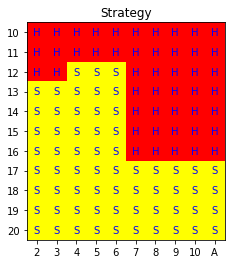

In [1302]:
s2.visualize_matrix()

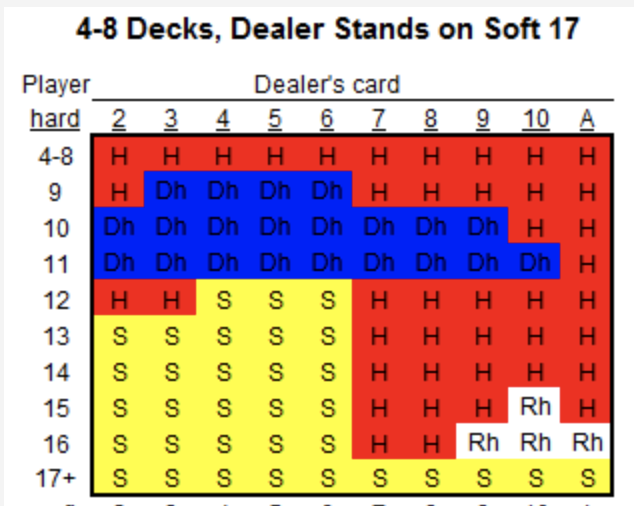

In [47]:
from IPython.display import Image
Image(filename='Basic_strategy.png') 

### Binary representation - meaning
- Take the matrix a_(1,1) = (10,2) a_(1,2) = (10,3)... a_(1,10) = (10,A) ... a_(11,1) = (20,2) ... a_(11,10) = (20,A)
- And create vector from it by giving row after row. 

In [35]:
s1 = [1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1]

# Simulating the game 
- Shuffle the deck, take a strategy and play. Return the amount of money that the player won. 

In [103]:
def get_shuffled_shoe(decks):
    shoe = []
    for i in range(decks*4):
        for name, value in Cards.__members__.items():
            shoe.append(value)
    shuffled_shoe = shuffle(shoe)
    return(shoe)

In [1305]:
def play_hand(shoe, strategy):
    dealer_cards = [shoe.pop()]
    player_cards = [shoe.pop(),shoe.pop()]
    
    dealer_sum = dealer_cards[0].value
    player_sum = sum([i.value for i in player_cards])  #TODO adjust for soft Aces. 
    
    while(player_sum<21):
        if(player_sum<10):
            player_cards.append(shoe.pop())
            player_sum = sum([i.value for i in player_cards])
        else:
            if(strategy.matrix_rep[player_sum-10, dealer_sum-2]==1):
                player_cards.append(shoe.pop())
                player_sum = sum([i.value for i in player_cards])  
            else:
                break
    
    while(dealer_sum<17 and player_sum<22):
        dealer_cards.append(shoe.pop())
        dealer_sum = sum([i.value for i in dealer_cards])

    return(player_sum, dealer_sum)    

In [1307]:
def simulate_game(strategy, rounds, bet_size):
    
    decks = round(rounds/10)+1
    shoe = get_shuffled_shoe(decks)
    money = 0
    
    for r in range(rounds):
        player_points, dealer_points = play_hand(shoe,strategy)
        players_gain = evaluate_play_results(player_points, dealer_points, bet_size)
                
        money = money+players_gain
        
    return(money)

In [1308]:
def evaluate_play_results(player_points, dealer_points, bet_size):        #TODO adjust for blackjacks... 
    if(player_points>21):
        return -bet_size
    elif(dealer_points>21):
        return bet_size
    elif(player_points>dealer_points):
        return bet_size
    elif(player_points==dealer_points):
        return 0 
    else:
        return -bet_size

In [1309]:
simulate_game(strat1,5000,50)

-105750

# Genetics 
- Create random population 
    - Get their fitness. 
    - Get statistics - best fitness - worst fitness - median, deciles, variation, save the best strategy. 
    - Create new generation with crossover and mutation functions, compute their fitness and add them to the pool. 
    - Stochastically remove weak players from the pool to a certain value.
    - Repeat until stopping rule (some fitness value, its delta, or number of steps... )
    

In [1310]:
def generate_random_population(pop_size):
    pop = []
    for i in (range(pop_size)):
        pop.append(Strategy(np.random.randint(2, size=110)))
    return pop

In [1311]:
class statistics: 
    it_number = 0
    max_values = []
    min_values = []
    means = []
    stds = []
    decils = []
    top_strategies = []

    def __init__(self):
        self.it_number = 0
        self.max_values = []
        self.min_values = []
        self.means = []
        self.stds = []
        self.decils = []
        self.top_strategies = []

In [1312]:
def stopping_rule(_type,value, threshold):
    return rules(_type)(value, threshold)  

In [1314]:
def rules(argument): 
    switcher = { 
        0: lambda x,threshold : x <threshold, 
        1: lambda y :print("Unknown rule:1")
    } 
    return switcher.get(argument, "nothing") 

In [1315]:
def update_stats(stats, pop, rounds, bet_size=50 ):
    
    fitness = []
    
    for player in pop: 
        fitness.append(simulate_game(player, rounds, bet_size))
        
    stats.it_number = stats.it_number+1
    stats.max_values.append(max(fitness))
    stats.min_values.append(min(fitness))
    stats.means.append(np.mean(fitness))
    stats.stds.append(np.std(fitness))
    stats.decils.append(np.percentile(fitness, np.arange(0, 100, 10)))
    stats.top_strategies.append(pop[fitness.index(max(fitness))])
    
    return(stats)

In [1316]:
def get_fitness_for_removal(pop,rounds,bet_size = 50):
    fitness = []
    
    for player in pop: 
        fitness.append(simulate_game(player, rounds, bet_size))
        
    return(fitness)

### Crossover
- For now the crossover is single point crossover between randomly created pairs of players. 
- Proposed generalizations
    - Players with better fitness mate with other fit players. Plus they have more children than the unfit ones. 
    - k-fold crossover. 
    

In [1318]:
def add_crossover(pop): 
    pop1 = random.sample(pop,round(len(pop)/2))
    pop2 = list(set(pop) - set(pop1))
    
    for i in range((round(len(pop)/2-1))):
        first_genom = pop1[i].binary_rep
        second_genom = pop1[i].binary_rep
        k = random.randrange(10,100)
        first_part = first_genom[:k]
        second_part = second_genom[k:]
        child_genom = np.concatenate([first_part, second_part])
        pop.append(Strategy(child_genom))

    return(pop)

In [1319]:
def add_mutants(pop, mutation_rate):
    new_pop = pop.copy()
    for player in pop: 
        change = np.random.choice([0, 1], size=(110,), p=[1-mutation_rate,mutation_rate])
        mutated_binary_rep = player.binary_rep.copy()
        for i in np.where(change==1)[0]:
            mutated_binary_rep[i] = 1- mutated_binary_rep[i]
            
        new_pop.append(Strategy(mutated_binary_rep))
        
    return(new_pop)

In [1320]:
def get_deadly_pdf(N, lucky_factor):
    x = np.linspace(0,lucky_factor,N)
    pdf = np.exp(-x**2/2)/np.sqrt(2*np.pi)
    pdf = pdf/np.sum(pdf)
   # print("Plotting your deadly pdf")
   # plt.plot(pdf)
    return(pdf)

In [1321]:
def sort_pop(pop, fitness):
    pop = np.array(pop)
    ages = np.array(fitness)
    inds = ages.argsort()
    return (pop[inds])

In [1324]:
def remove_the_weak(pop,lucky_factor, fitness, pop_size):
    
    sorted_pop = sort_pop(pop,fitness)
    
    N = len(pop)
    n = len(pop)-pop_size
    pdf = get_deadly_pdf(N,3)
    x = np.linspace(0,1,N)
    indices = np.full(x.shape, False, bool)
    randices = np.random.choice(np.arange(indices.shape[0]), n, replace = False,p = pdf)
    indices[randices] = True
    #print(indices)
    remaining_population = np.array(sorted_pop)[~indices]
    
    return(remaining_population.tolist())

In [1325]:
def complete_simulation(pop_size,iterations, stopping_rule_type, rounds): 
    stats = statistics()
    pop = generate_random_population(pop_size)
    _continue = stopping_rule(stopping_rule_type,stats.it_number,iterations)
 
    while(_continue):
        print("Iteration: "+str(stats.it_number))
        stats = update_stats(stats, pop, rounds)
        pop = add_crossover(pop)
        pop = add_mutants(pop,0.01)     # Maybe adding the mutants instead of replacing is not standard  

        fitness_for_removal = get_fitness_for_removal(pop,rounds)
        pop = remove_the_weak(pop,3, fitness_for_removal, pop_size)

        _continue = stopping_rule(stopping_rule_type,stats.it_number,iterations)
        
    return(stats) 

In [1326]:
pop_size = 100
iterations = 1000
stopping_rule_type = 0 # 0 - "number of iterations"
rounds = 1000

In [1293]:
result = complete_simulation(pop_size, iterations, stopping_rule_type, rounds)

Iteration: 0
<class 'list'>
<class 'list'>
Iteration: 1
<class 'list'>
<class 'list'>
Iteration: 2
<class 'list'>
<class 'list'>
Iteration: 3
<class 'list'>
<class 'list'>
Iteration: 4
<class 'list'>
<class 'list'>
Iteration: 5
<class 'list'>
<class 'list'>
Iteration: 6
<class 'list'>
<class 'list'>
Iteration: 7
<class 'list'>
<class 'list'>
Iteration: 8
<class 'list'>
<class 'list'>
Iteration: 9
<class 'list'>
<class 'list'>
Iteration: 10
<class 'list'>
<class 'list'>
Iteration: 11
<class 'list'>
<class 'list'>
Iteration: 12
<class 'list'>
<class 'list'>
Iteration: 13
<class 'list'>
<class 'list'>
Iteration: 14
<class 'list'>
<class 'list'>
Iteration: 15
<class 'list'>
<class 'list'>
Iteration: 16
<class 'list'>
<class 'list'>
Iteration: 17
<class 'list'>
<class 'list'>
Iteration: 18
<class 'list'>
<class 'list'>
Iteration: 19
<class 'list'>
<class 'list'>
Iteration: 20
<class 'list'>
<class 'list'>
Iteration: 21
<class 'list'>
<class 'list'>
Iteration: 22
<class 'list'>
<class 'list'

<class 'list'>
Iteration: 185
<class 'list'>
<class 'list'>
Iteration: 186
<class 'list'>
<class 'list'>
Iteration: 187
<class 'list'>
<class 'list'>
Iteration: 188
<class 'list'>
<class 'list'>
Iteration: 189
<class 'list'>
<class 'list'>
Iteration: 190
<class 'list'>
<class 'list'>
Iteration: 191
<class 'list'>
<class 'list'>
Iteration: 192
<class 'list'>
<class 'list'>
Iteration: 193
<class 'list'>
<class 'list'>
Iteration: 194
<class 'list'>
<class 'list'>
Iteration: 195
<class 'list'>
<class 'list'>
Iteration: 196
<class 'list'>
<class 'list'>
Iteration: 197
<class 'list'>
<class 'list'>
Iteration: 198
<class 'list'>
<class 'list'>
Iteration: 199
<class 'list'>
<class 'list'>
Iteration: 200
<class 'list'>
<class 'list'>
Iteration: 201
<class 'list'>
<class 'list'>
Iteration: 202
<class 'list'>
<class 'list'>
Iteration: 203
<class 'list'>
<class 'list'>
Iteration: 204
<class 'list'>
<class 'list'>
Iteration: 205
<class 'list'>
<class 'list'>
Iteration: 206
<class 'list'>
<class 'li

<class 'list'>
<class 'list'>
Iteration: 368
<class 'list'>
<class 'list'>
Iteration: 369
<class 'list'>
<class 'list'>
Iteration: 370
<class 'list'>
<class 'list'>
Iteration: 371
<class 'list'>
<class 'list'>
Iteration: 372
<class 'list'>
<class 'list'>
Iteration: 373
<class 'list'>
<class 'list'>
Iteration: 374
<class 'list'>
<class 'list'>
Iteration: 375
<class 'list'>
<class 'list'>
Iteration: 376
<class 'list'>
<class 'list'>
Iteration: 377
<class 'list'>
<class 'list'>
Iteration: 378
<class 'list'>
<class 'list'>
Iteration: 379
<class 'list'>
<class 'list'>
Iteration: 380
<class 'list'>
<class 'list'>
Iteration: 381
<class 'list'>
<class 'list'>
Iteration: 382
<class 'list'>
<class 'list'>
Iteration: 383
<class 'list'>
<class 'list'>
Iteration: 384
<class 'list'>
<class 'list'>
Iteration: 385
<class 'list'>
<class 'list'>
Iteration: 386
<class 'list'>
<class 'list'>
Iteration: 387
<class 'list'>
<class 'list'>
Iteration: 388
<class 'list'>
<class 'list'>
Iteration: 389
<class 'li

<class 'list'>
Iteration: 550
<class 'list'>
<class 'list'>
Iteration: 551
<class 'list'>
<class 'list'>
Iteration: 552
<class 'list'>
<class 'list'>
Iteration: 553
<class 'list'>
<class 'list'>
Iteration: 554
<class 'list'>
<class 'list'>
Iteration: 555
<class 'list'>
<class 'list'>
Iteration: 556
<class 'list'>
<class 'list'>
Iteration: 557
<class 'list'>
<class 'list'>
Iteration: 558
<class 'list'>
<class 'list'>
Iteration: 559
<class 'list'>
<class 'list'>
Iteration: 560
<class 'list'>
<class 'list'>
Iteration: 561
<class 'list'>
<class 'list'>
Iteration: 562
<class 'list'>
<class 'list'>
Iteration: 563
<class 'list'>
<class 'list'>
Iteration: 564
<class 'list'>
<class 'list'>
Iteration: 565
<class 'list'>
<class 'list'>
Iteration: 566
<class 'list'>
<class 'list'>
Iteration: 567
<class 'list'>
<class 'list'>
Iteration: 568
<class 'list'>
<class 'list'>
Iteration: 569
<class 'list'>
<class 'list'>
Iteration: 570
<class 'list'>
<class 'list'>
Iteration: 571
<class 'list'>
<class 'li

<class 'list'>
<class 'list'>
Iteration: 733
<class 'list'>
<class 'list'>
Iteration: 734
<class 'list'>
<class 'list'>
Iteration: 735
<class 'list'>
<class 'list'>
Iteration: 736
<class 'list'>
<class 'list'>
Iteration: 737
<class 'list'>
<class 'list'>
Iteration: 738
<class 'list'>
<class 'list'>
Iteration: 739
<class 'list'>
<class 'list'>
Iteration: 740
<class 'list'>
<class 'list'>
Iteration: 741
<class 'list'>
<class 'list'>
Iteration: 742
<class 'list'>
<class 'list'>
Iteration: 743
<class 'list'>
<class 'list'>
Iteration: 744
<class 'list'>
<class 'list'>
Iteration: 745
<class 'list'>
<class 'list'>
Iteration: 746
<class 'list'>
<class 'list'>
Iteration: 747
<class 'list'>
<class 'list'>
Iteration: 748
<class 'list'>
<class 'list'>
Iteration: 749
<class 'list'>
<class 'list'>
Iteration: 750
<class 'list'>
<class 'list'>
Iteration: 751
<class 'list'>
<class 'list'>
Iteration: 752
<class 'list'>
<class 'list'>
Iteration: 753
<class 'list'>
<class 'list'>
Iteration: 754
<class 'li

<class 'list'>
Iteration: 915
<class 'list'>
<class 'list'>
Iteration: 916
<class 'list'>
<class 'list'>
Iteration: 917
<class 'list'>
<class 'list'>
Iteration: 918
<class 'list'>
<class 'list'>
Iteration: 919
<class 'list'>
<class 'list'>
Iteration: 920
<class 'list'>
<class 'list'>
Iteration: 921
<class 'list'>
<class 'list'>
Iteration: 922
<class 'list'>
<class 'list'>
Iteration: 923
<class 'list'>
<class 'list'>
Iteration: 924
<class 'list'>
<class 'list'>
Iteration: 925
<class 'list'>
<class 'list'>
Iteration: 926
<class 'list'>
<class 'list'>
Iteration: 927
<class 'list'>
<class 'list'>
Iteration: 928
<class 'list'>
<class 'list'>
Iteration: 929
<class 'list'>
<class 'list'>
Iteration: 930
<class 'list'>
<class 'list'>
Iteration: 931
<class 'list'>
<class 'list'>
Iteration: 932
<class 'list'>
<class 'list'>
Iteration: 933
<class 'list'>
<class 'list'>
Iteration: 934
<class 'list'>
<class 'list'>
Iteration: 935
<class 'list'>
<class 'list'>
Iteration: 936
<class 'list'>
<class 'li

In [1294]:
result.it_number

1000

In [1295]:
result.max_values

[-10500,
 -8600,
 -7700,
 -7450,
 -6100,
 -5350,
 -6050,
 -7150,
 -6350,
 -6050,
 -5950,
 -4900,
 -5750,
 -4850,
 -6500,
 -4750,
 -5250,
 -4200,
 -5350,
 -4550,
 -5150,
 -4700,
 -4900,
 -3500,
 -4100,
 -3350,
 -3250,
 -4000,
 -3500,
 -3950,
 -2600,
 -3250,
 -2900,
 -2850,
 -1700,
 -1600,
 -2650,
 -3500,
 -2900,
 -2100,
 -3350,
 -750,
 -2000,
 -1650,
 -3350,
 -2300,
 -1350,
 -1600,
 -1950,
 -1650,
 -1300,
 -2100,
 -2750,
 -1400,
 -2550,
 -2100,
 -2150,
 -2350,
 -1550,
 -1050,
 -1000,
 -1350,
 -2200,
 -50,
 -1350,
 -250,
 100,
 -250,
 100,
 -700,
 -1250,
 -350,
 -750,
 200,
 -900,
 -1950,
 1100,
 -700,
 -750,
 -1150,
 1500,
 -800,
 -150,
 -1100,
 -100,
 -750,
 -450,
 -450,
 800,
 150,
 -550,
 0,
 500,
 -900,
 -1600,
 1200,
 1250,
 1000,
 -200,
 1000,
 1050,
 -200,
 550,
 500,
 1400,
 400,
 -200,
 50,
 1700,
 -500,
 50,
 -1000,
 -1000,
 50,
 -400,
 -100,
 -800,
 1100,
 -300,
 400,
 -800,
 950,
 -500,
 750,
 1150,
 200,
 -150,
 1400,
 300,
 -450,
 500,
 350,
 250,
 400,
 150,
 1450,
 -350,

In [1286]:
result.means

[-8404.0,
 -7389.0,
 -6774.5,
 -6312.5,
 -6199.5,
 -5930.0,
 -6143.5,
 -5823.0,
 -5868.5,
 -5552.0,
 -5437.5,
 -5640.5,
 -5154.5,
 -5249.0,
 -5155.5,
 -5045.5,
 -4793.5,
 -4684.0,
 -4589.0,
 -4339.5,
 -4339.0,
 -4206.5,
 -4041.5,
 -4006.5,
 -3881.5,
 -3985.5,
 -3831.5,
 -3673.0,
 -3695.0,
 -3489.5,
 -3618.0,
 -3691.5,
 -3613.5,
 -3831.5,
 -3552.0,
 -3566.5,
 -3615.5,
 -3396.0,
 -3401.0,
 -3340.0,
 -3382.0,
 -3266.5,
 -3489.5,
 -3059.5,
 -3291.0,
 -3205.0,
 -3097.0,
 -2922.5,
 -2955.5,
 -2909.5,
 -3114.5,
 -2973.5,
 -2884.5,
 -2819.5,
 -2867.0,
 -3012.0,
 -2938.0,
 -2934.5,
 -2946.5,
 -2822.5,
 -2744.0,
 -2785.0,
 -2918.0,
 -2619.0,
 -2578.0,
 -2489.0,
 -2402.5,
 -2586.0,
 -2358.0,
 -2085.0,
 -2419.0,
 -2186.0,
 -2328.5,
 -2360.0,
 -2189.0,
 -2356.5,
 -2344.0,
 -2328.5,
 -2220.0,
 -2097.5,
 -2228.0,
 -2123.0,
 -2295.5,
 -2299.0,
 -2121.5,
 -2326.0,
 -1824.5,
 -2128.0,
 -2164.0,
 -2057.5,
 -2339.5,
 -2221.5,
 -2190.5,
 -2126.0,
 -2160.0,
 -2193.0,
 -2068.0,
 -2159.5,
 -2095.5,
 -2063.0,


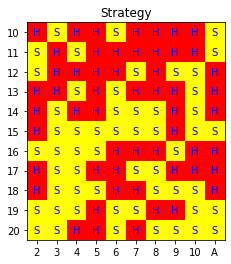

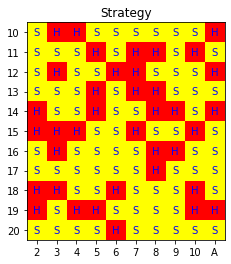

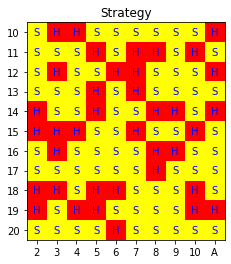

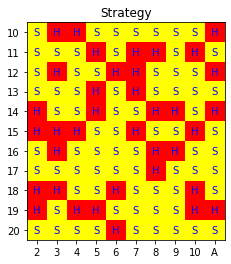

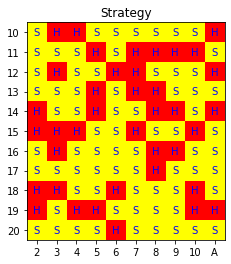

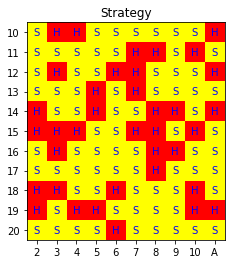

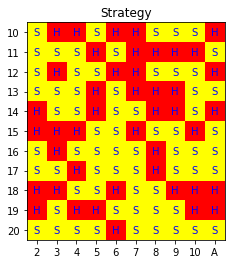

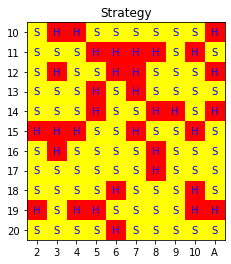

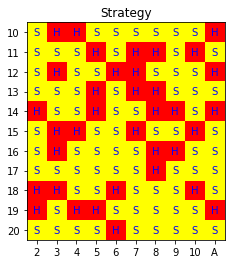

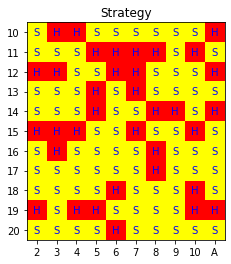

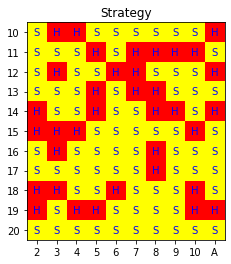

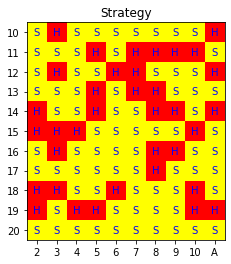

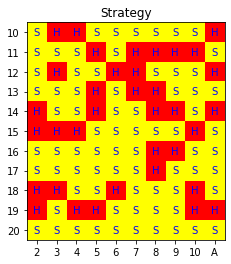

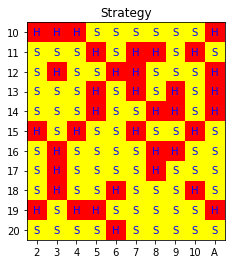

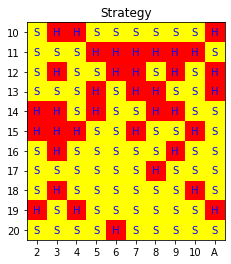

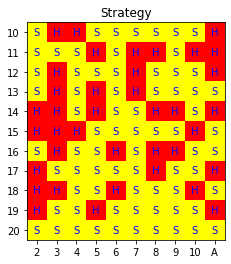

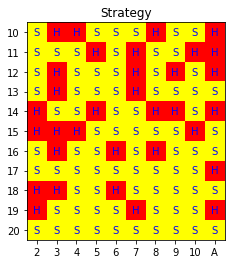

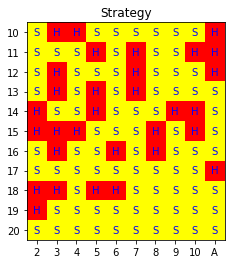

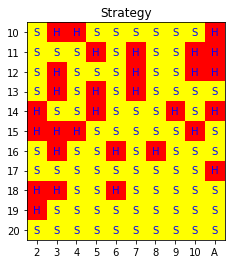

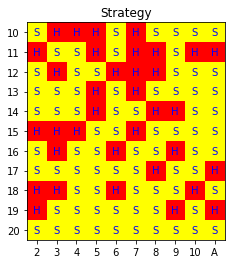

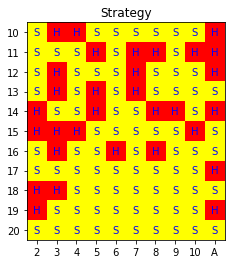

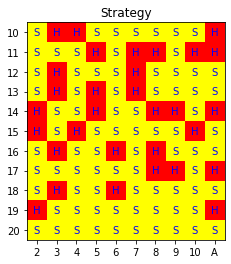

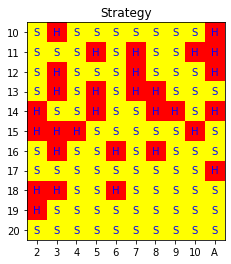

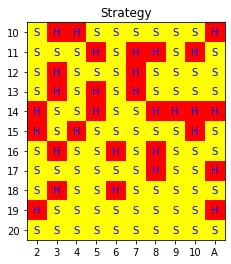

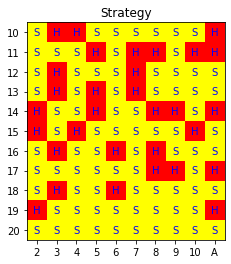

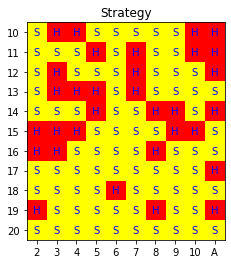

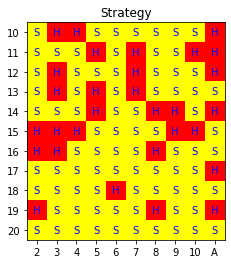

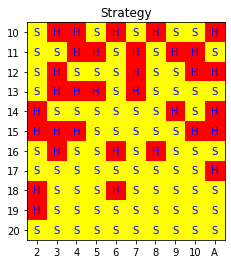

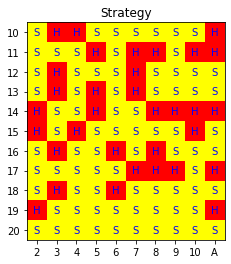

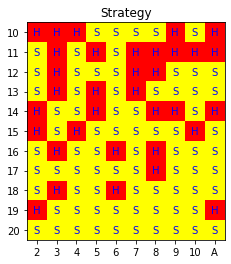

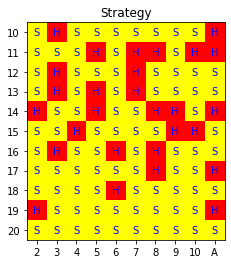

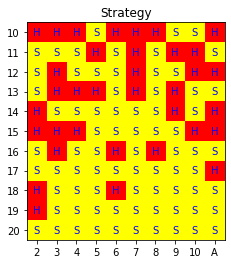

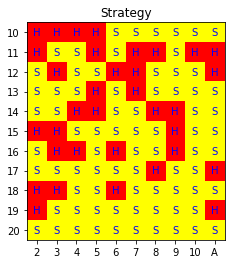

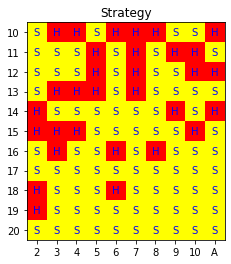

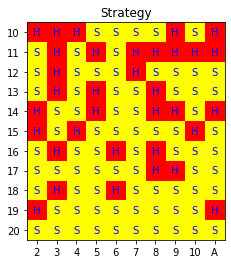

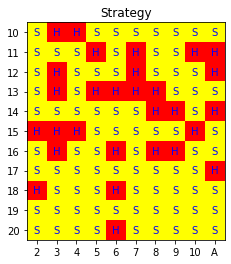

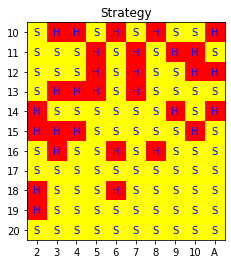

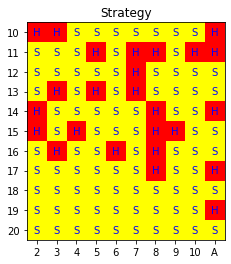

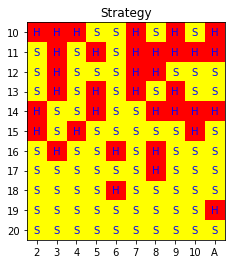

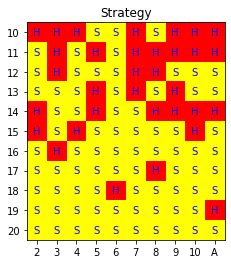

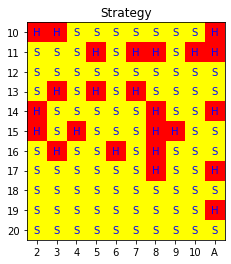

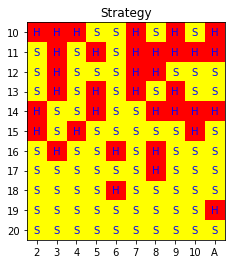

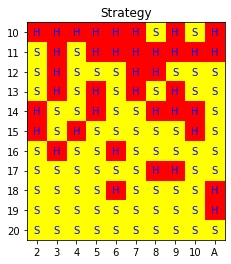

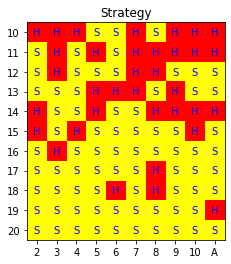

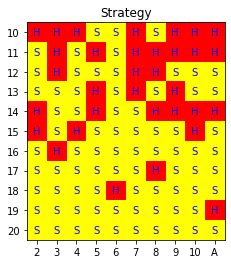

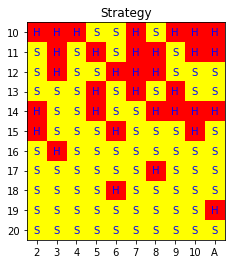

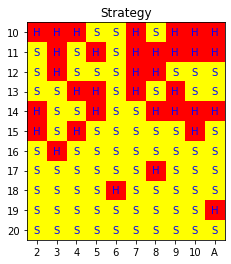

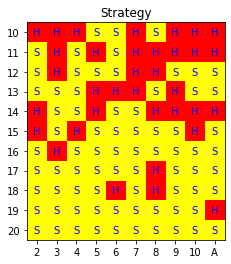

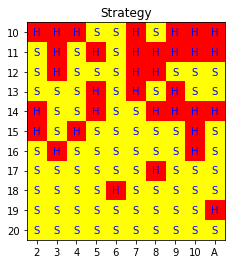

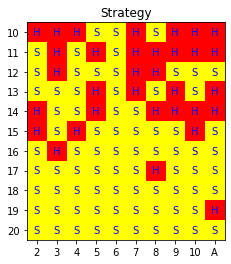

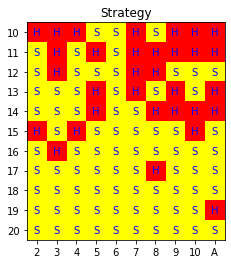

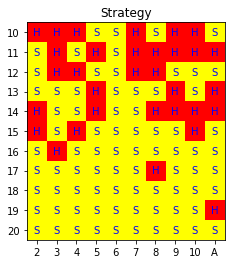

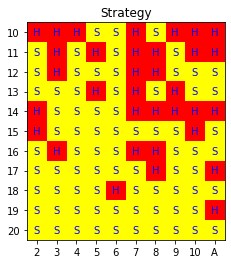

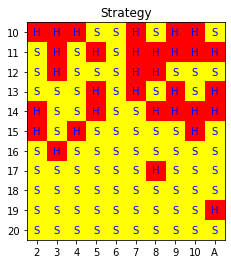

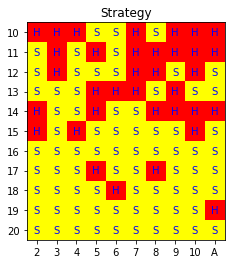

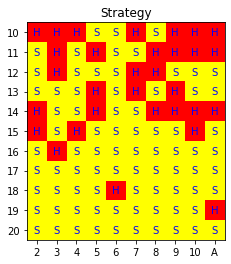

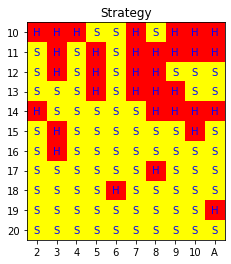

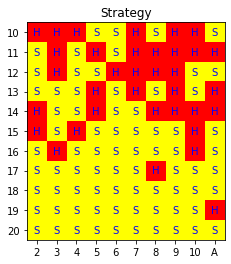

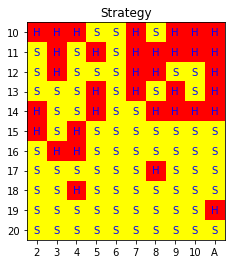

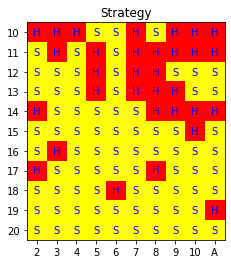

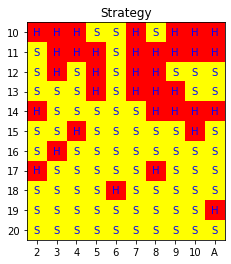

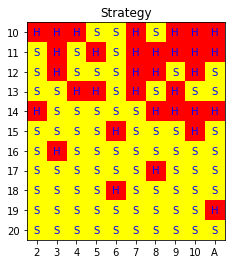

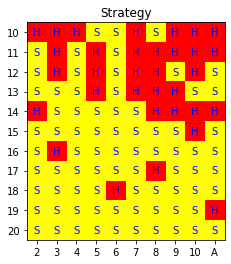

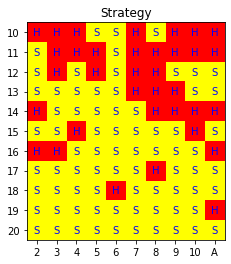

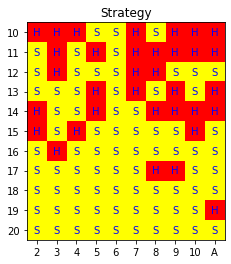

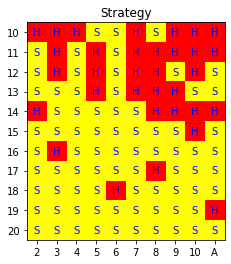

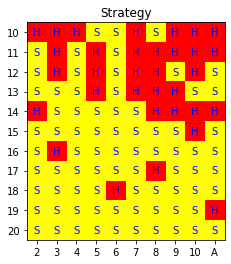

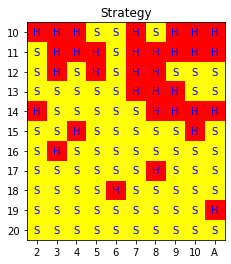

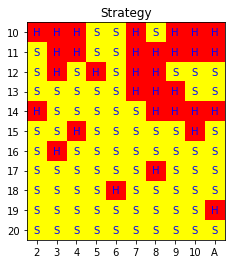

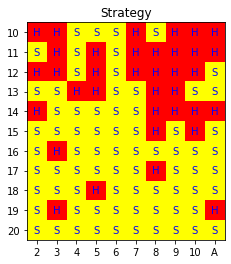

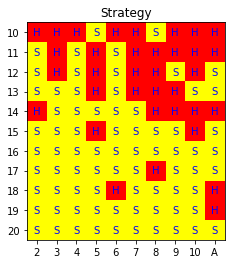

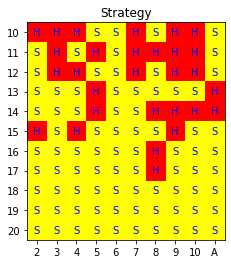

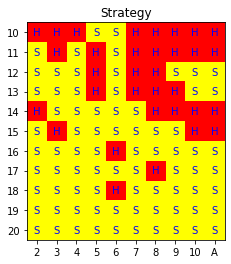

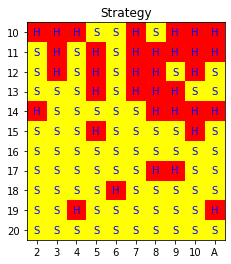

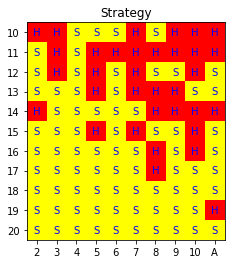

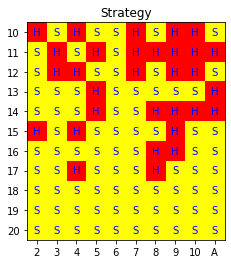

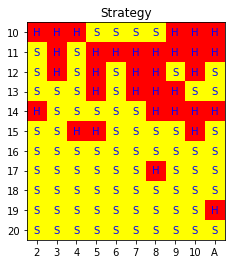

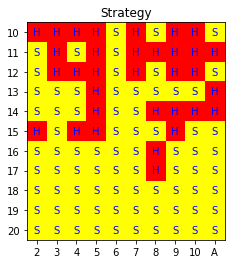

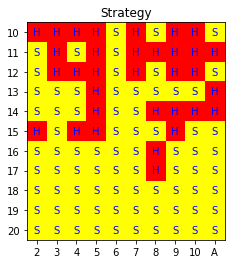

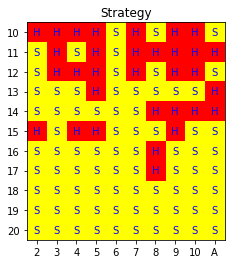

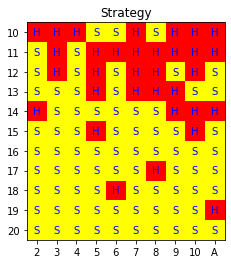

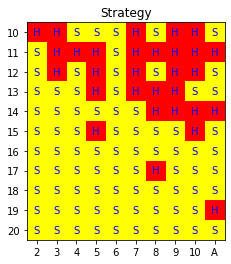

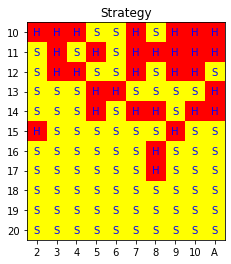

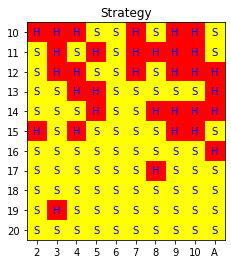

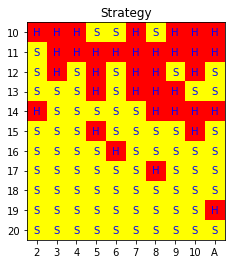

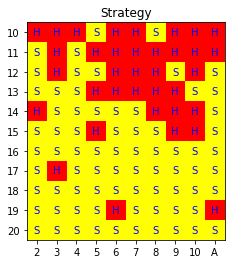

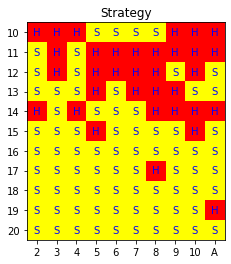

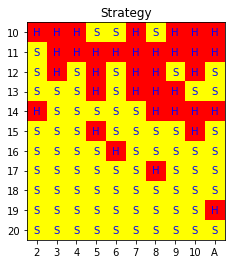

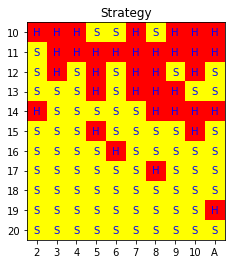

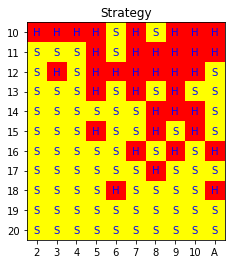

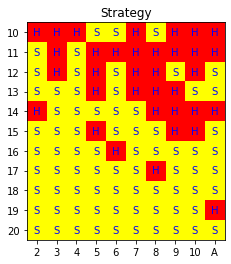

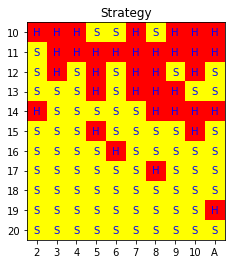

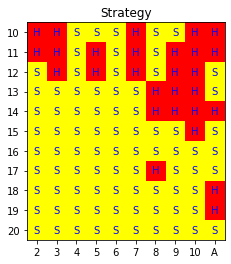

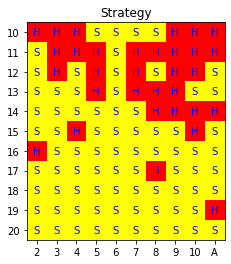

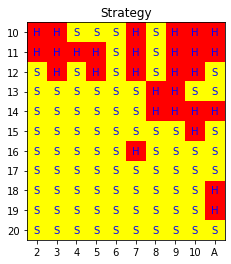

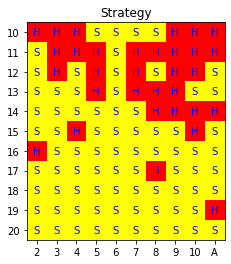

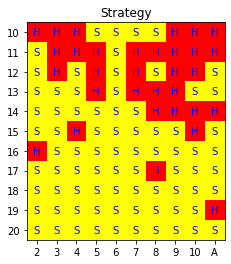

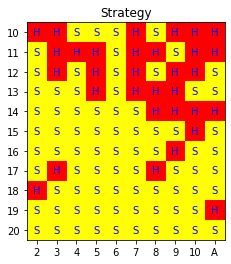

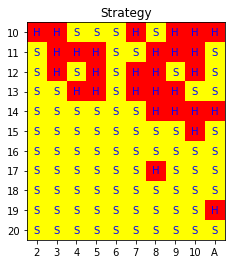

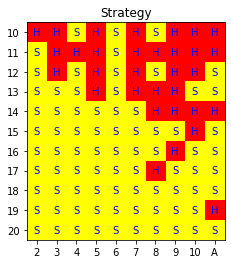

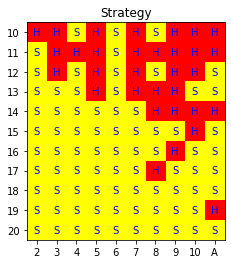

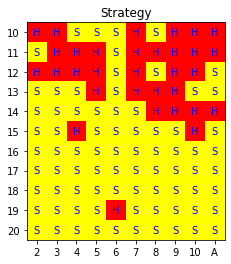

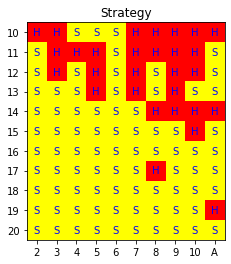

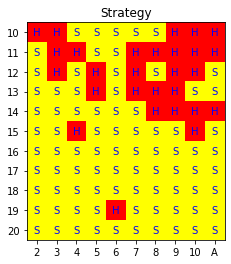

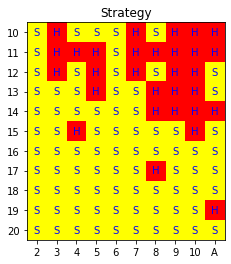

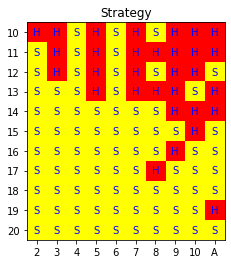

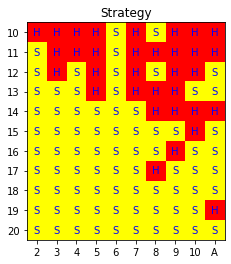

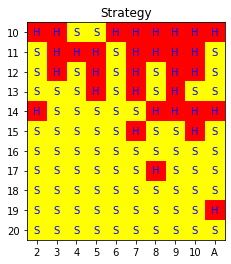

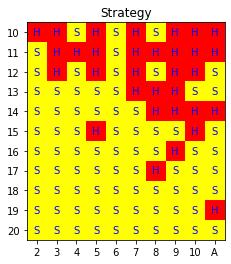

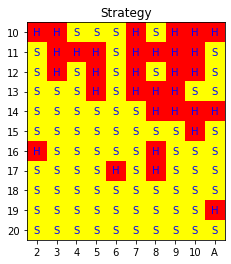

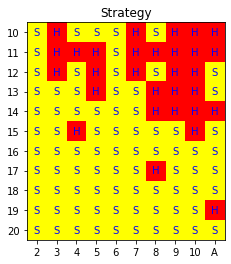

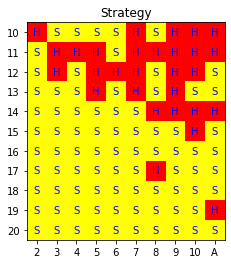

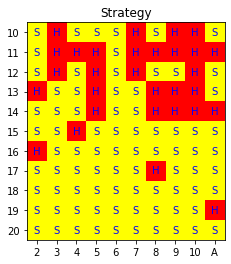

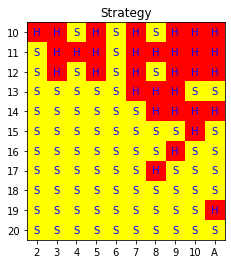

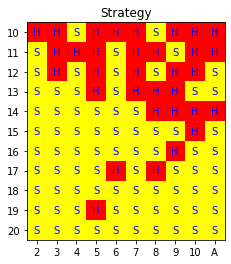

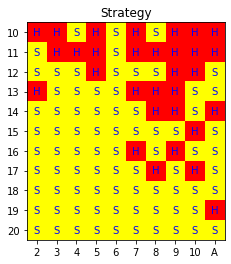

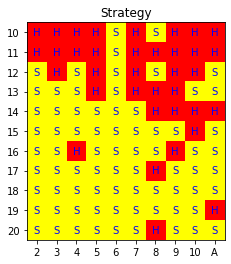

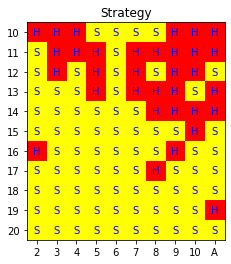

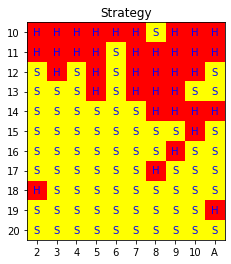

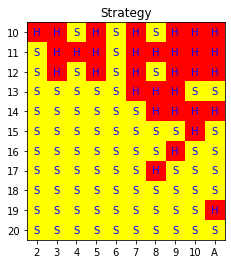

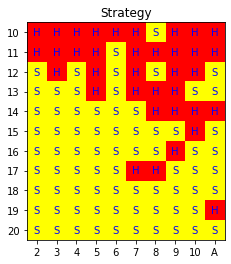

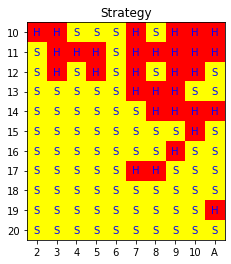

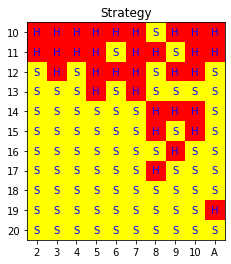

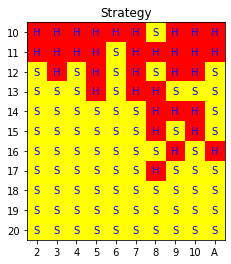

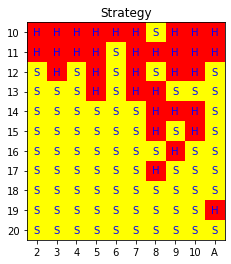

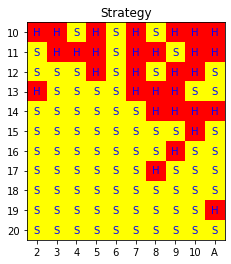

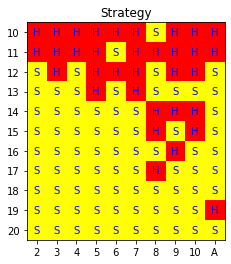

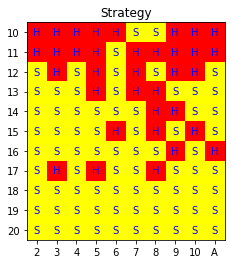

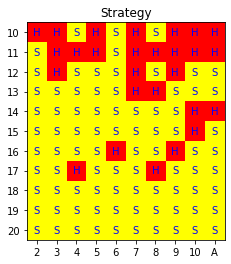

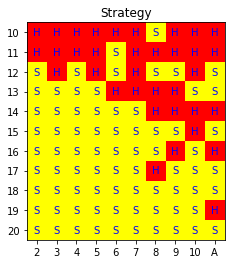

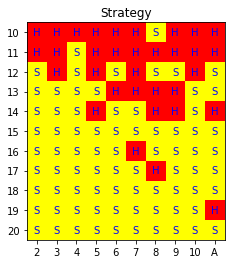

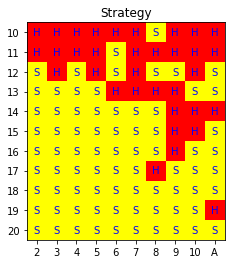

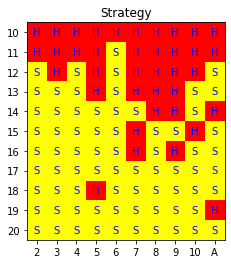

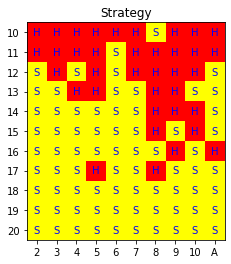

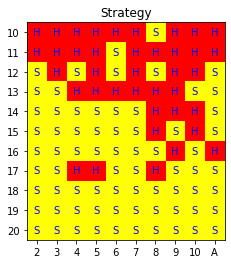

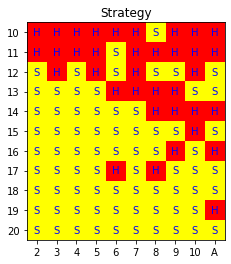

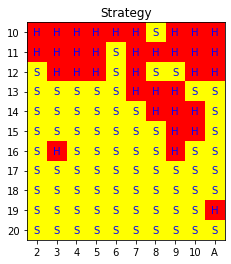

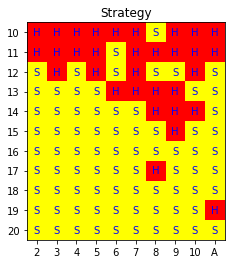

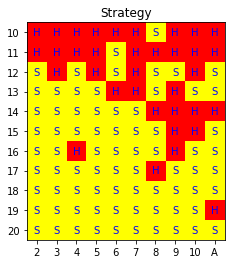

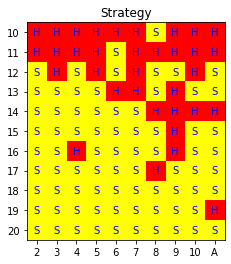

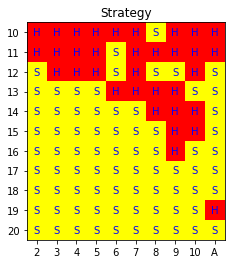

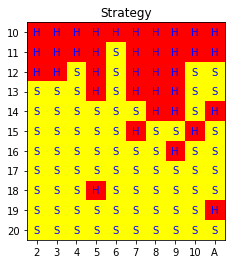

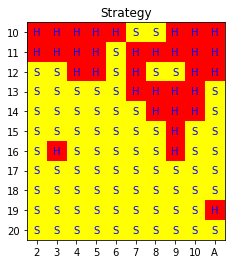

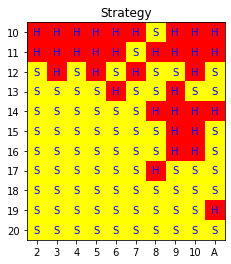

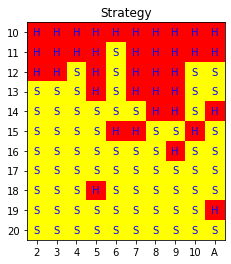

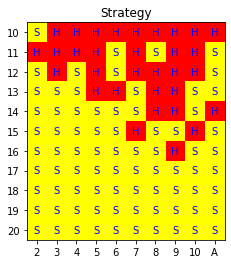

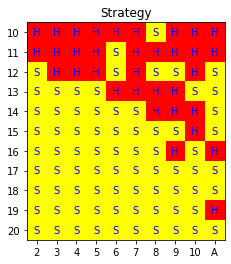

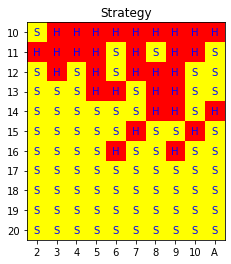

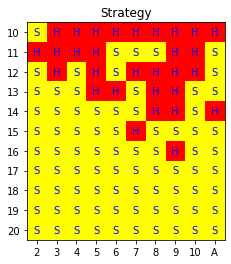

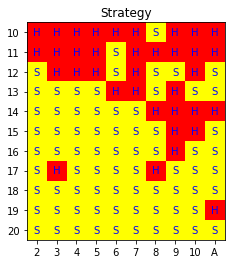

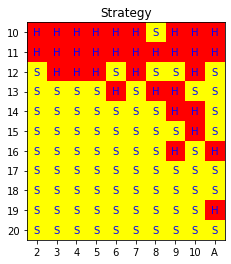

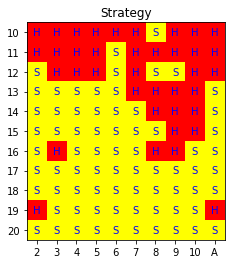

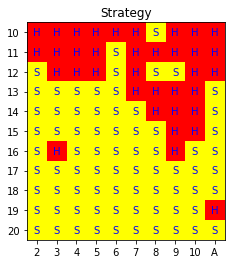

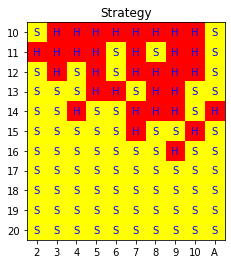

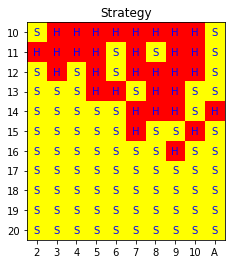

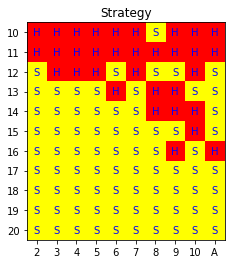

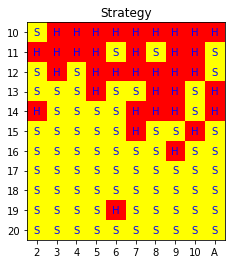

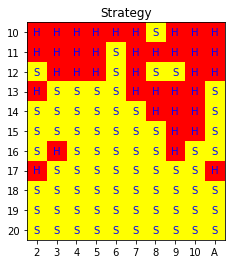

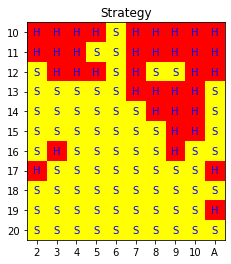

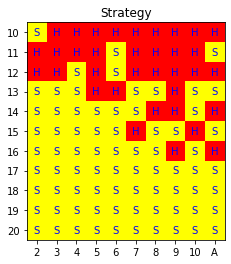

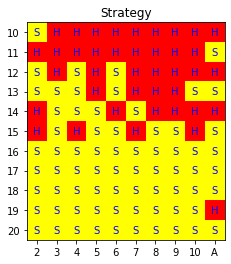

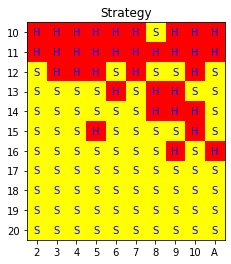

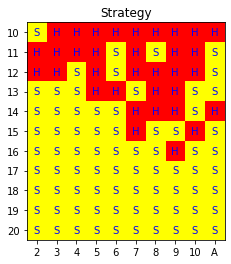

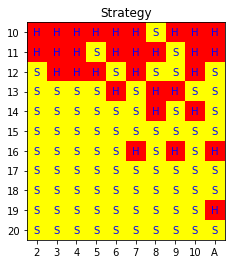

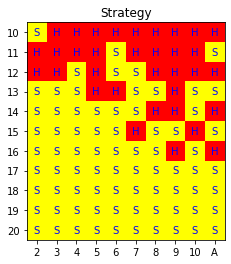

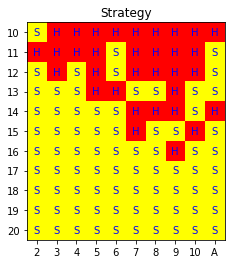

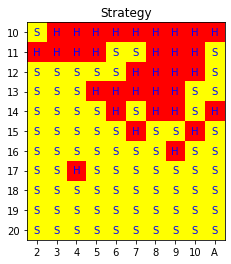

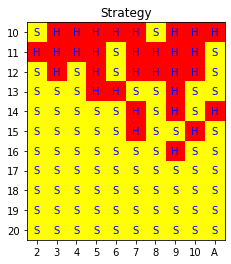

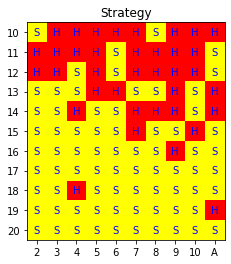

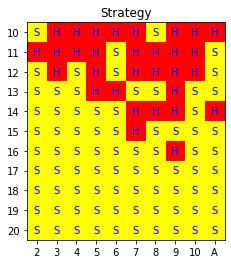

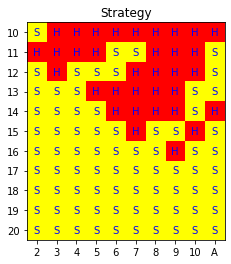

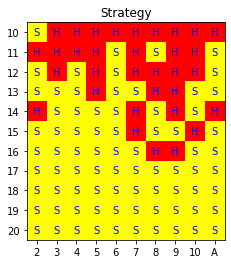

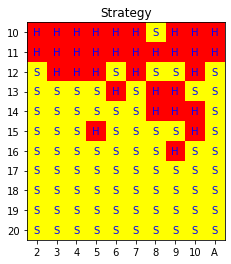

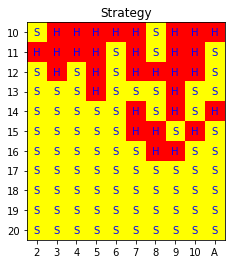

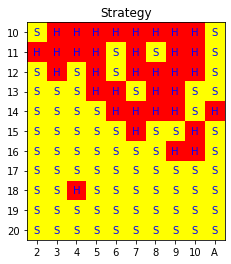

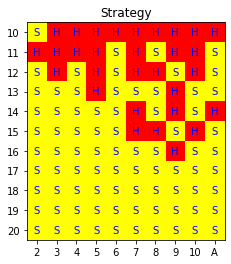

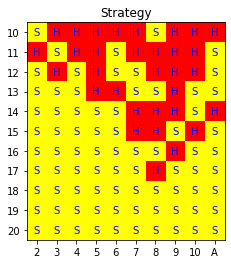

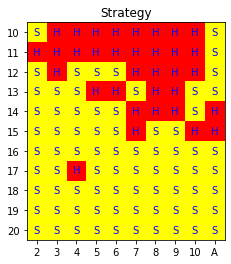

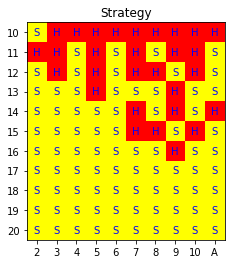

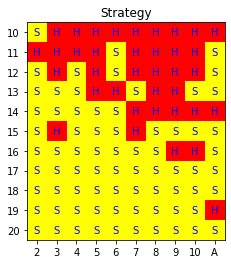

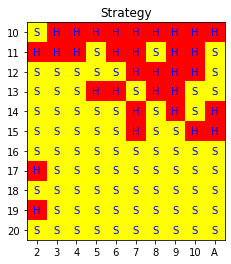

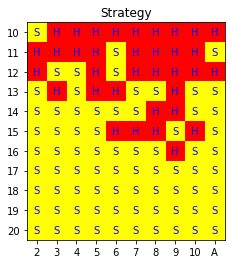

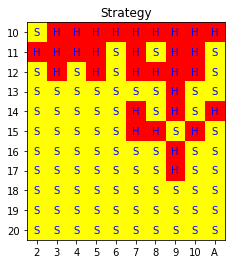

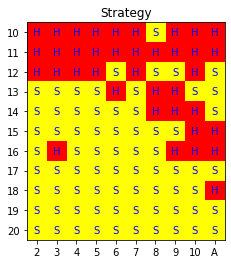

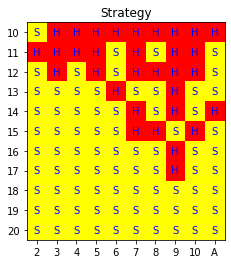

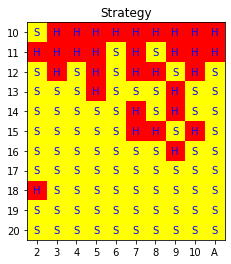

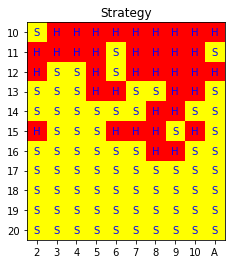

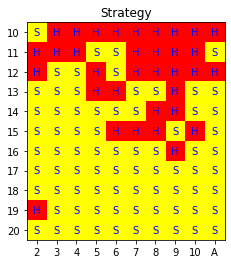

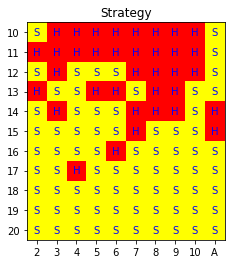

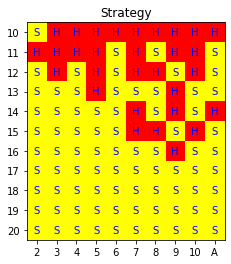

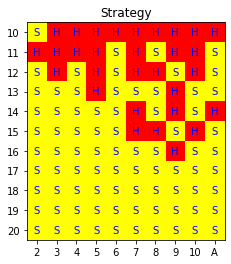

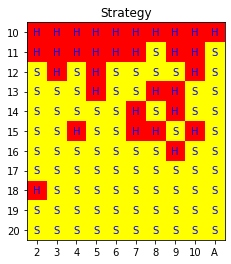

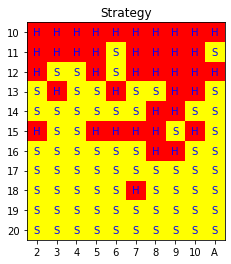

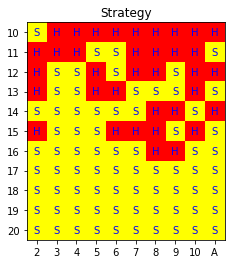

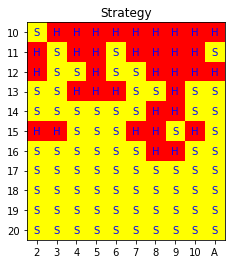

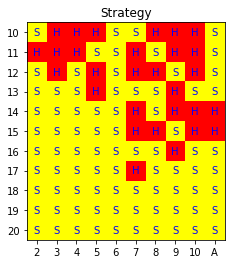

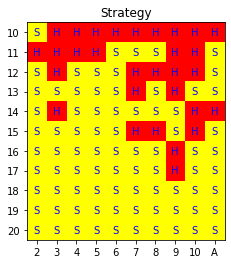

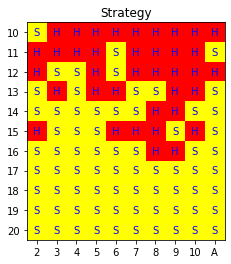

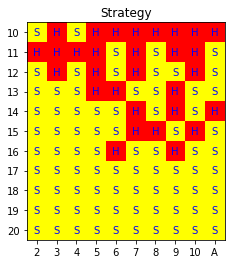

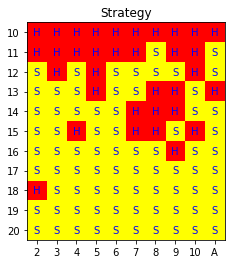

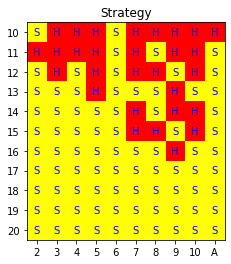

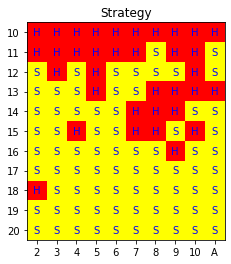

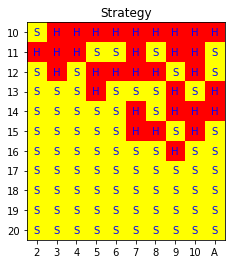

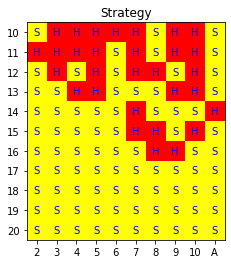

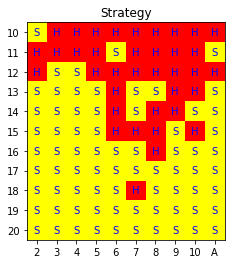

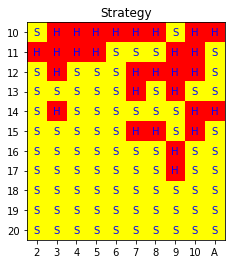

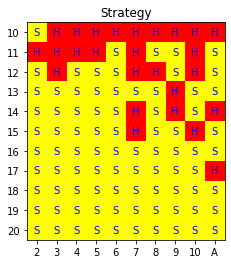

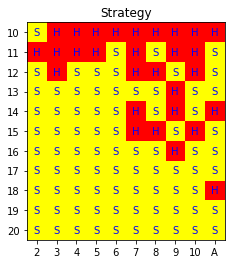

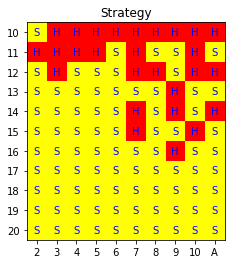

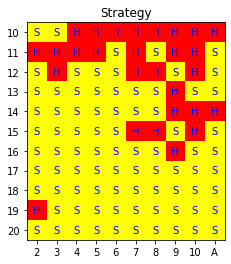

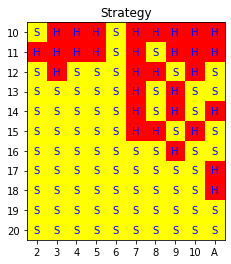

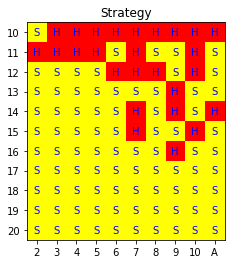

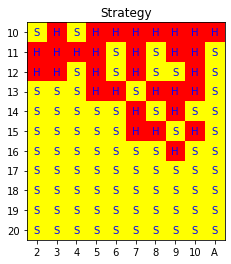

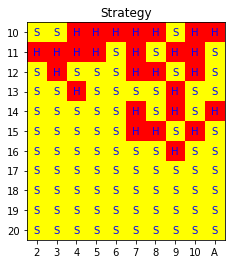

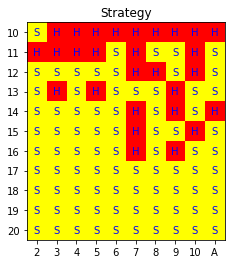

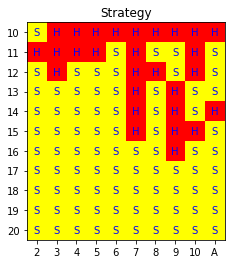

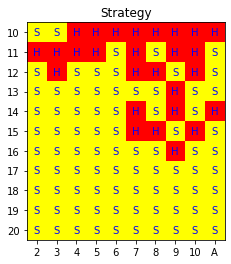

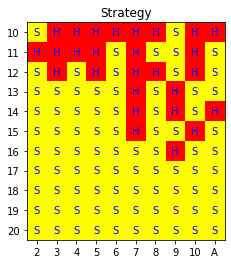

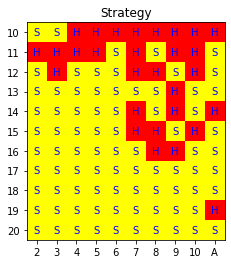

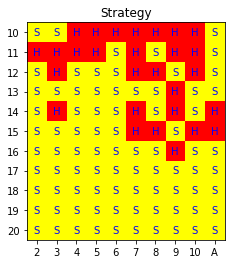

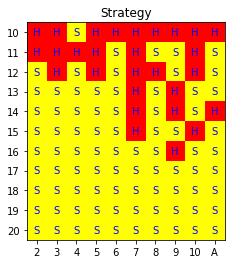

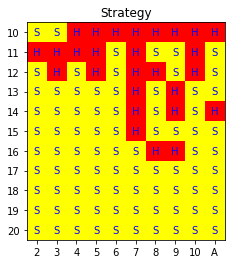

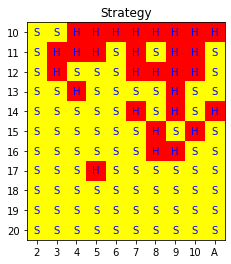

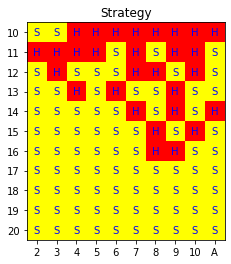

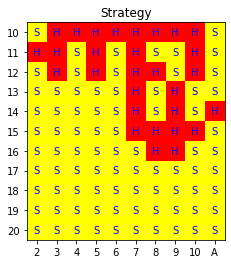

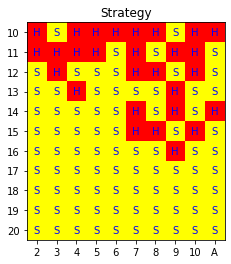

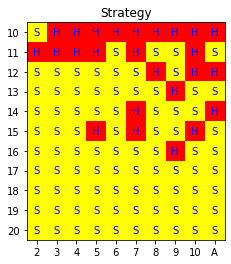

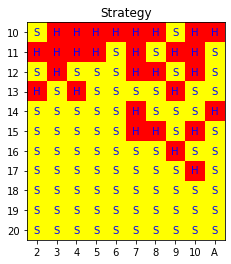

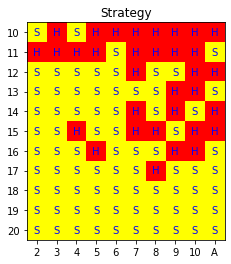

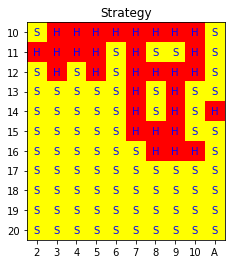

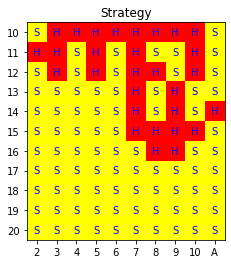

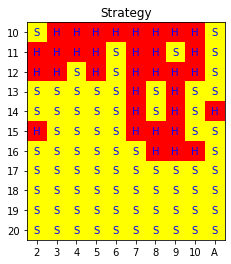

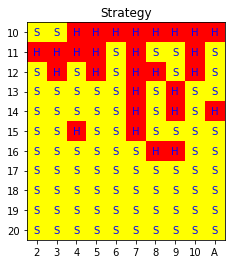

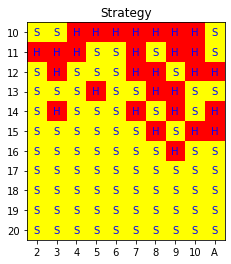

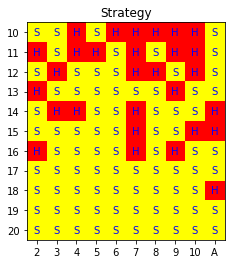

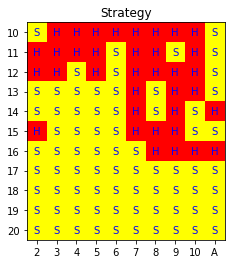

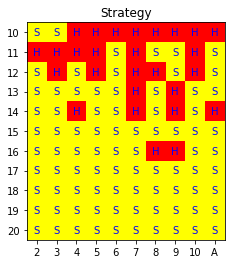

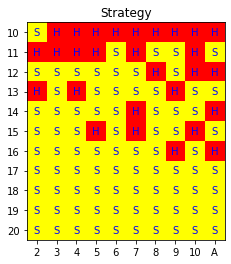

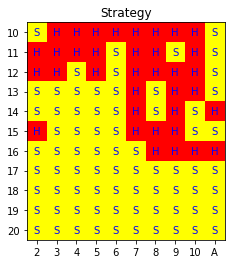

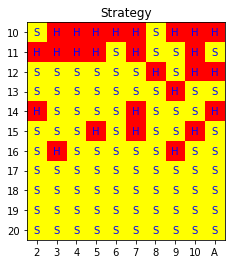

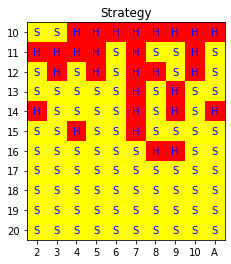

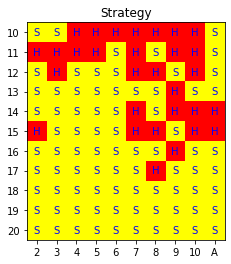

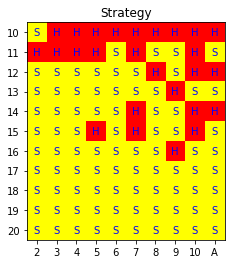

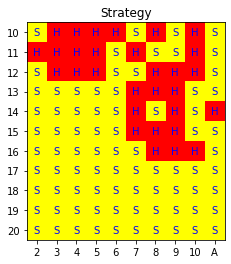

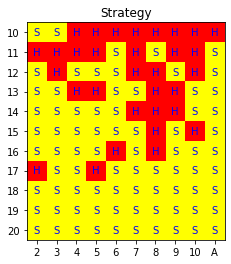

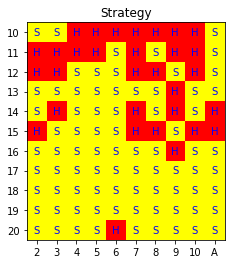

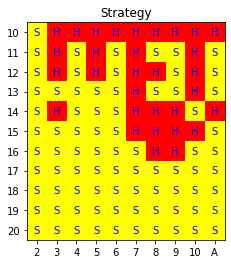

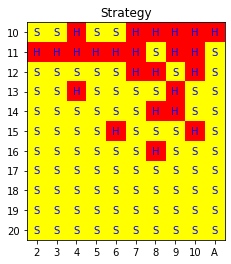

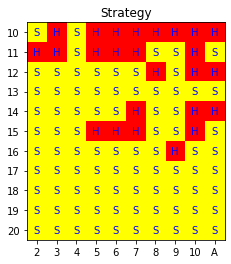

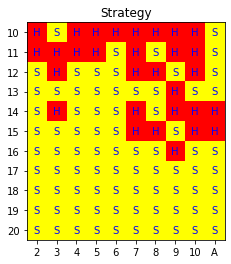

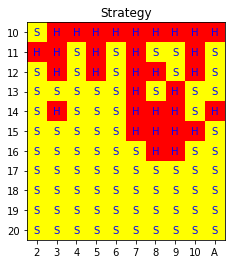

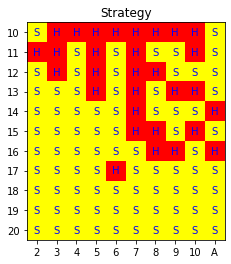

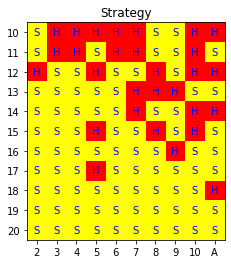

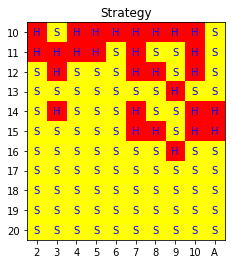

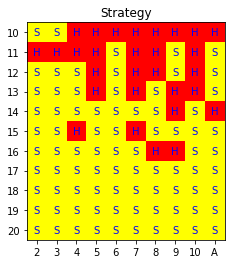

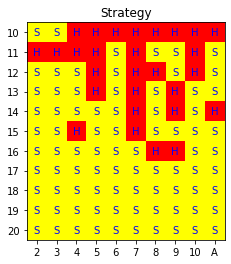

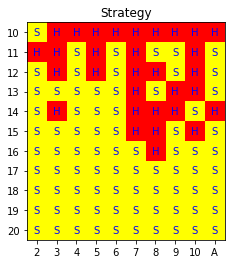

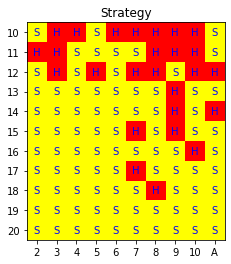

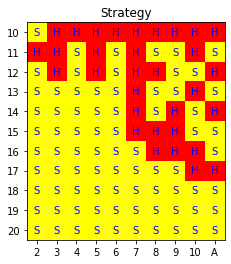

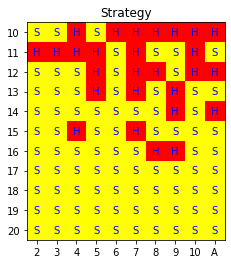

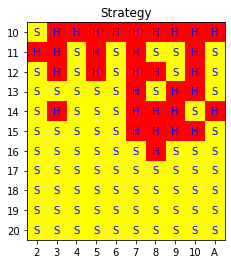

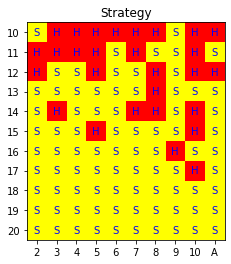

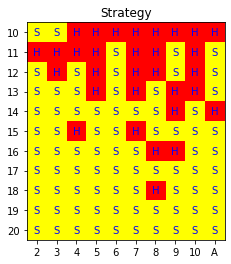

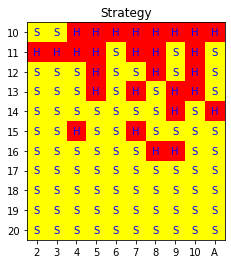

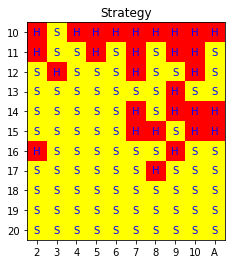

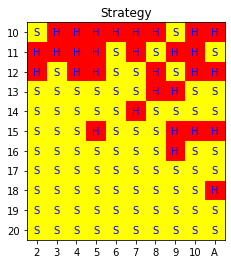

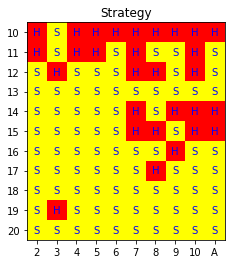

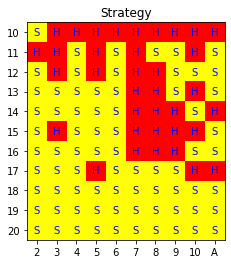

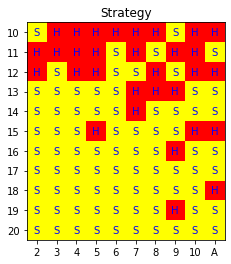

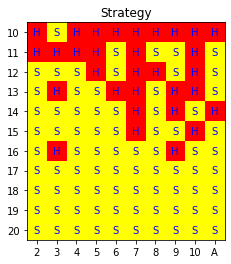

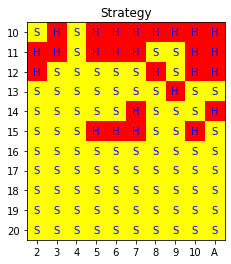

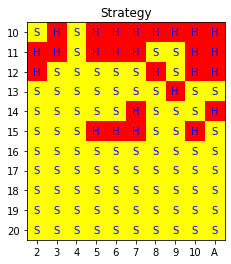

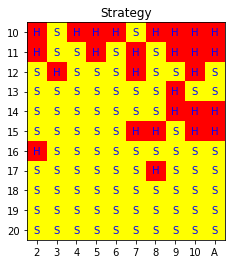

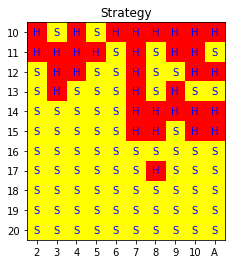

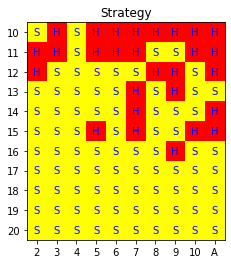

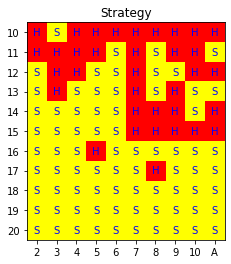

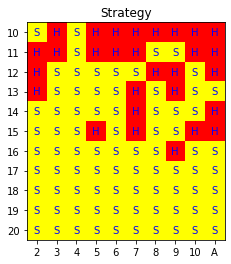

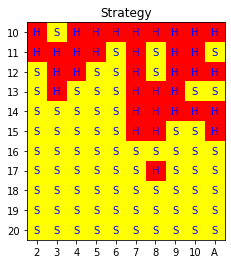

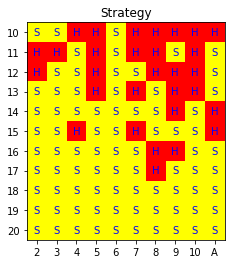

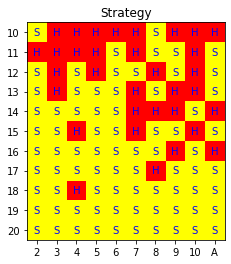

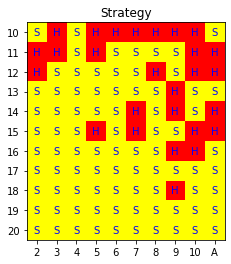

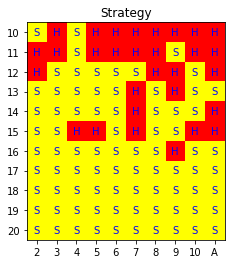

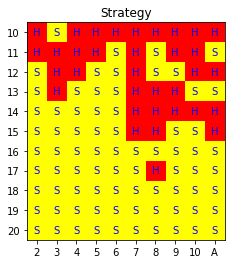

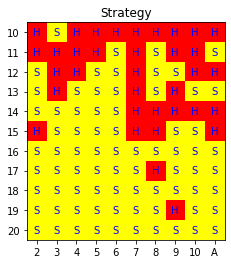

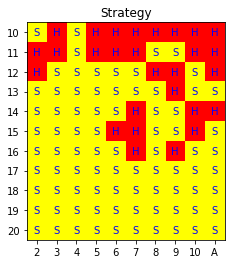

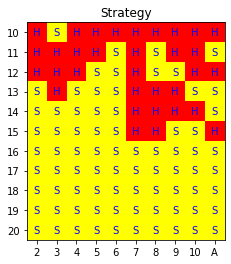

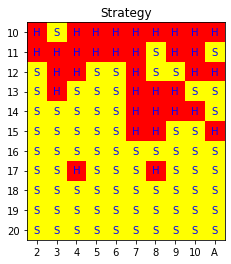

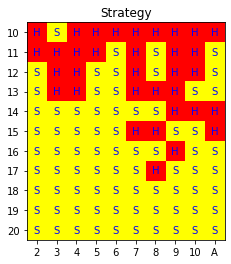

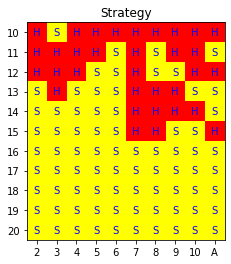

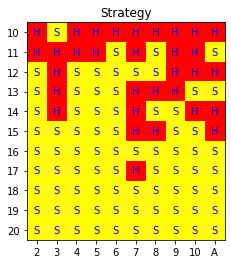

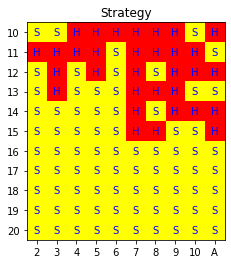

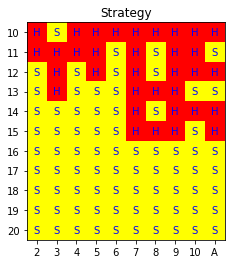

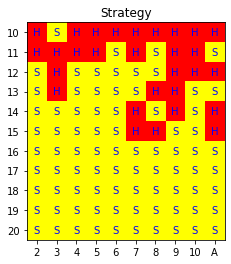

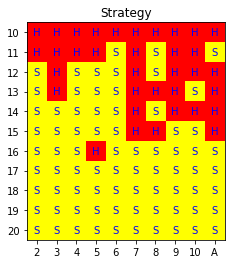

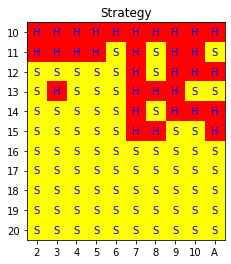

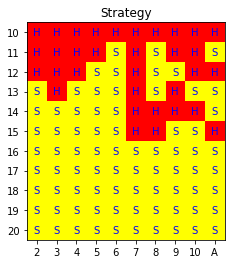

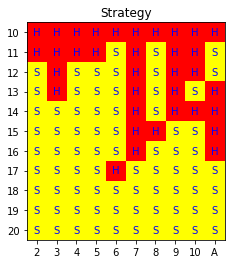

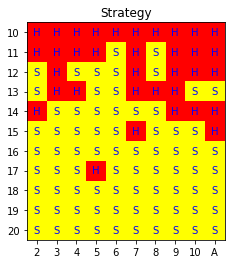

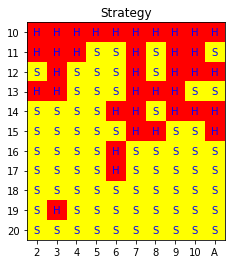

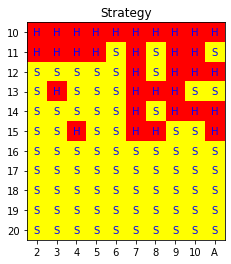

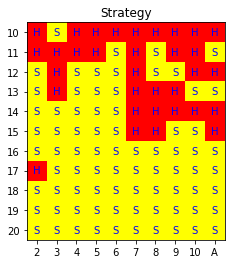

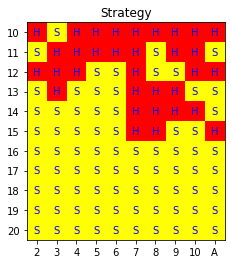

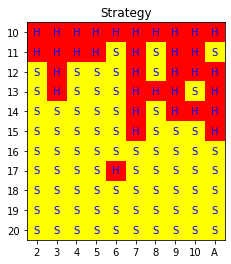

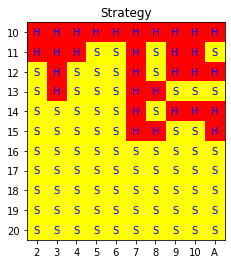

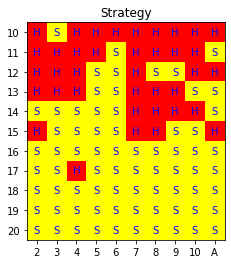

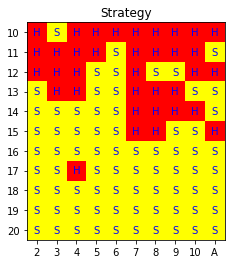

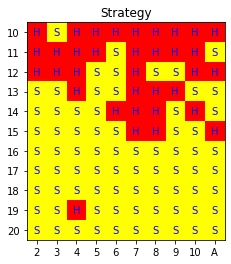

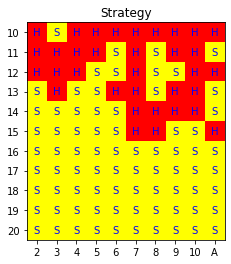

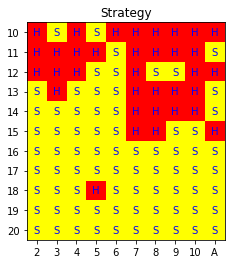

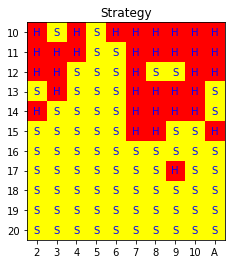

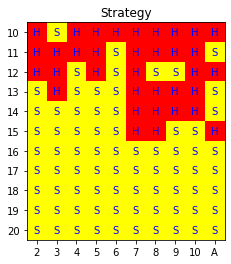

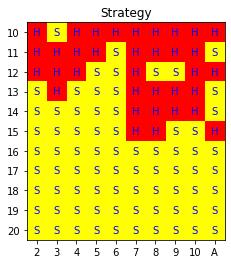

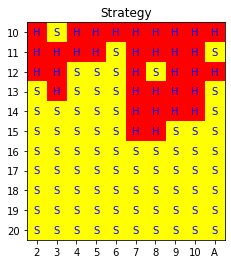

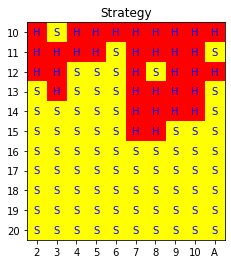

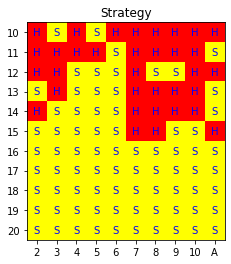

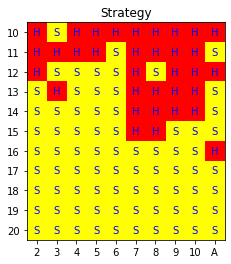

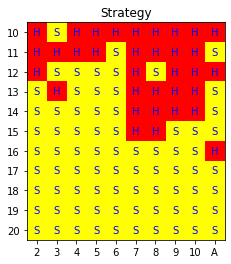

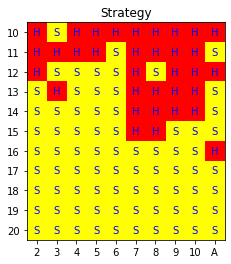

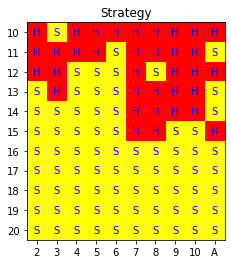

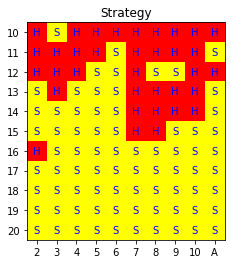

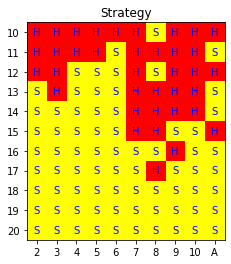

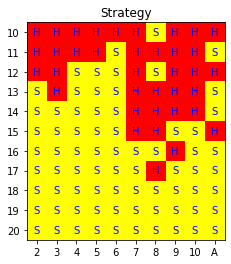

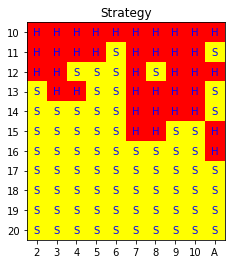

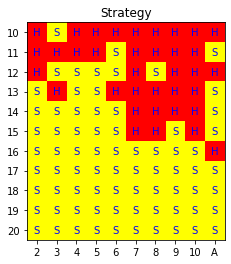

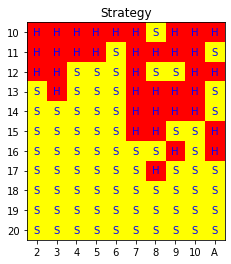

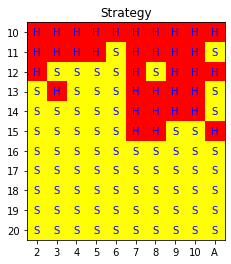

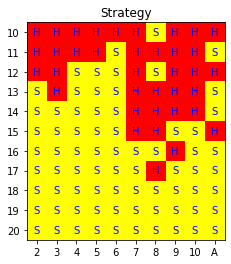

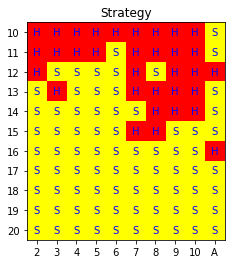

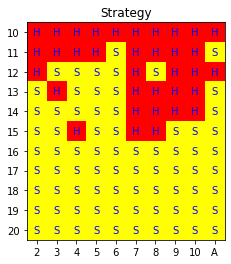

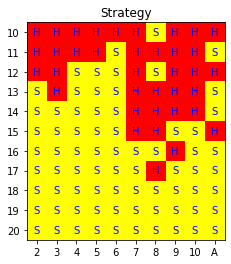

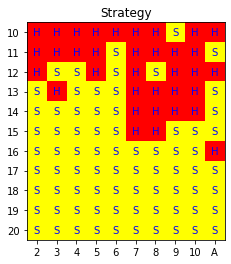

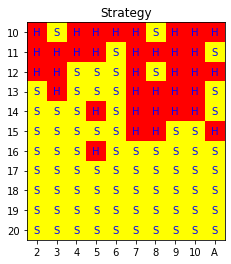

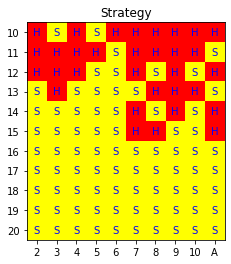

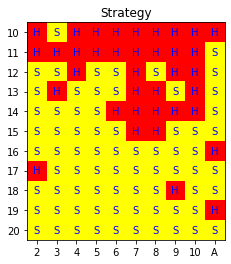

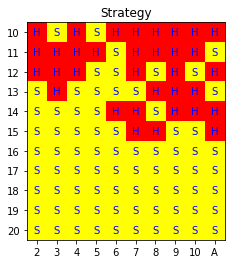

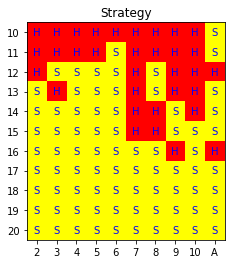

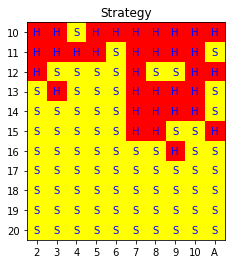

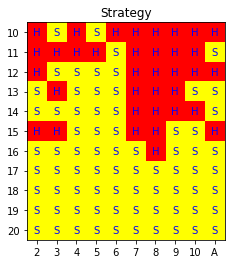

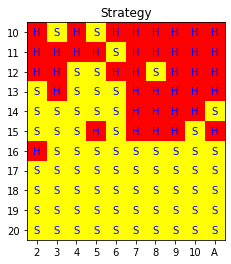

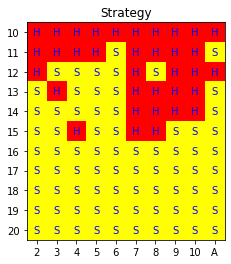

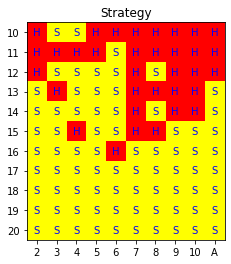

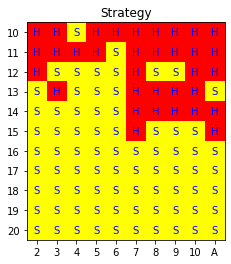

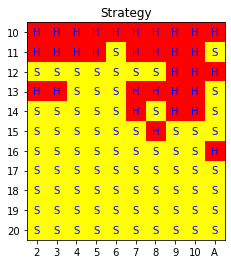

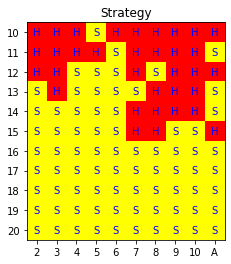

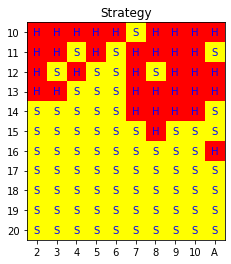

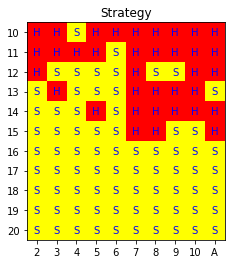

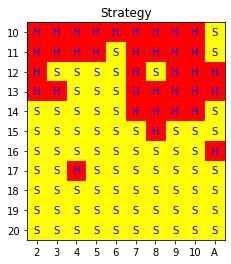

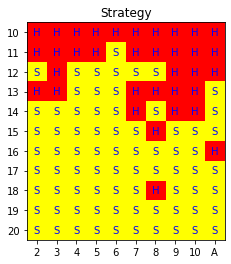

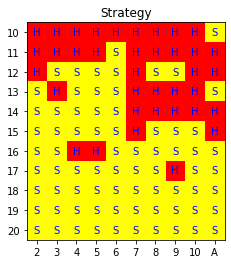

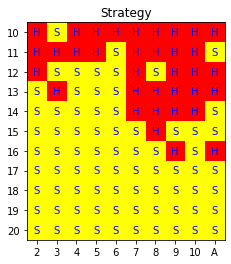

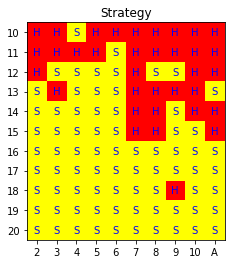

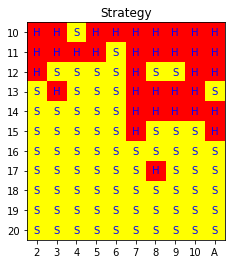

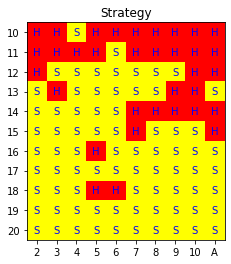

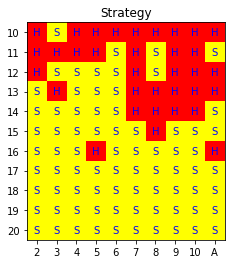

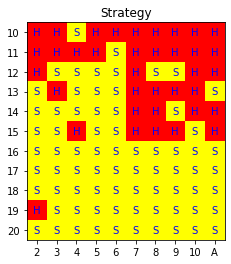

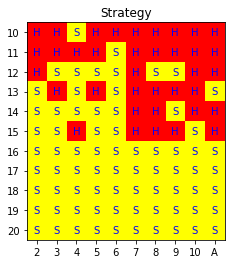

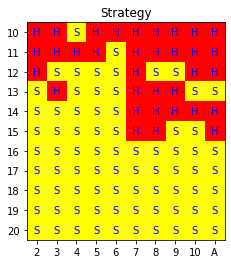

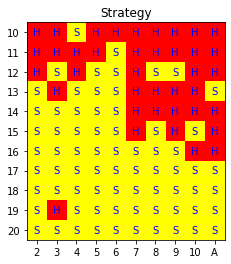

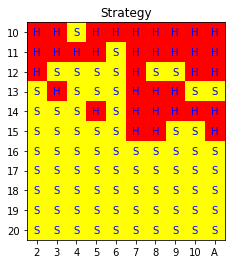

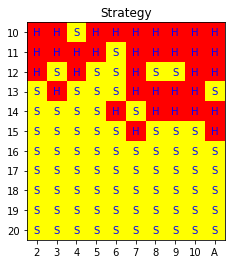

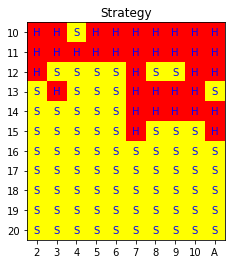

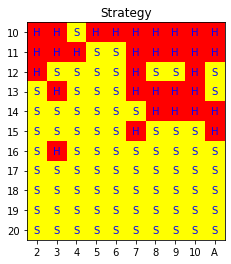

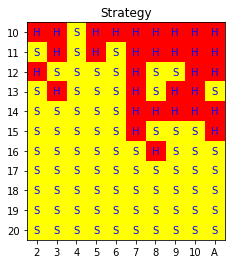

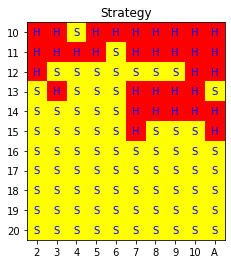

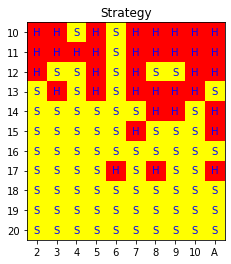

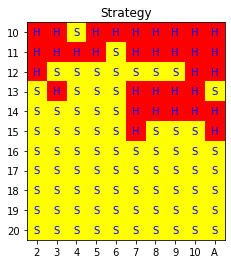

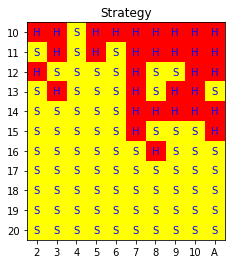

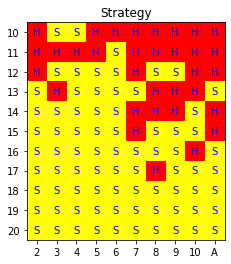

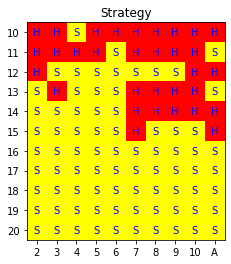

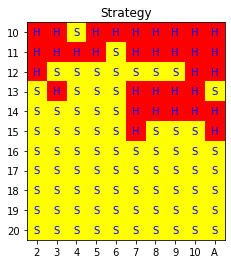

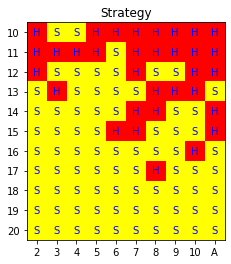

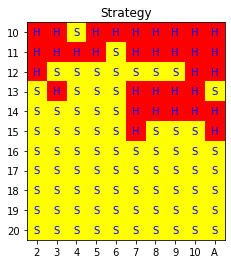

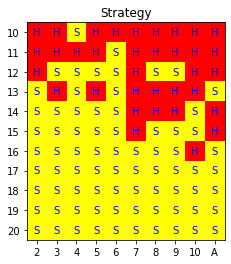

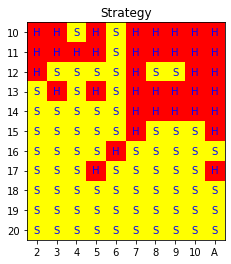

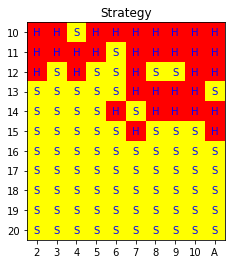

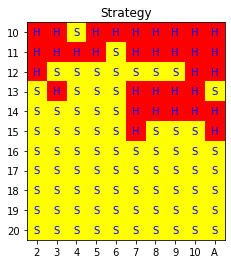

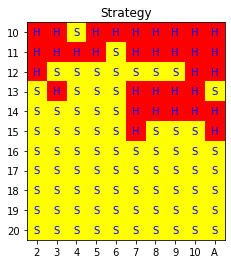

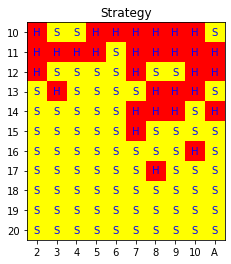

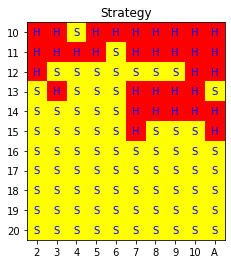

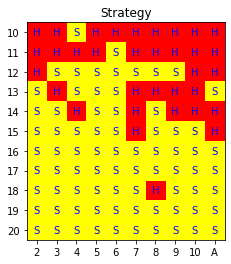

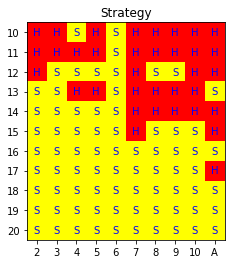

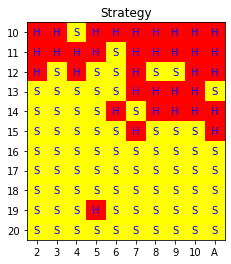

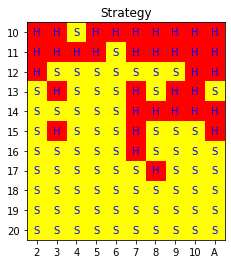

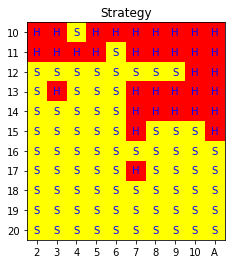

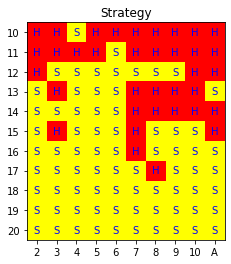

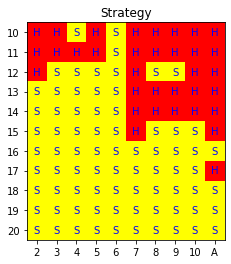

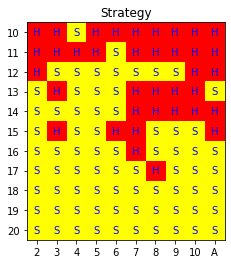

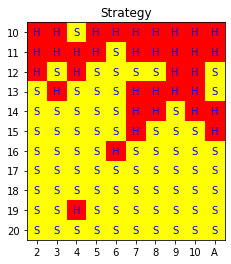

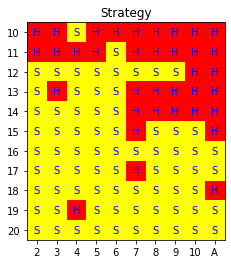

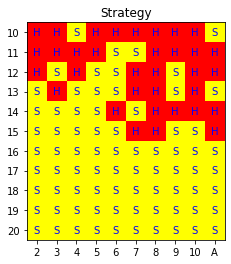

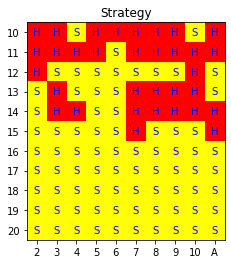

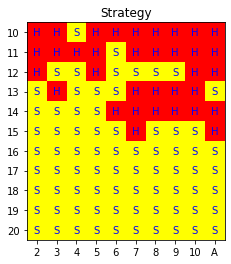

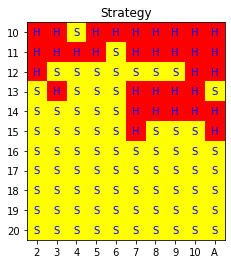

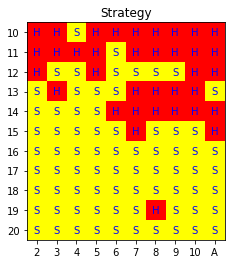

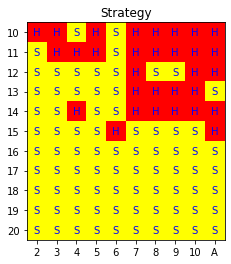

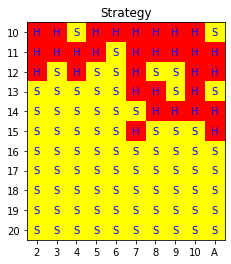

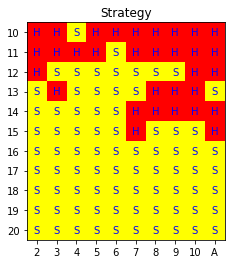

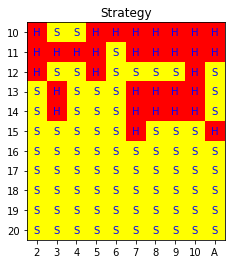

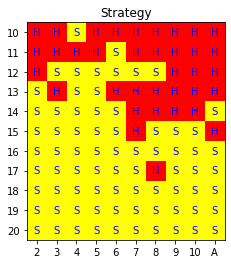

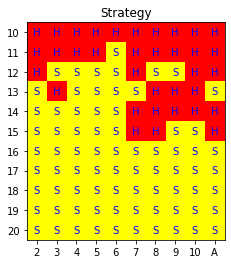

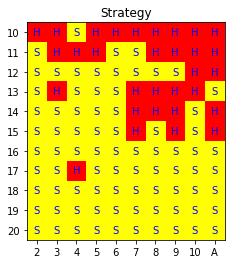

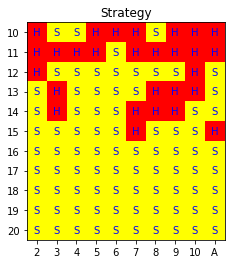

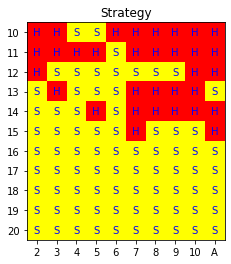

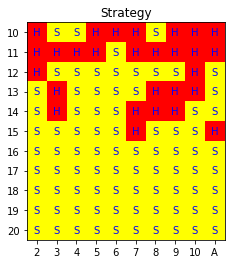

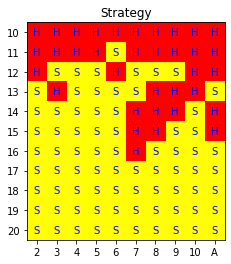

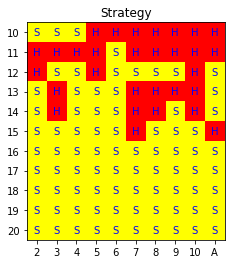

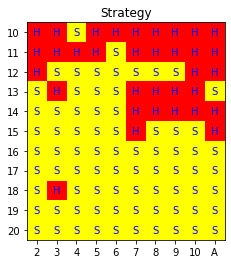

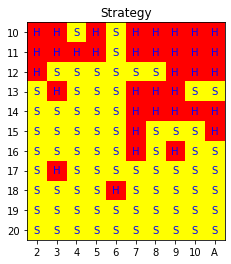

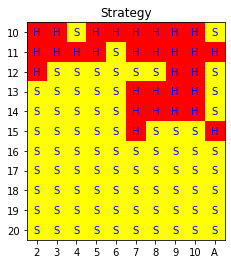

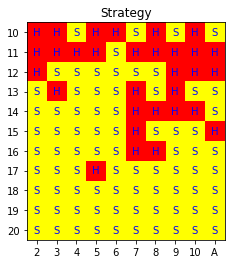

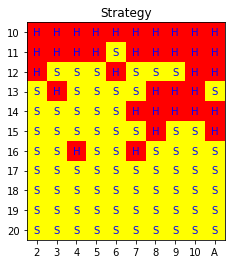

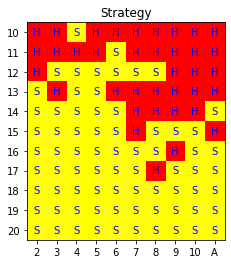

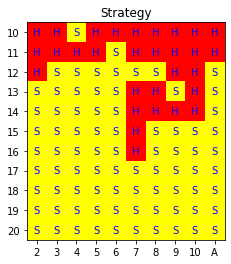

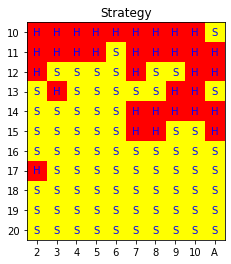

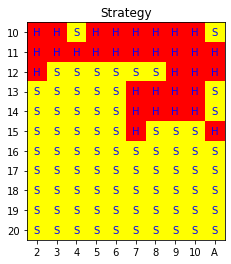

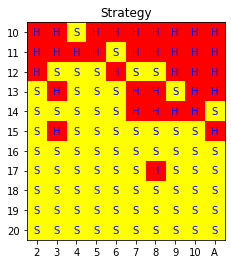

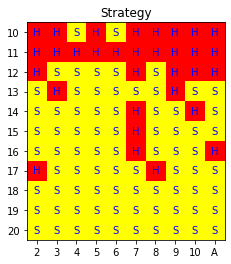

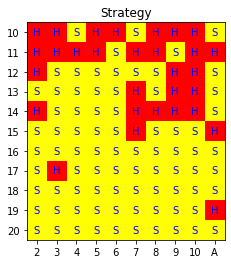

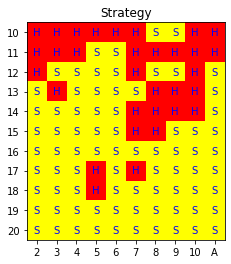

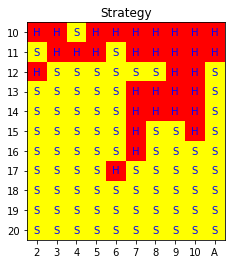

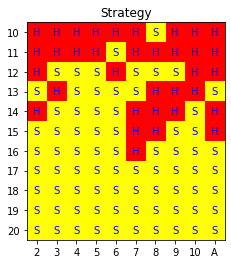

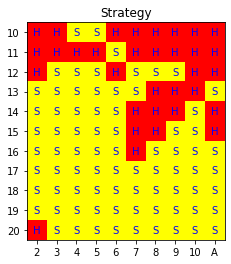

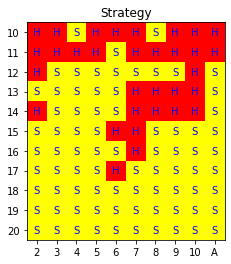

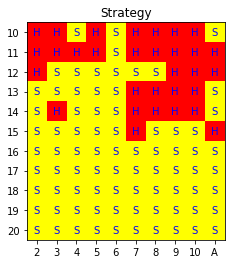

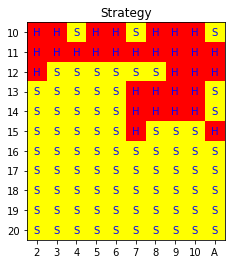

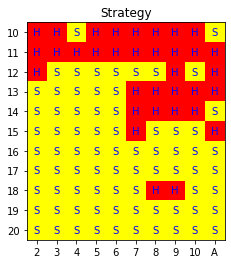

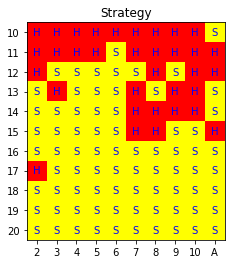

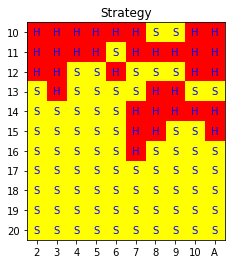

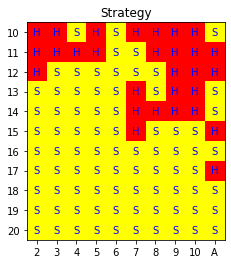

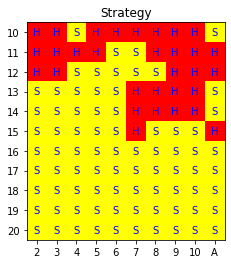

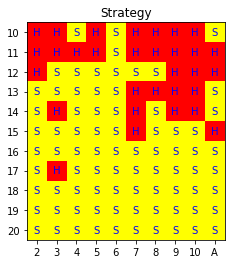

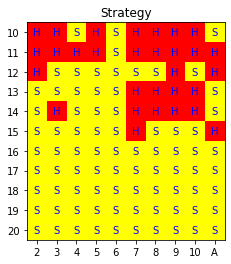

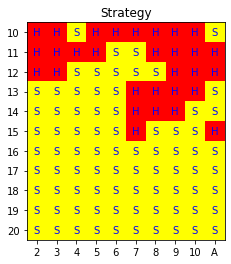

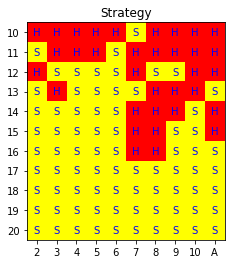

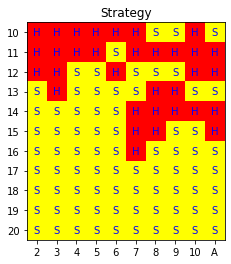

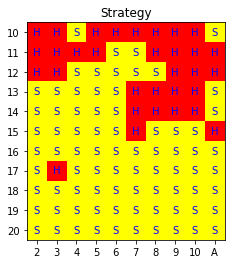

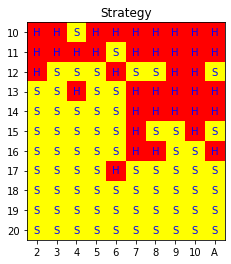

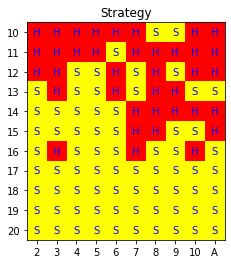

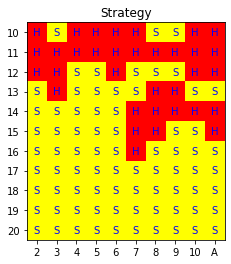

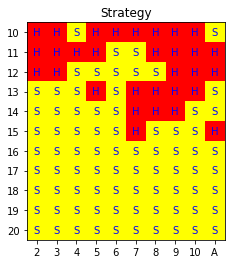

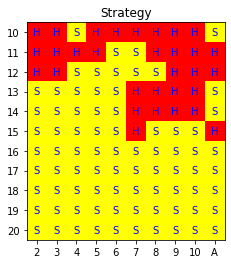

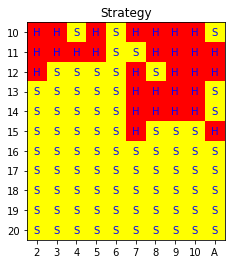

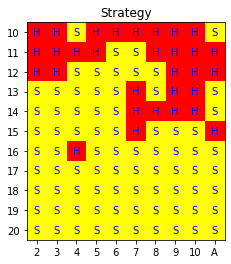

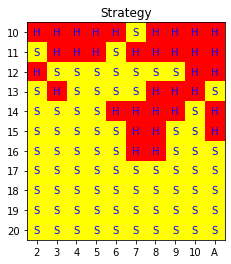

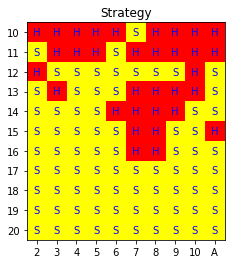

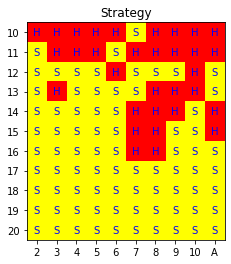

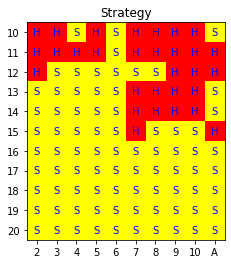

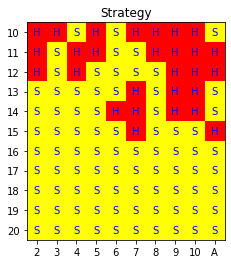

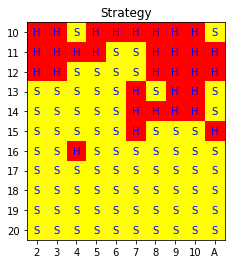

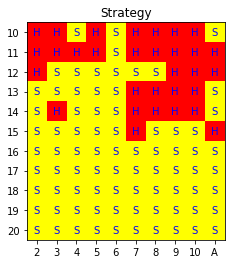

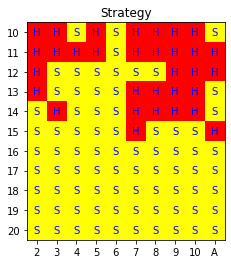

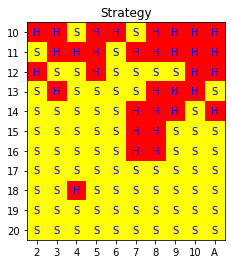

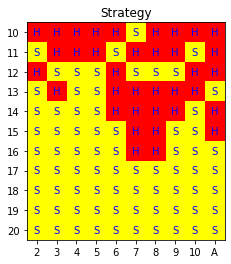

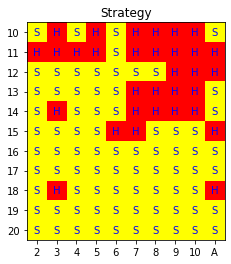

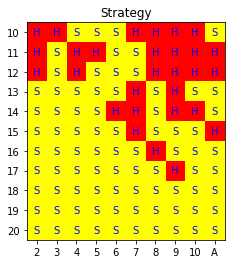

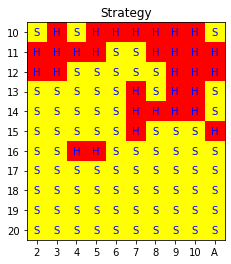

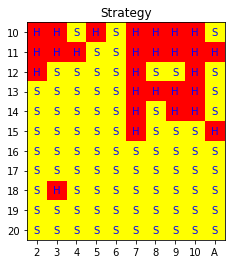

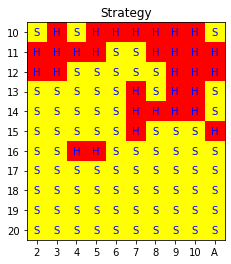

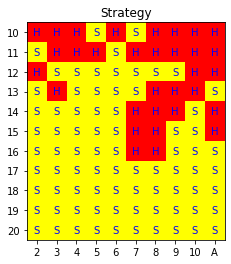

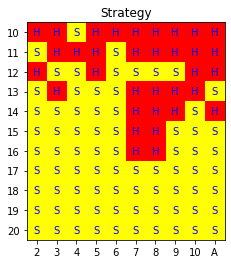

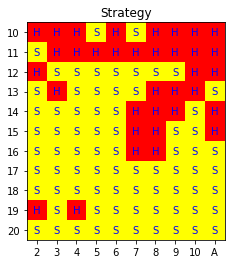

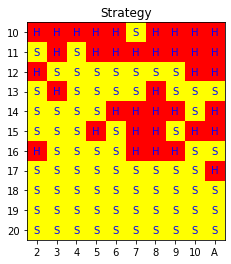

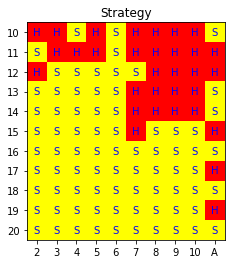

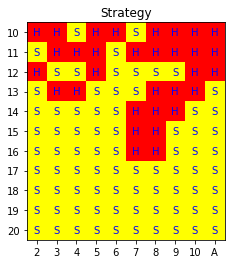

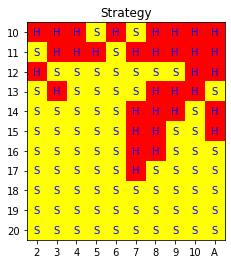

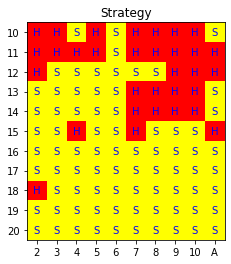

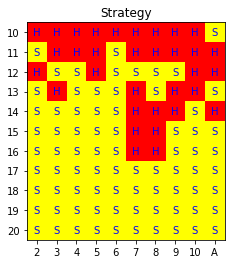

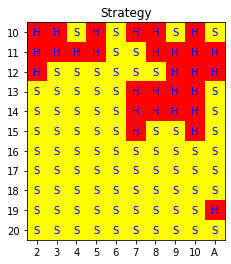

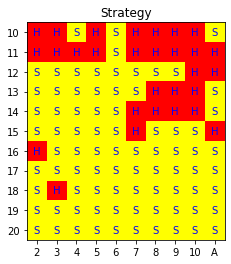

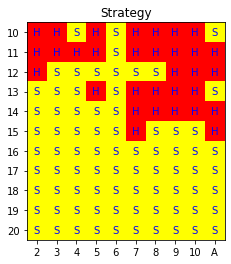

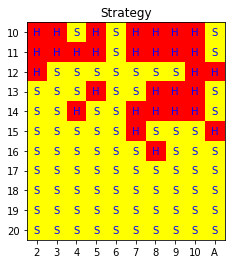

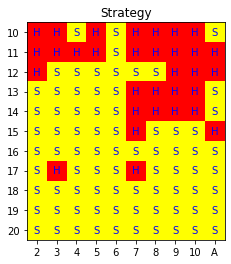

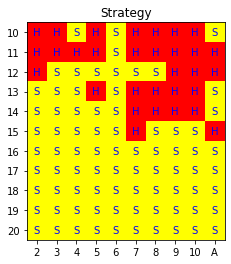

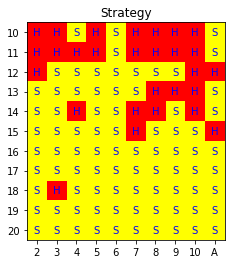

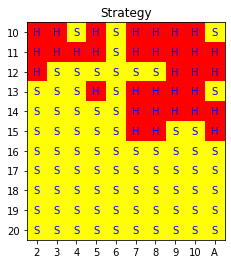

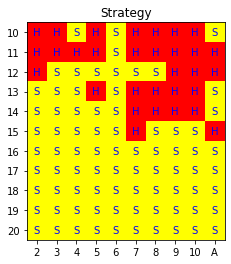

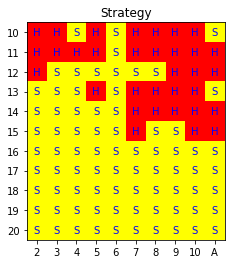

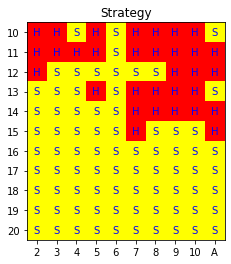

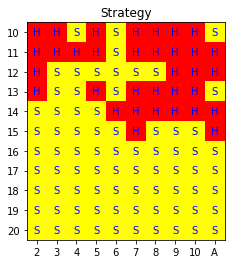

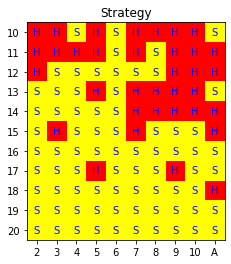

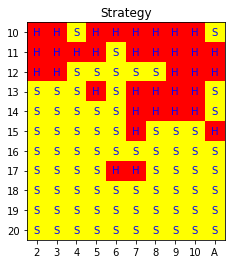

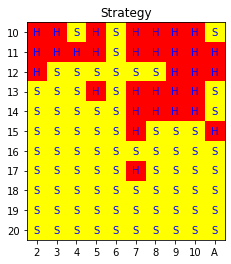

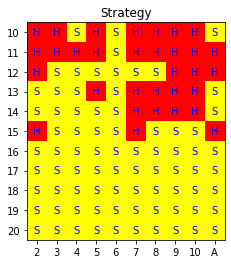

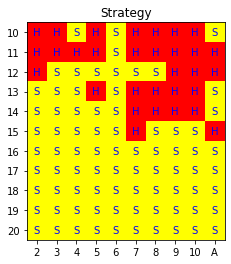

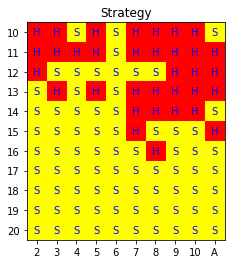

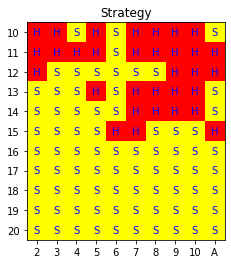

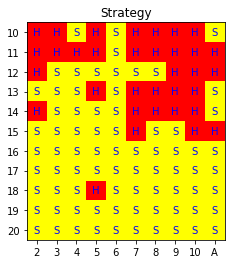

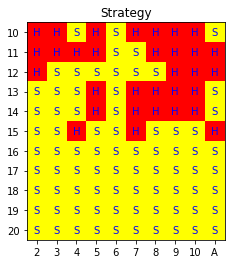

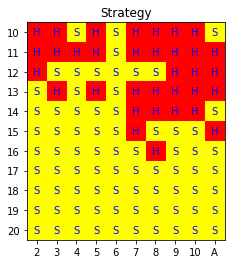

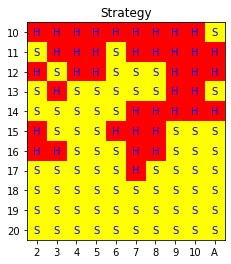

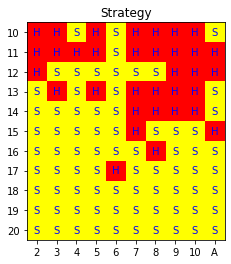

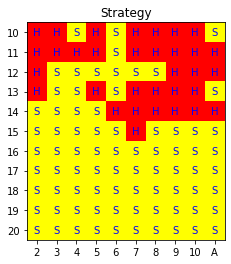

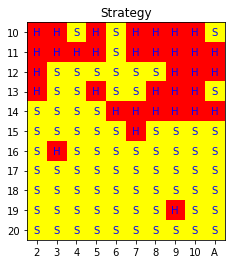

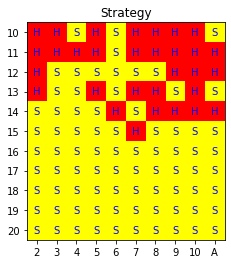

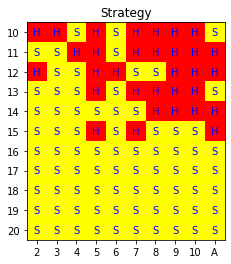

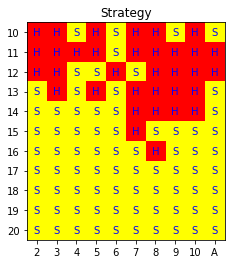

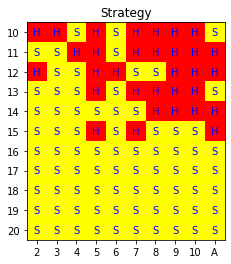

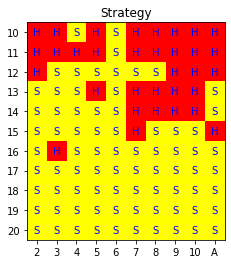

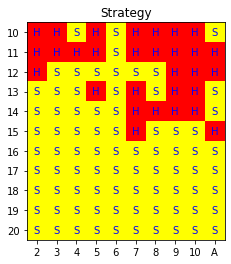

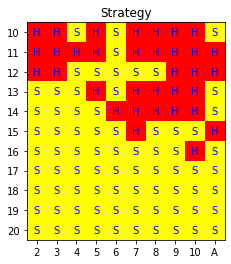

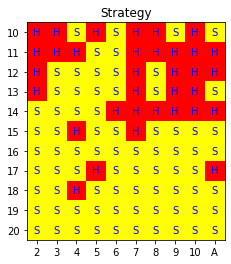

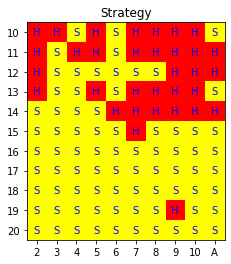

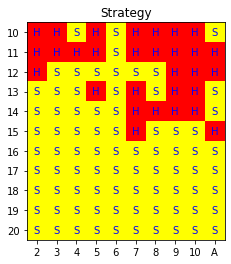

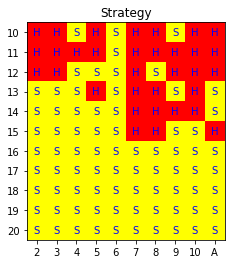

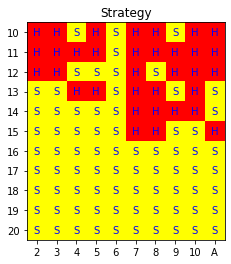

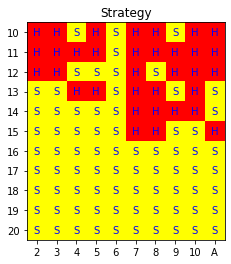

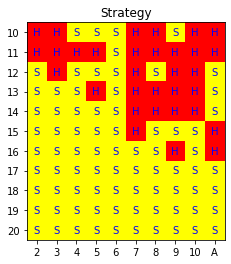

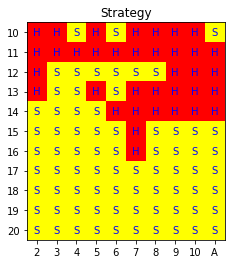

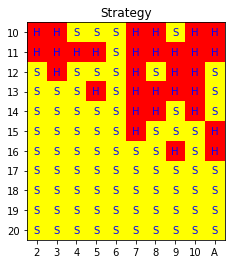

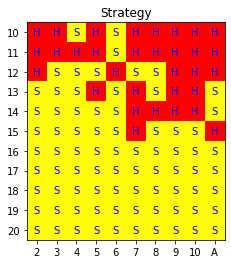

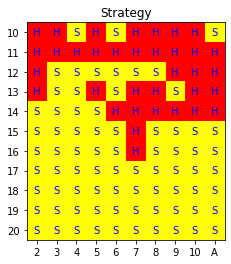

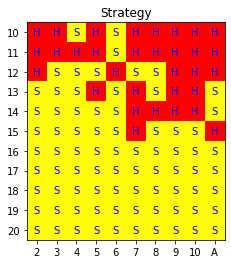

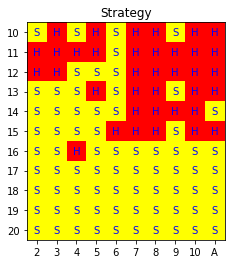

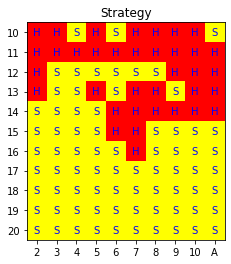

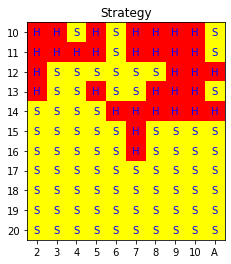

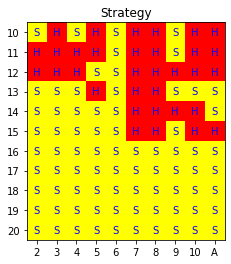

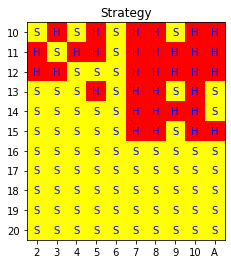

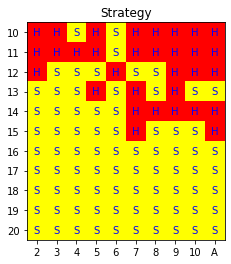

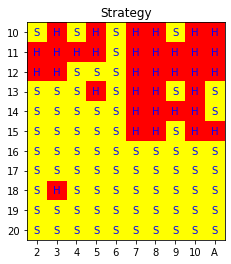

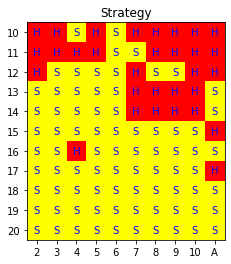

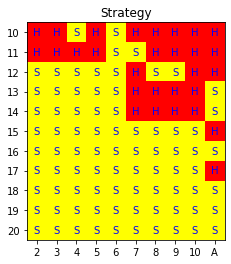

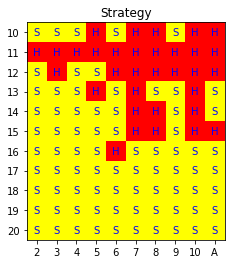

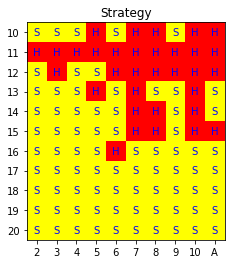

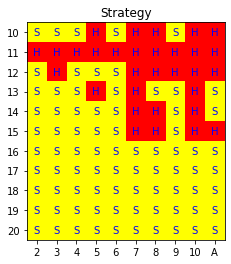

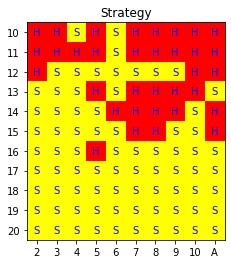

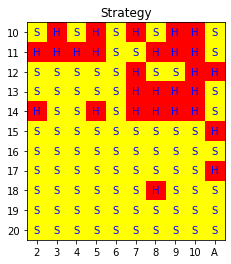

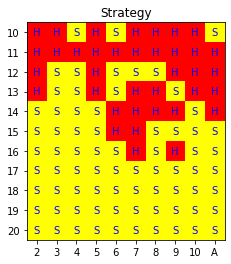

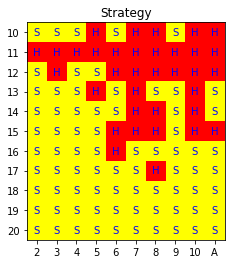

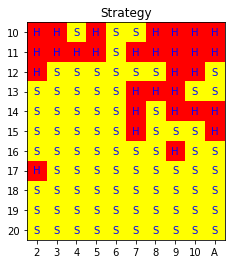

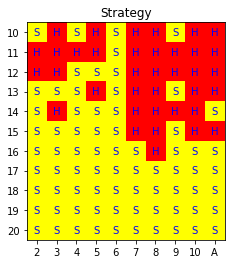

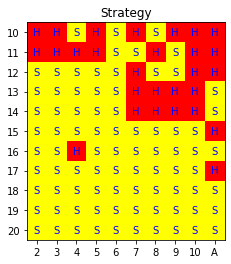

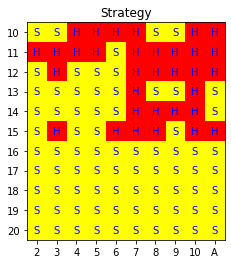

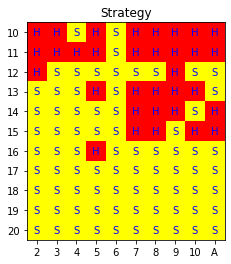

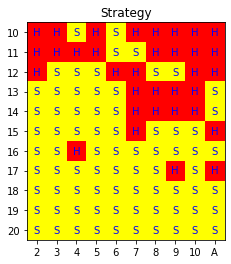

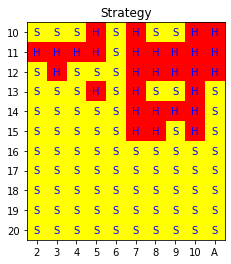

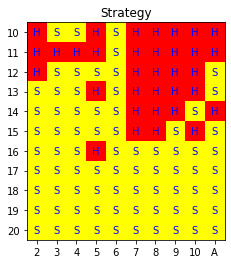

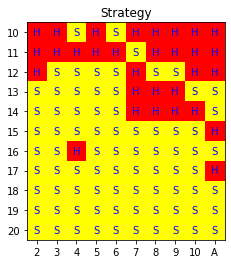

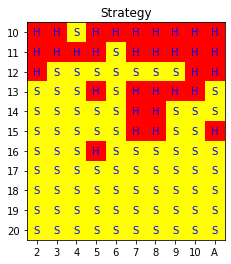

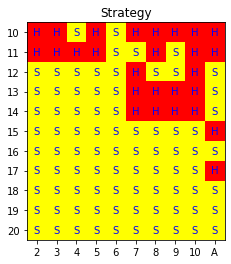

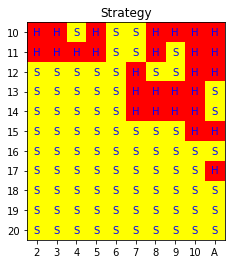

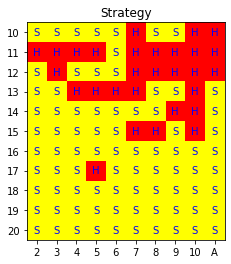

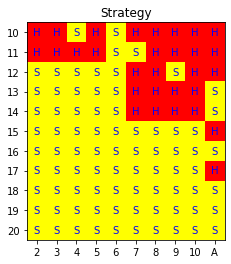

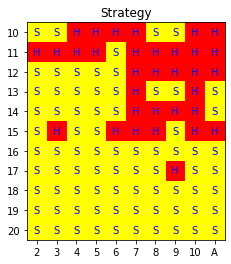

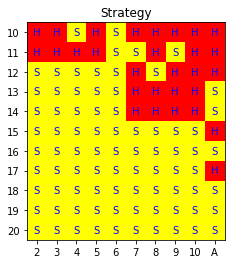

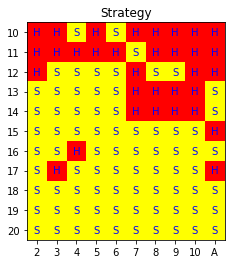

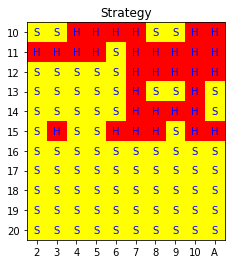

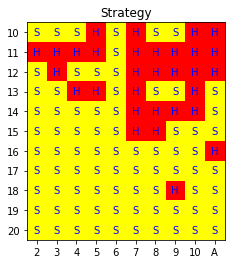

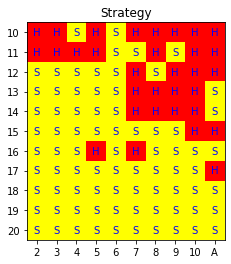

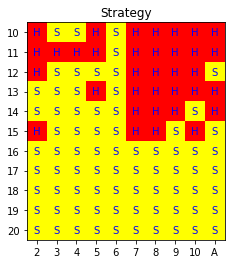

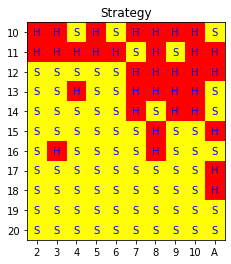

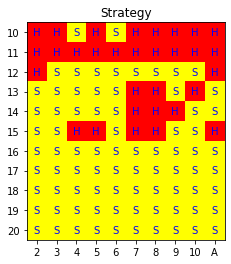

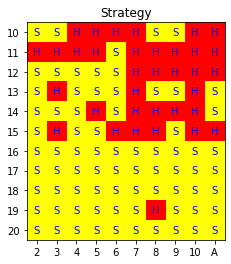

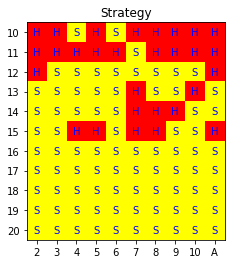

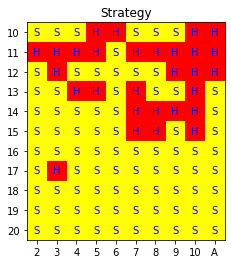

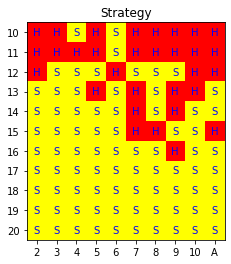

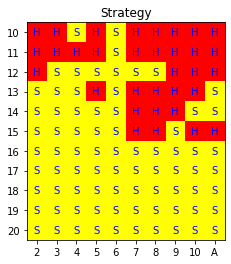

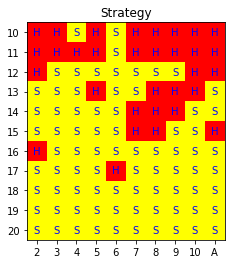

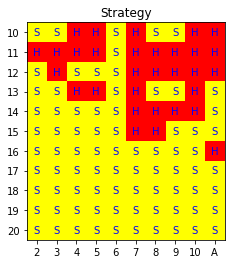

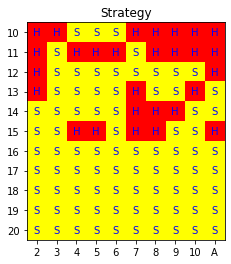

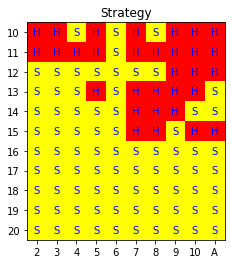

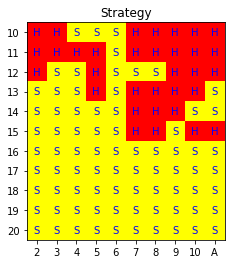

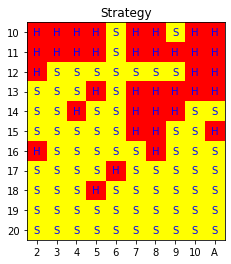

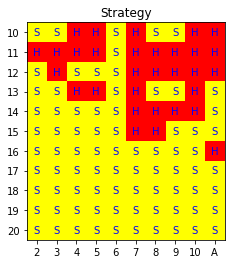

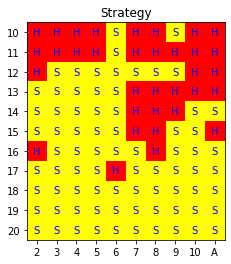

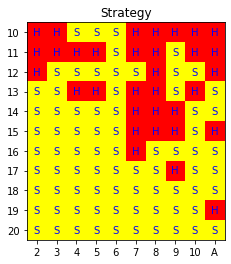

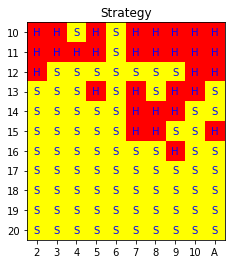

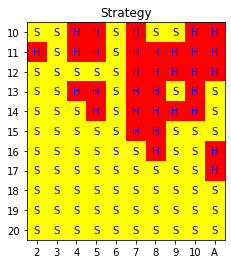

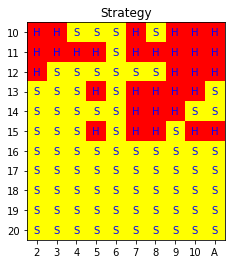

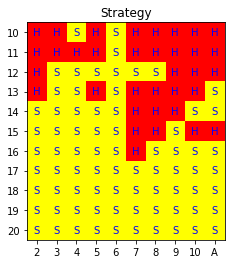

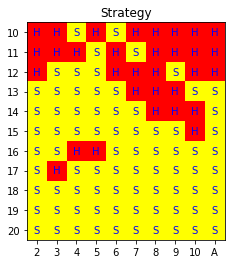

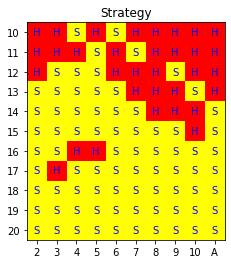

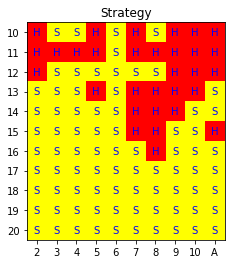

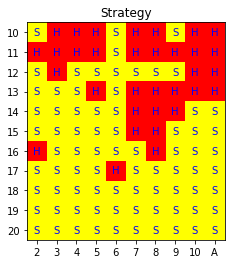

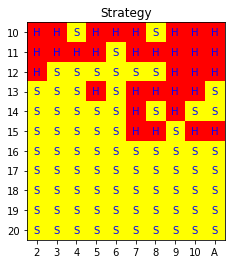

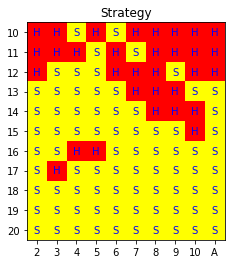

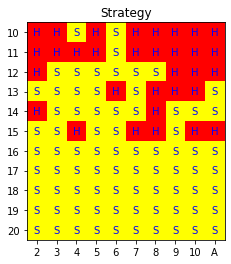

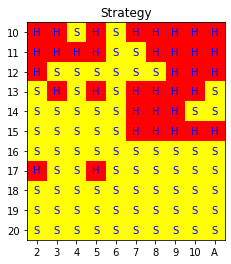

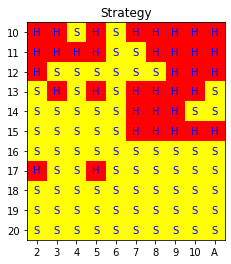

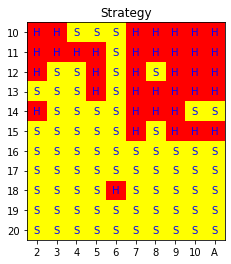

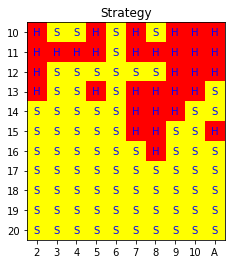

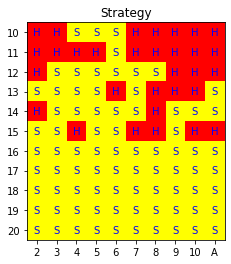

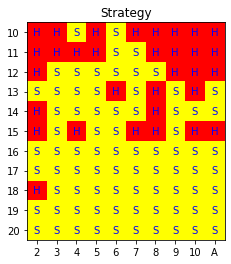

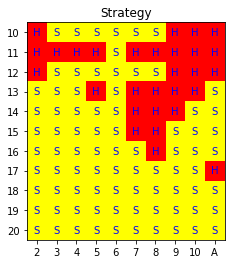

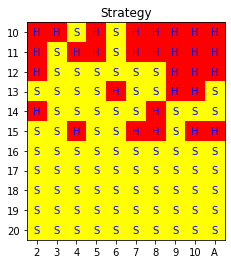

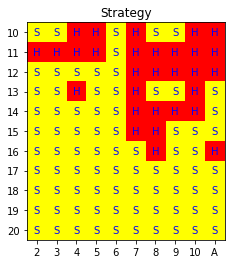

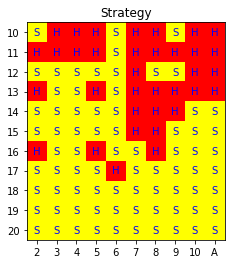

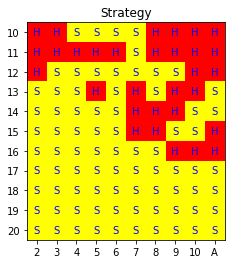

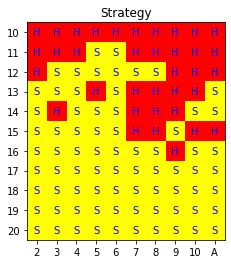

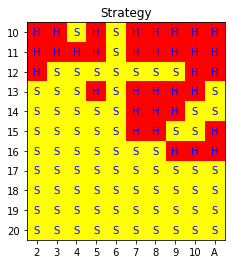

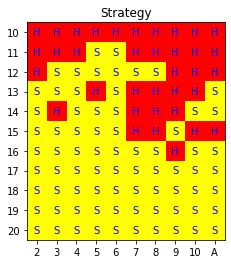

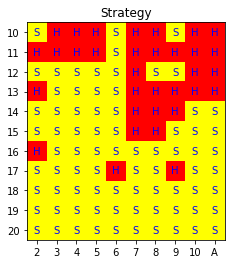

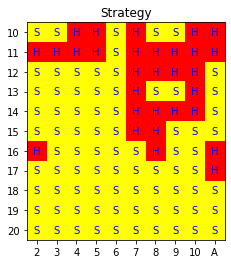

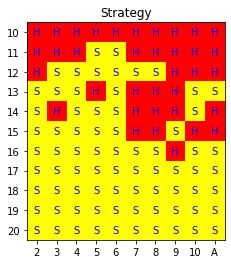

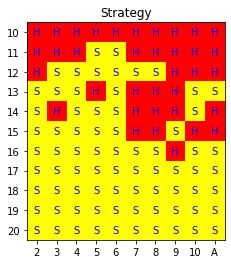

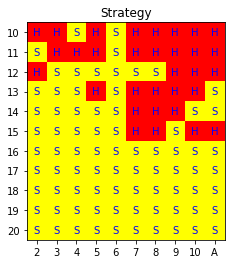

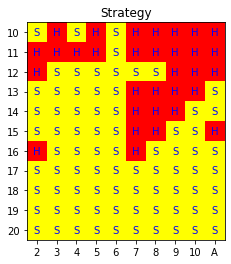

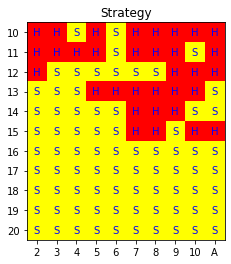

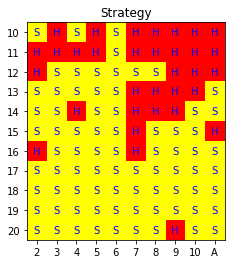

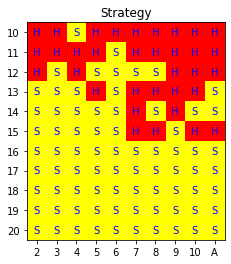

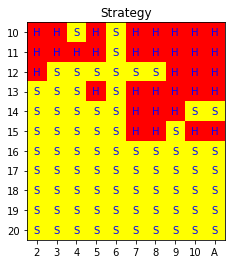

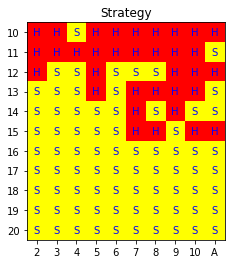

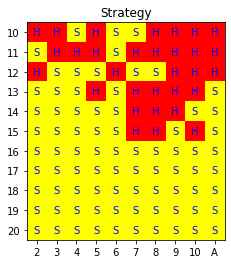

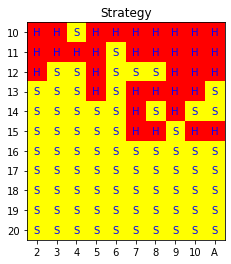

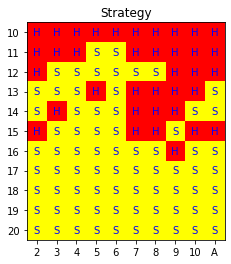

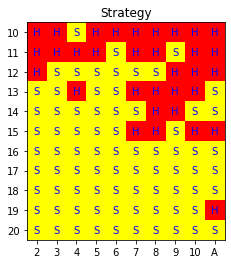

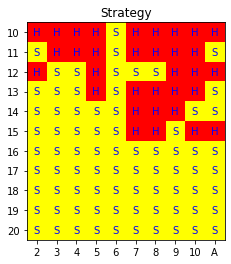

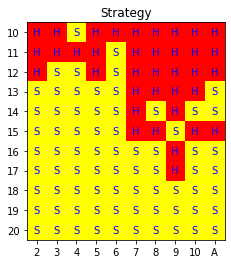

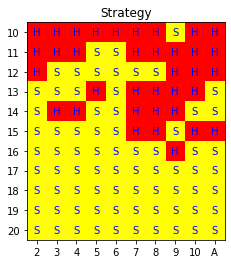

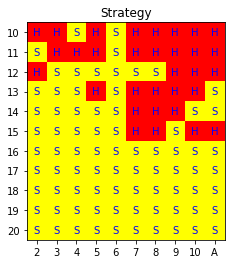

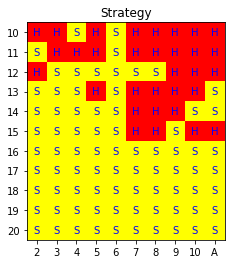

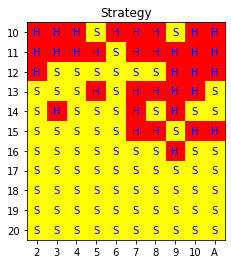

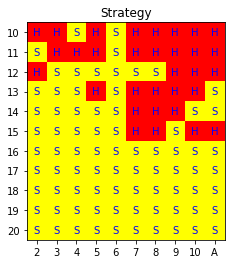

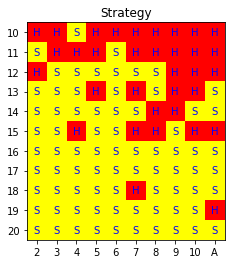

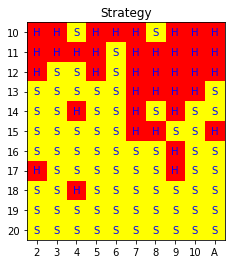

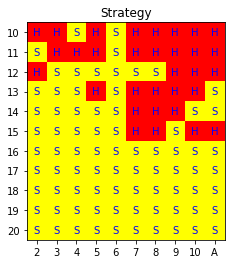

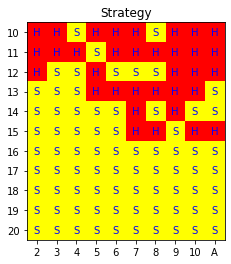

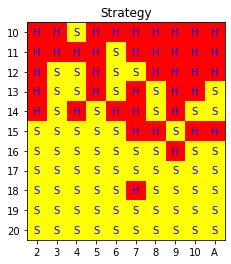

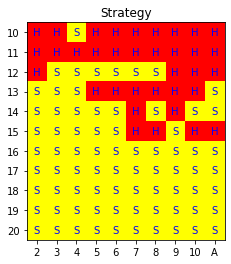

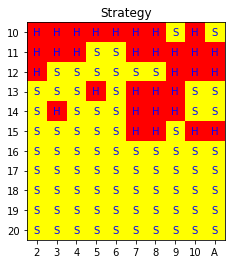

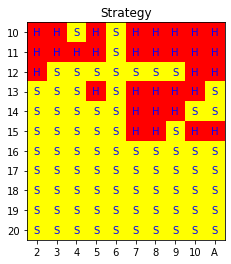

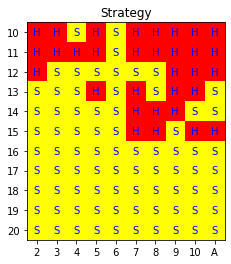

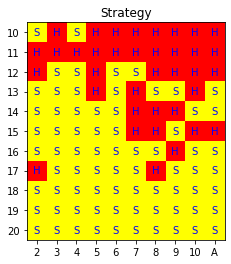

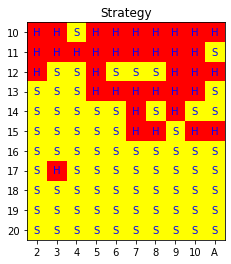

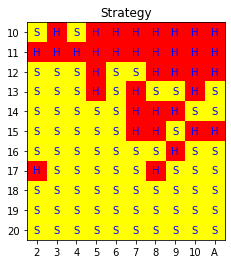

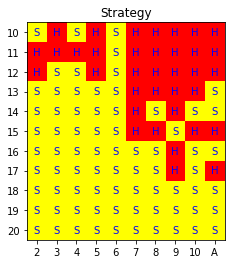

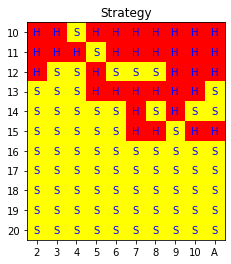

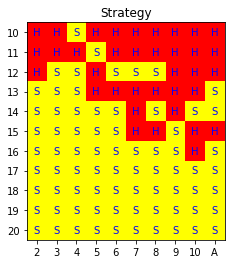

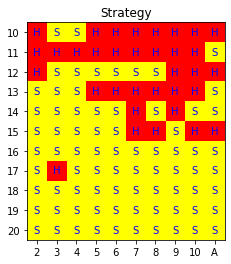

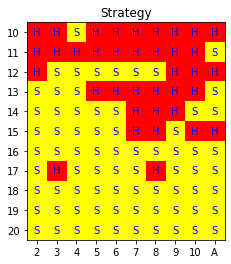

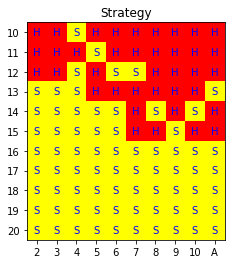

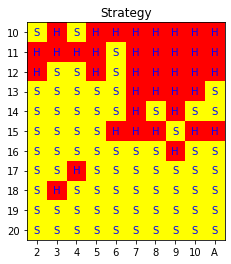

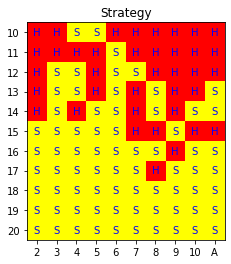

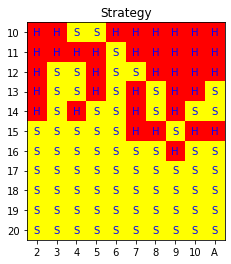

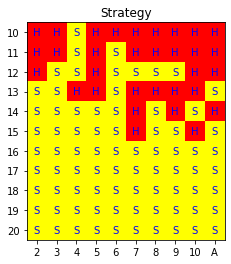

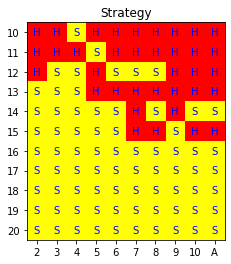

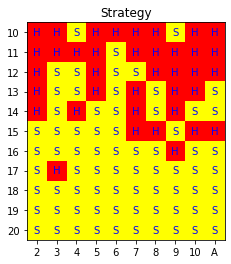

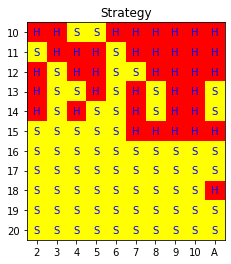

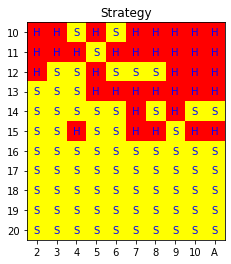

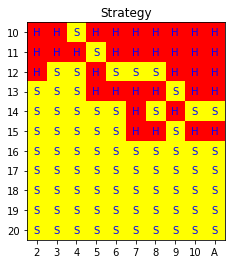

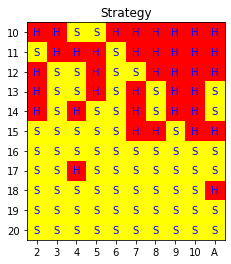

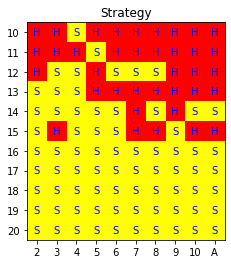

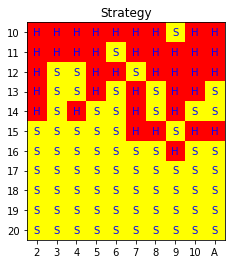

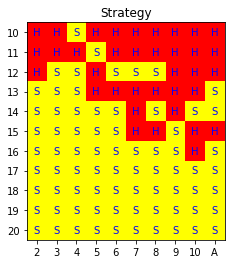

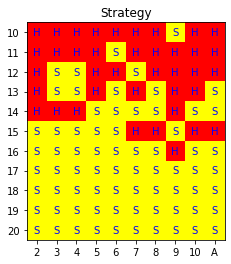

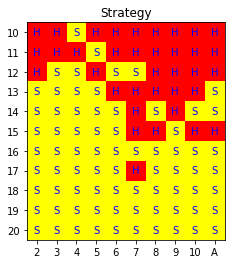

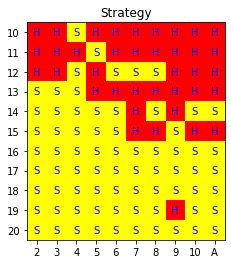

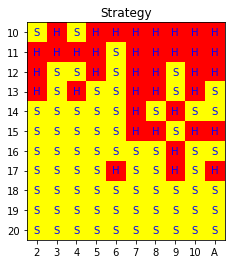

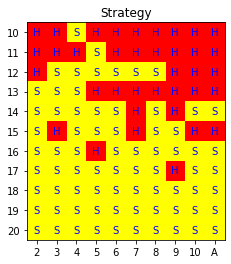

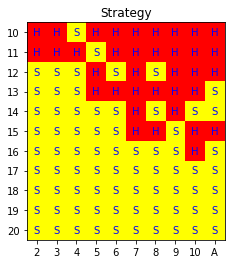

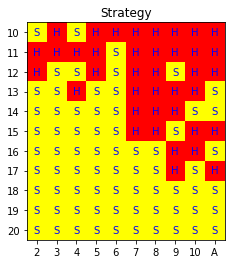

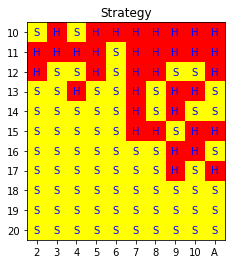

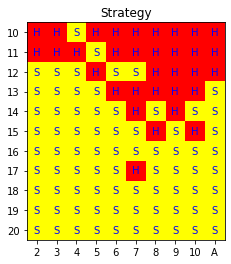

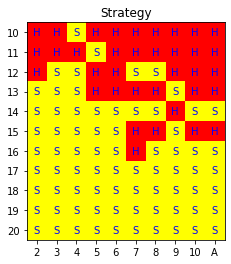

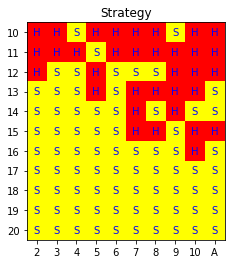

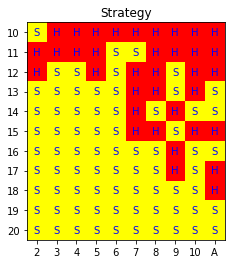

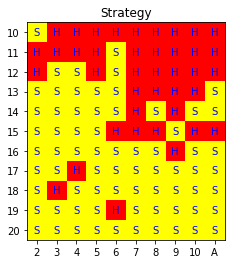

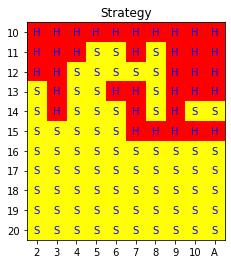

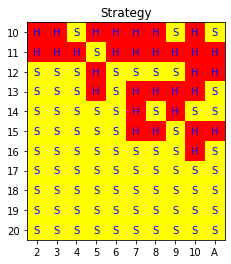

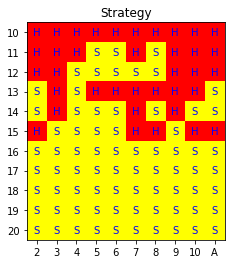

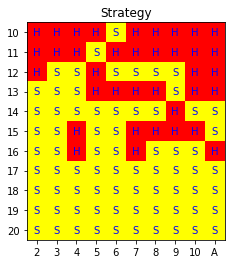

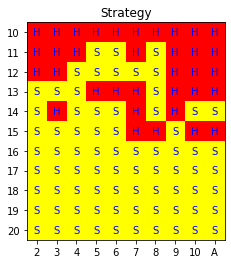

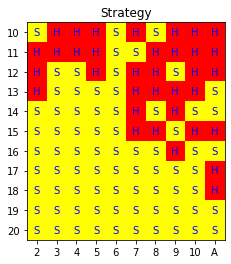

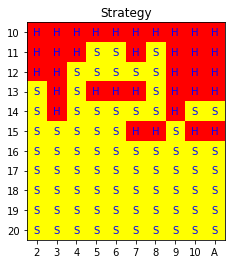

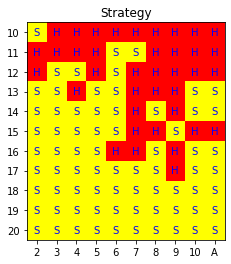

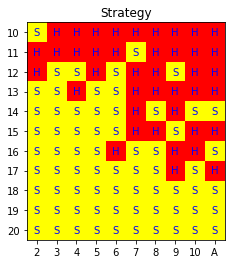

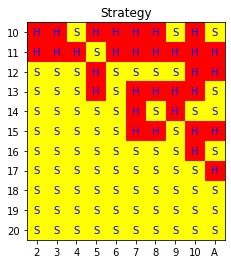

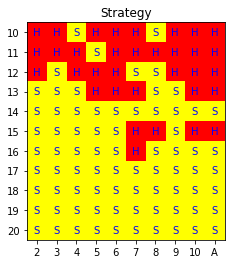

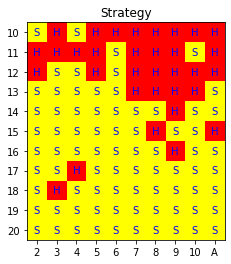

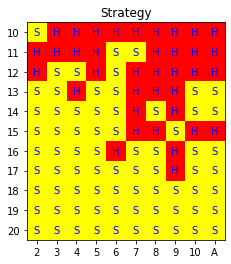

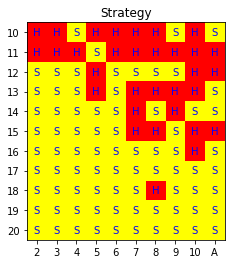

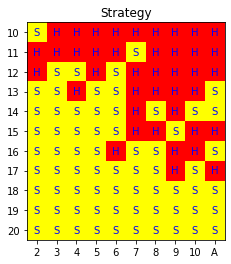

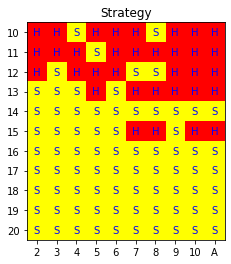

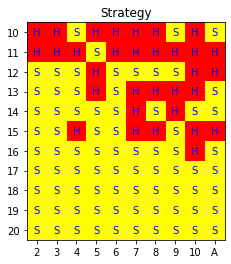

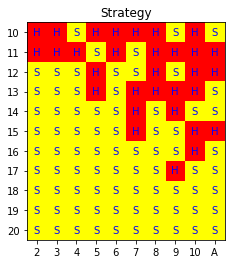

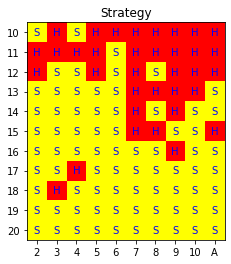

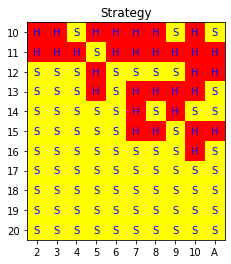

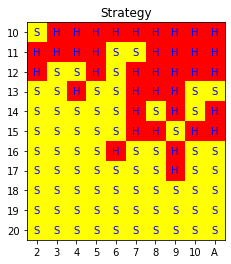

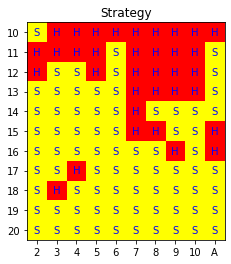

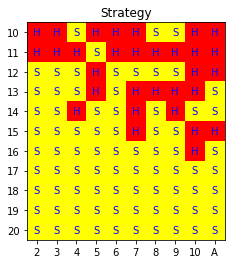

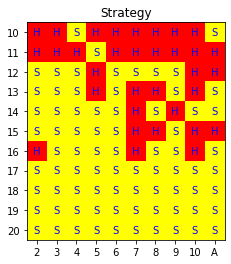

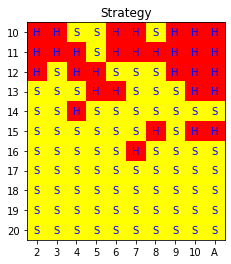

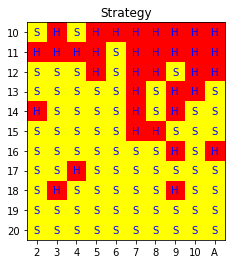

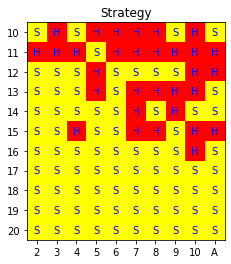

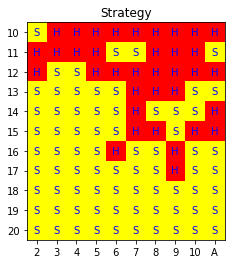

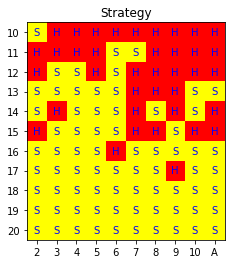

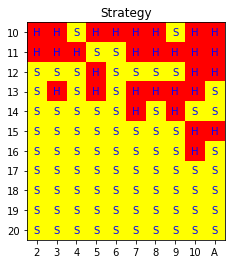

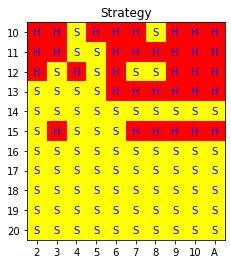

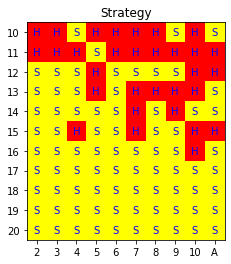

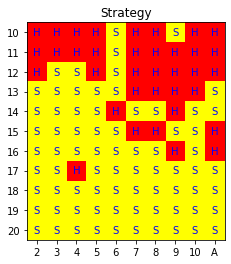

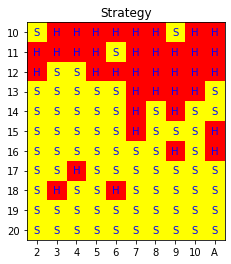

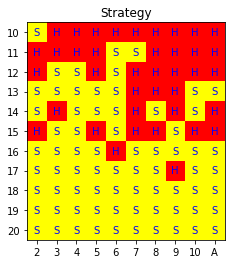

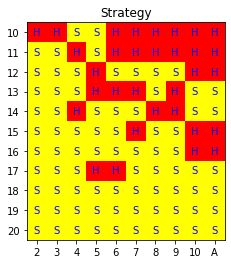

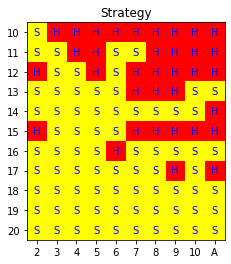

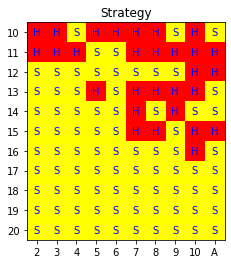

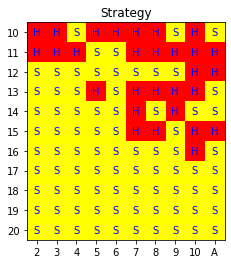

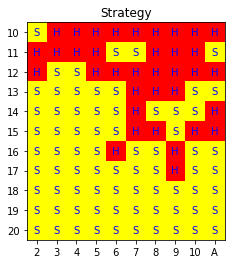

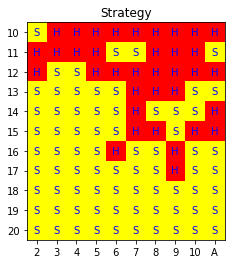

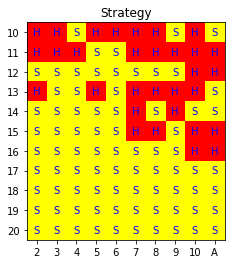

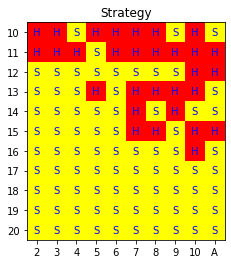

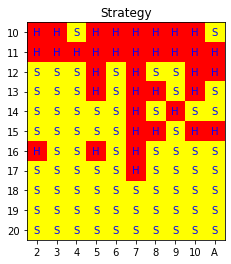

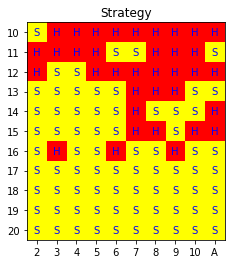

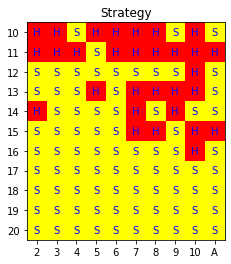

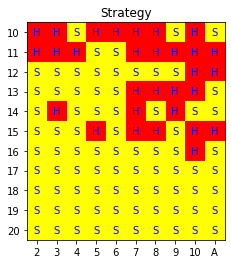

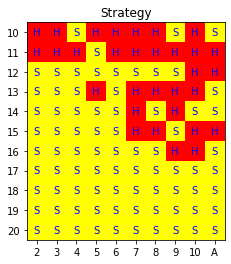

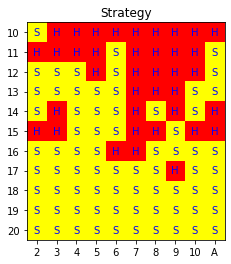

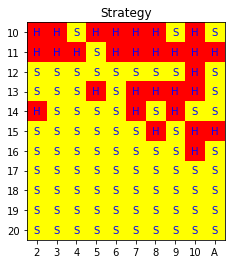

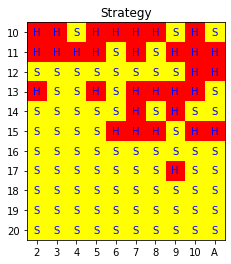

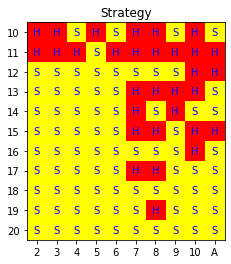

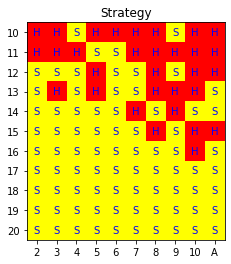

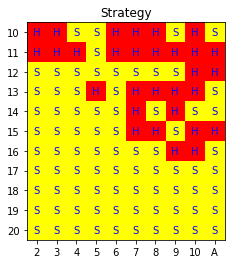

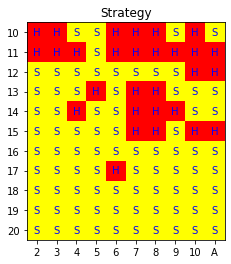

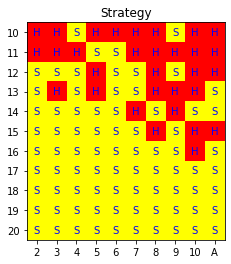

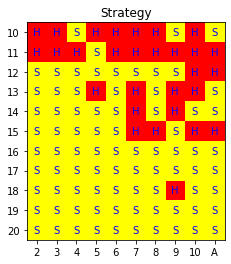

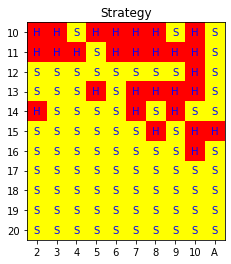

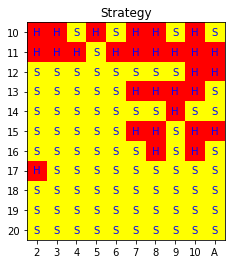

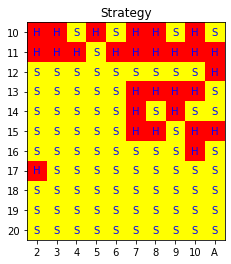

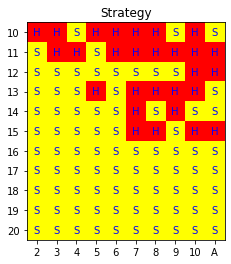

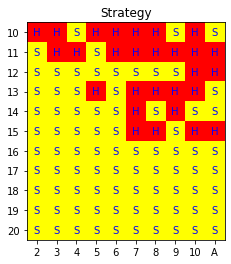

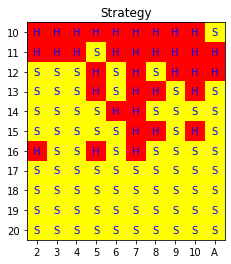

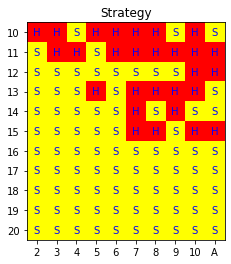

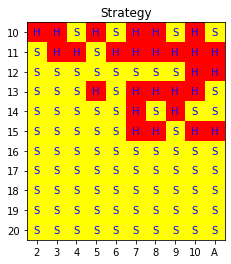

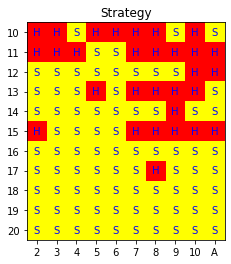

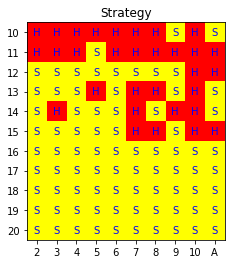

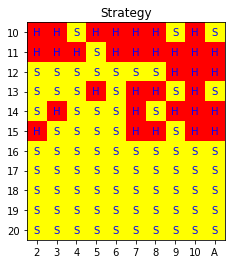

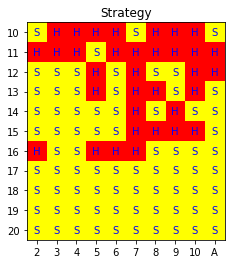

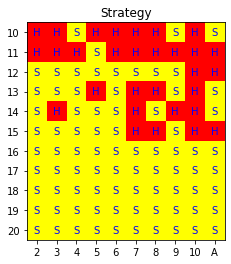

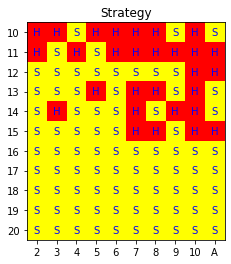

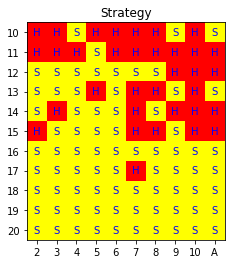

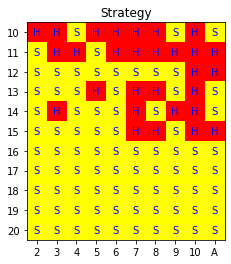

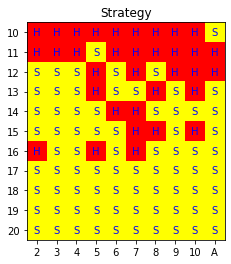

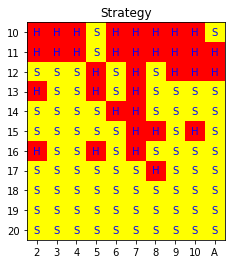

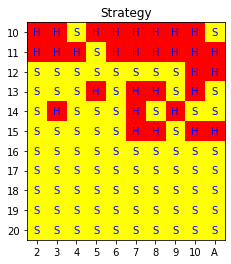

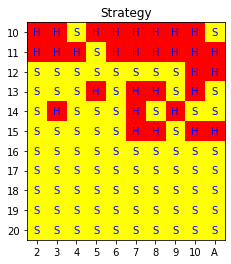

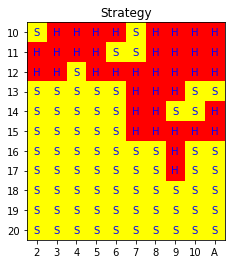

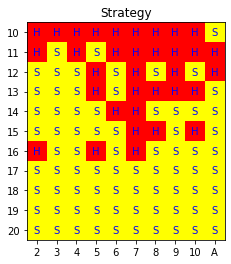

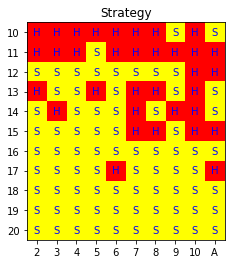

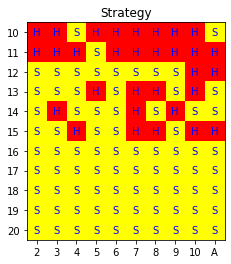

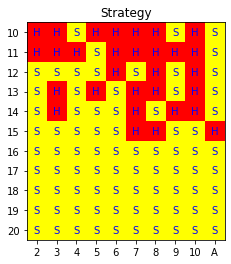

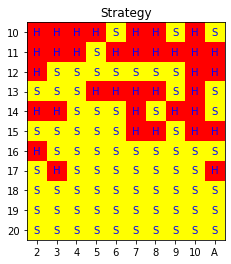

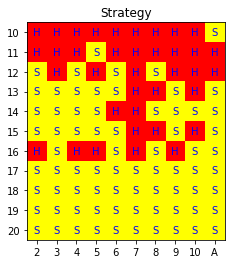

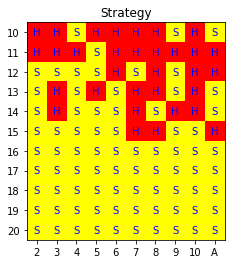

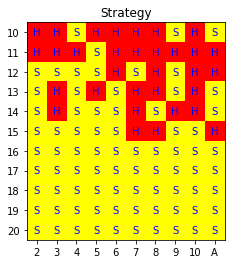

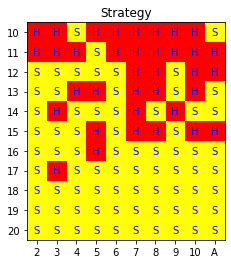

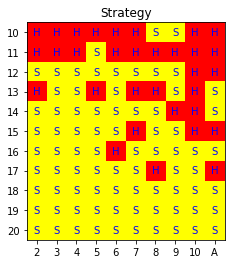

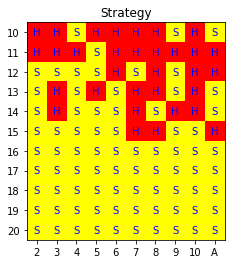

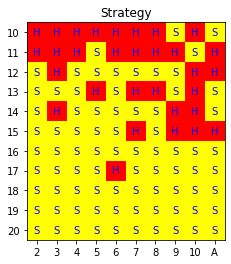

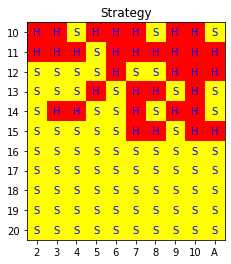

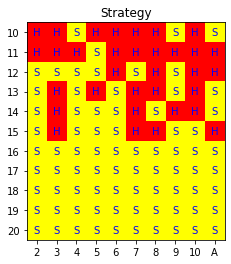

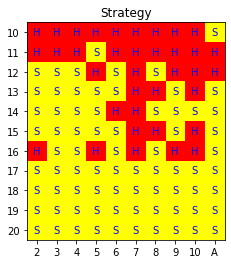

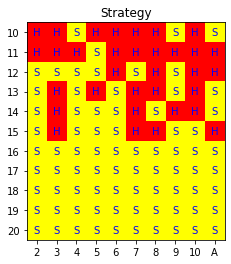

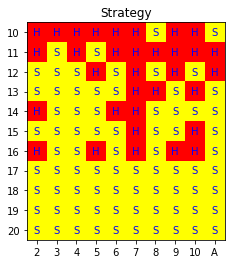

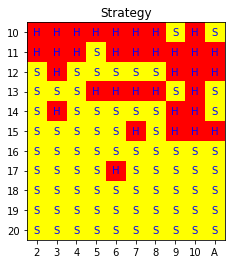

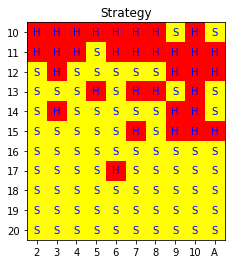

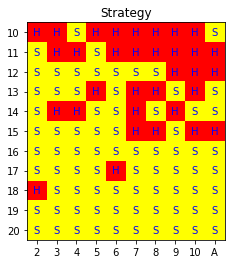

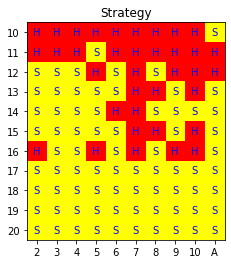

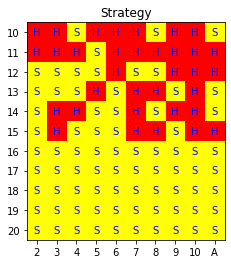

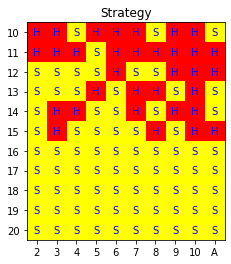

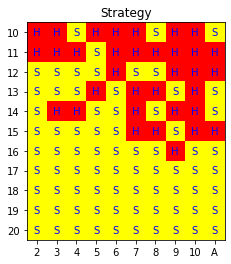

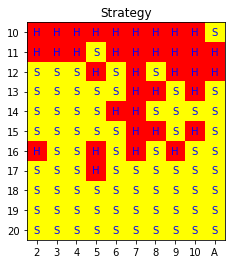

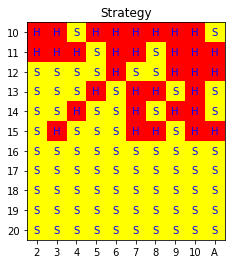

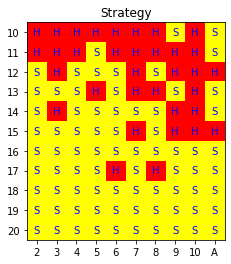

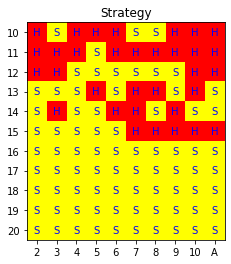

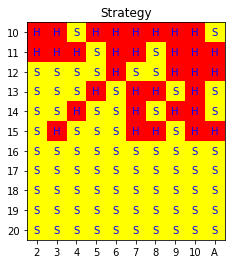

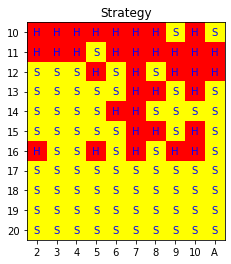

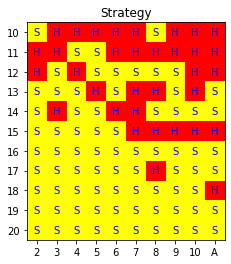

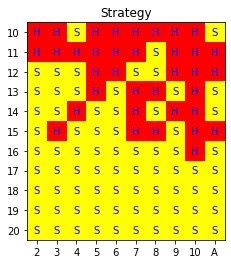

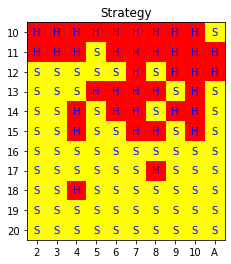

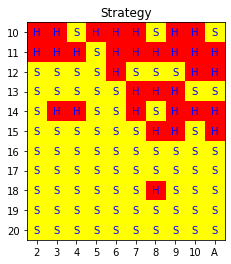

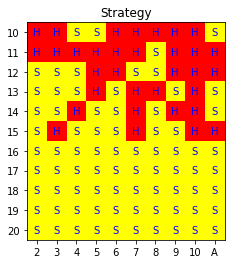

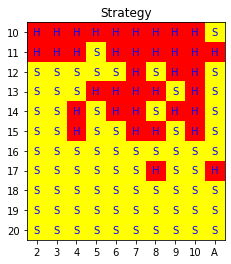

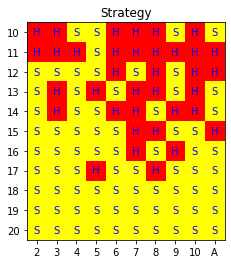

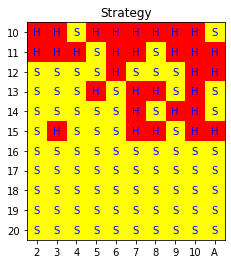

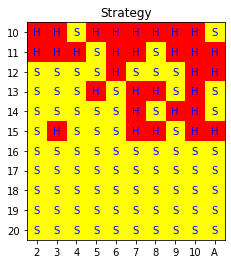

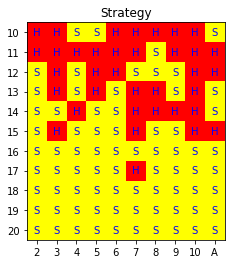

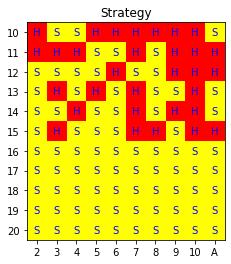

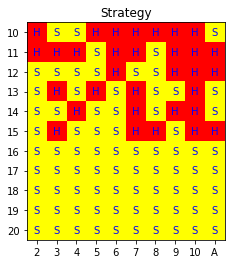

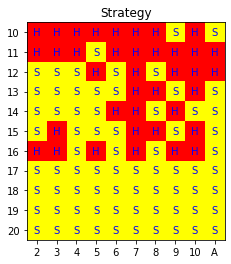

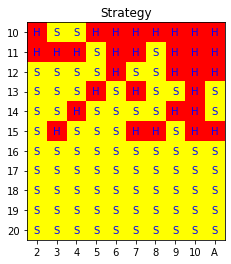

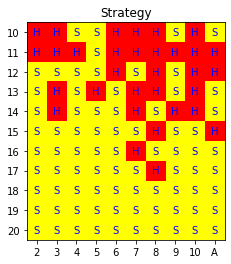

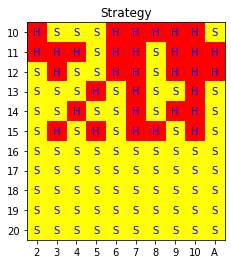

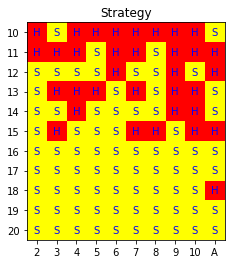

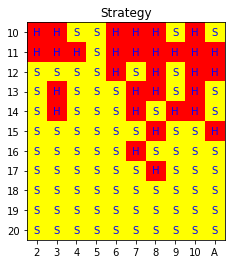

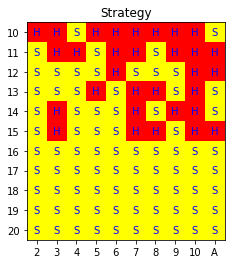

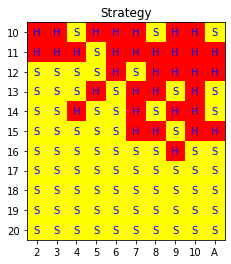

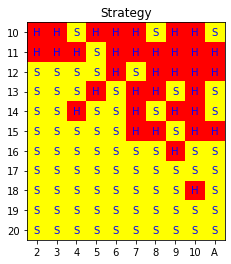

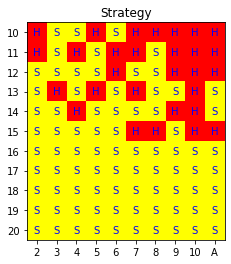

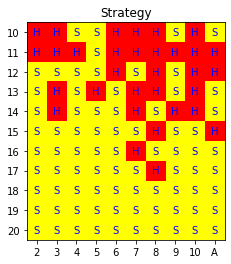

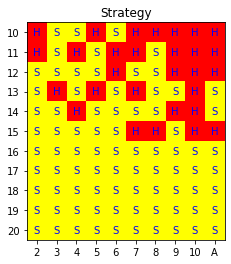

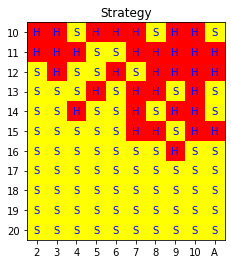

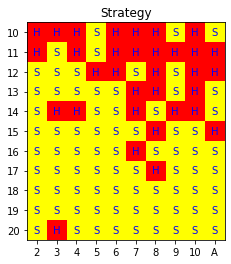

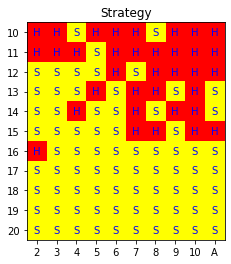

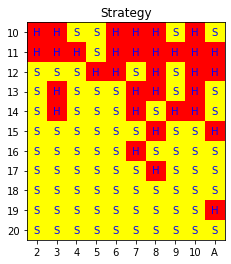

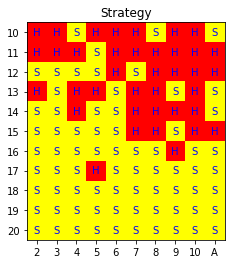

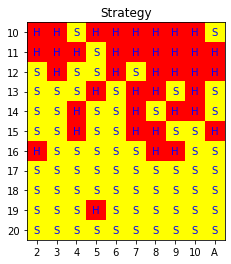

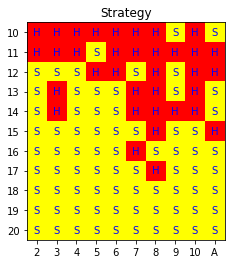

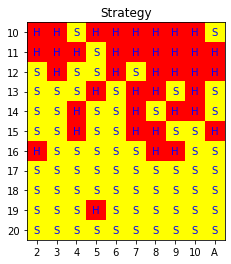

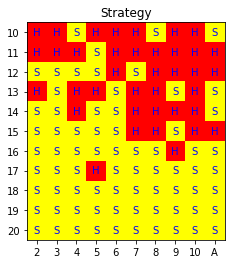

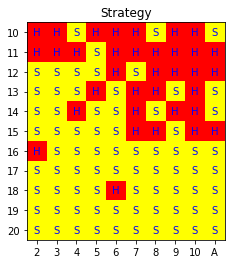

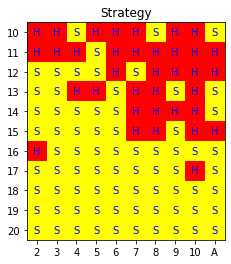

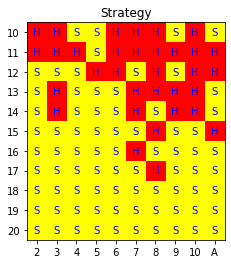

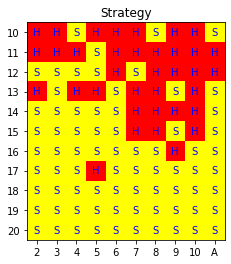

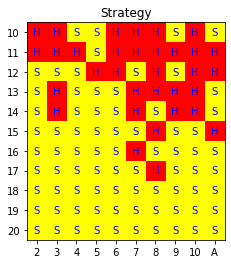

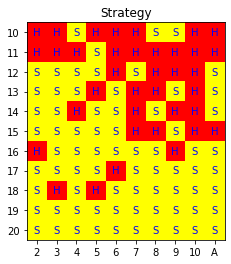

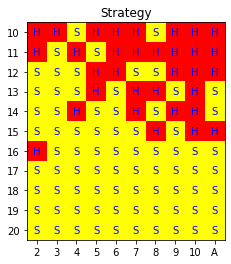

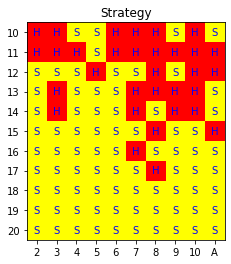

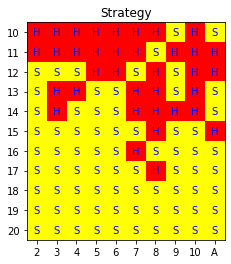

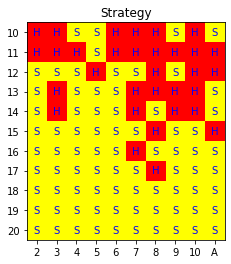

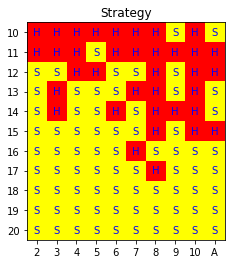

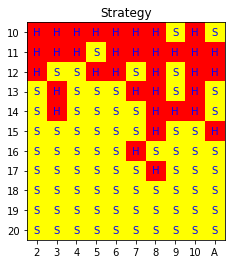

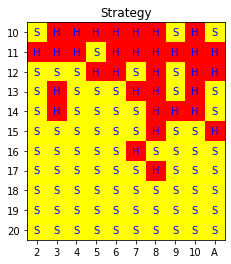

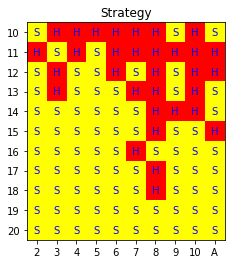

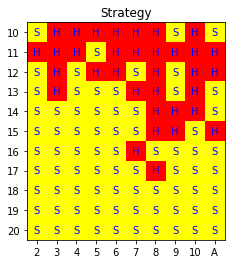

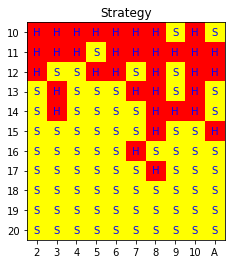

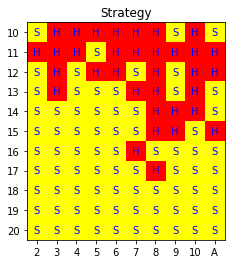

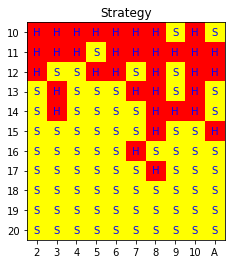

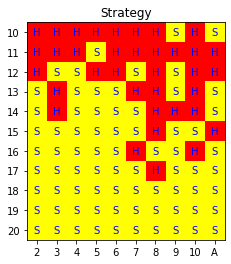

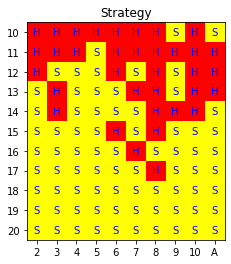

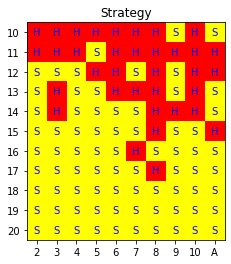

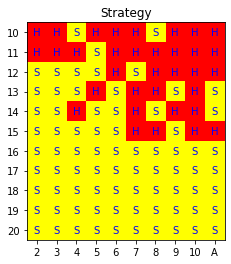

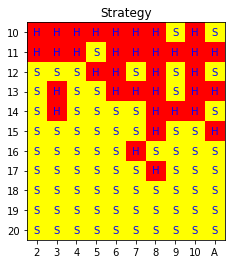

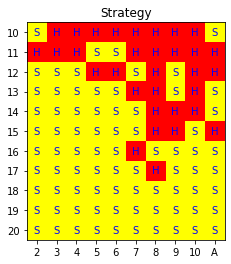

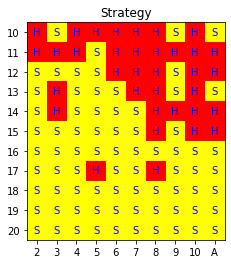

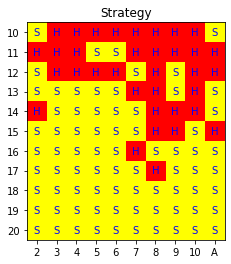

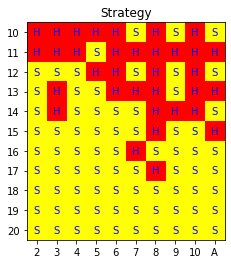

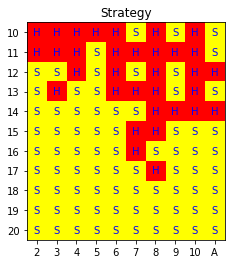

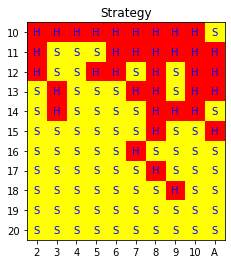

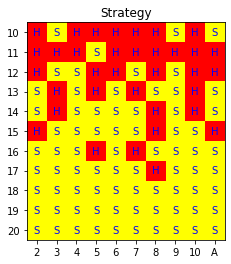

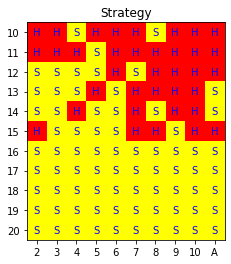

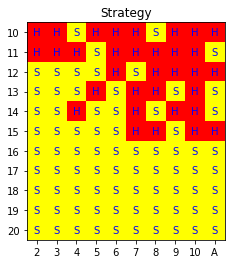

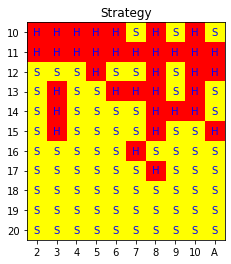

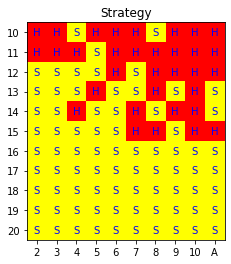

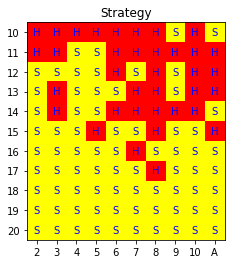

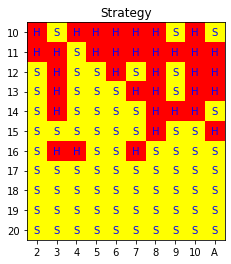

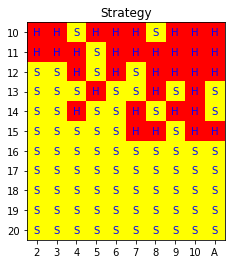

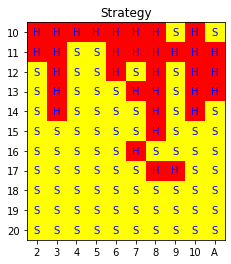

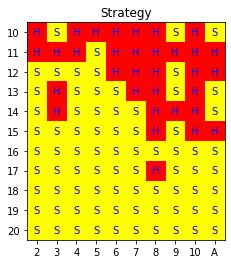

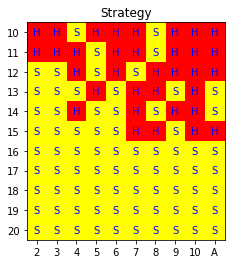

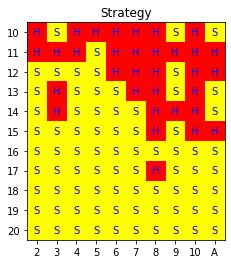

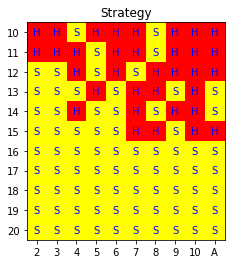

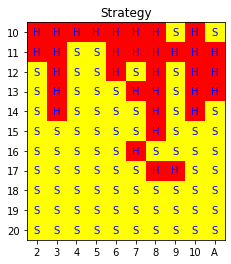

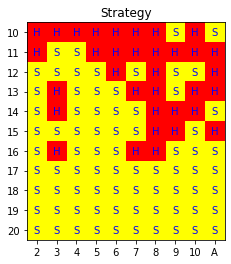

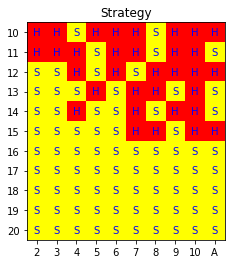

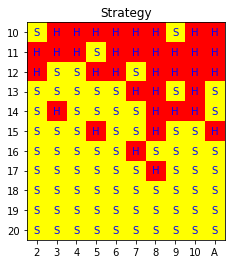

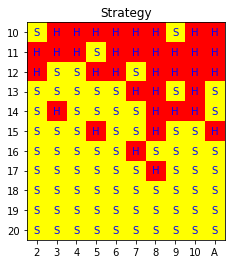

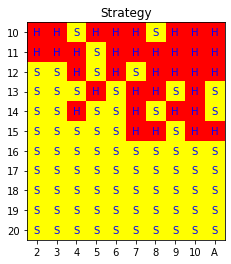

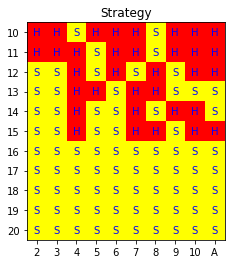

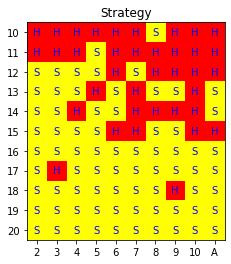

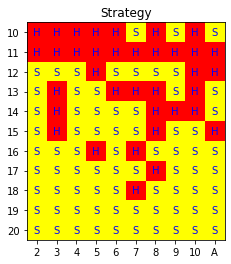

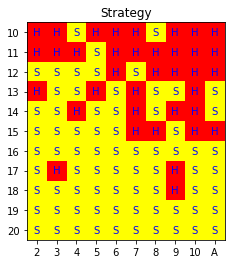

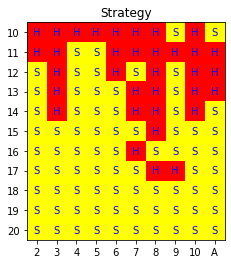

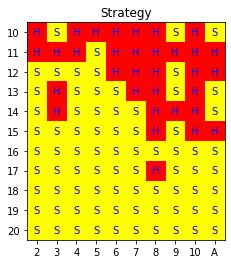

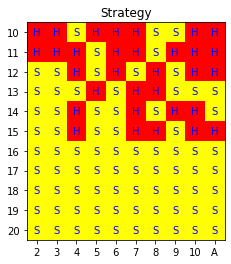

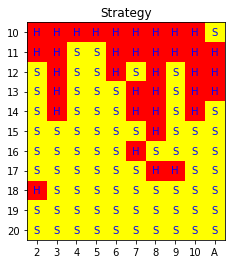

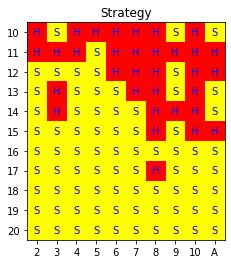

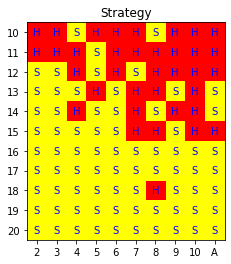

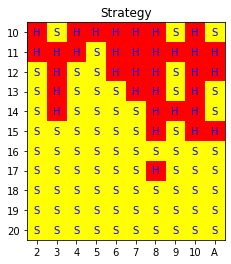

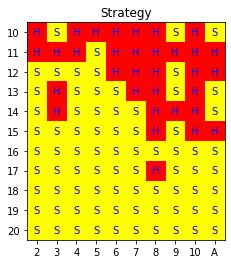

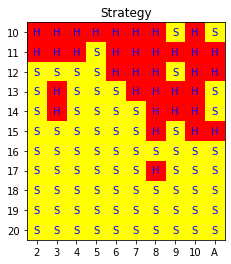

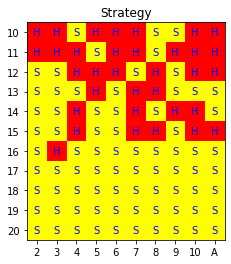

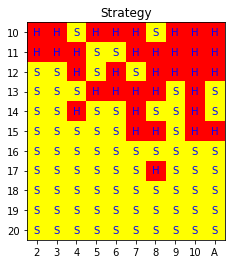

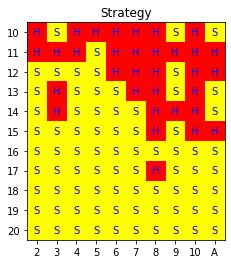

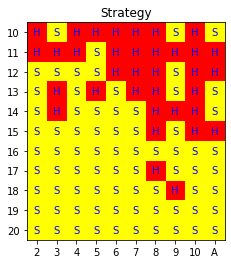

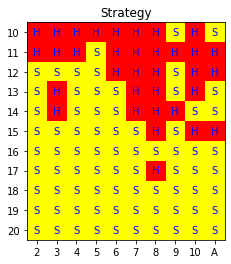

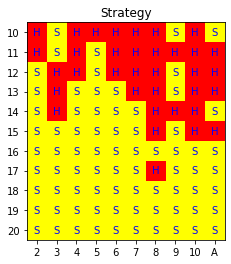

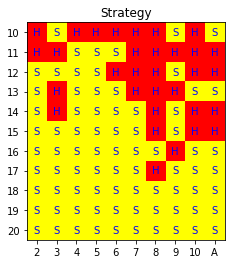

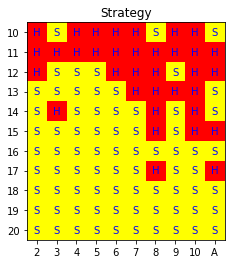

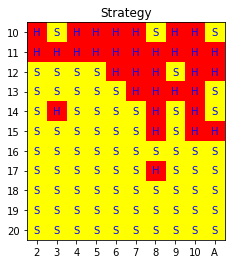

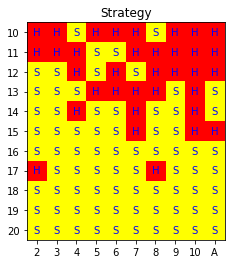

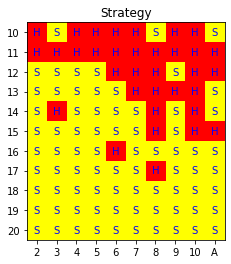

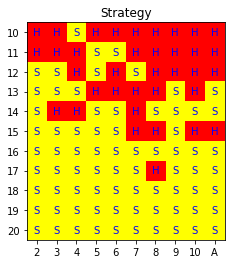

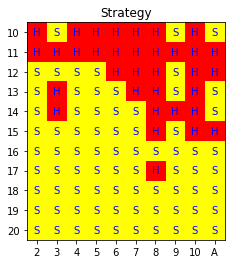

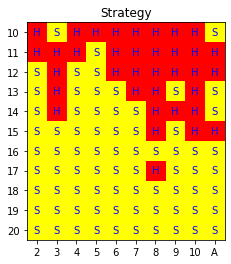

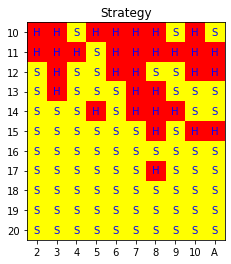

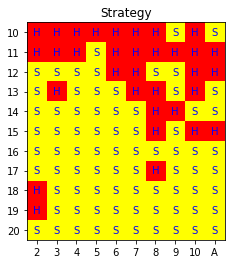

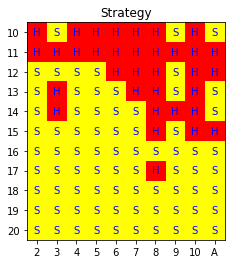

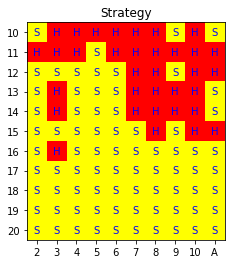

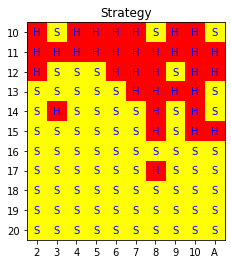

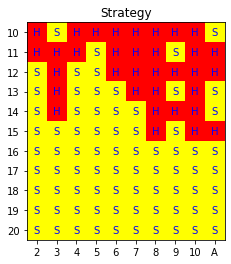

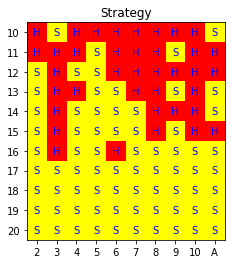

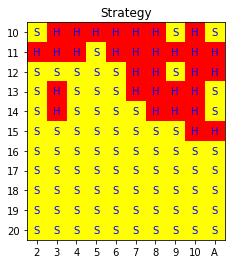

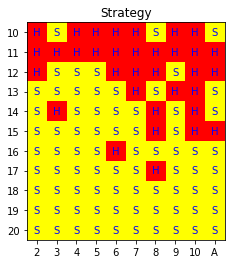

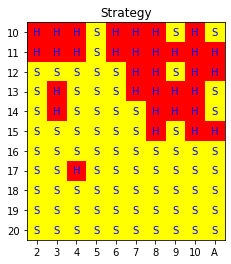

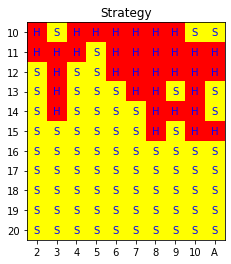

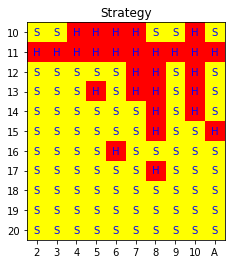

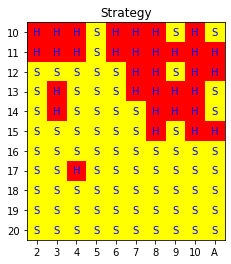

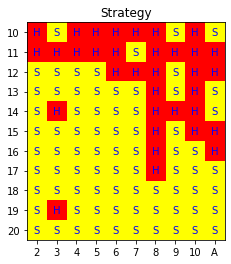

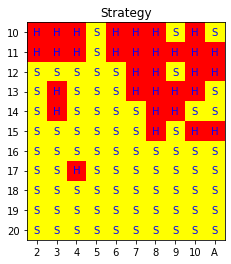

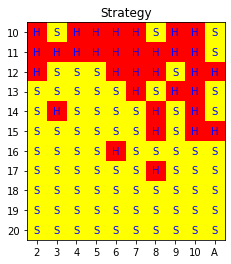

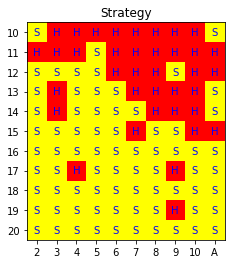

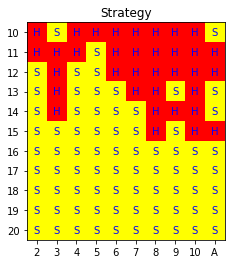

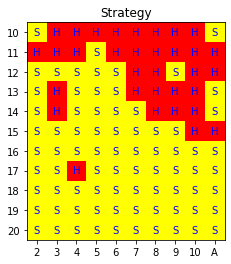

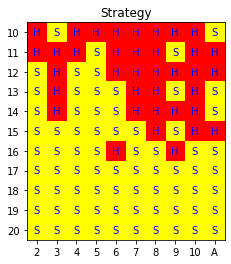

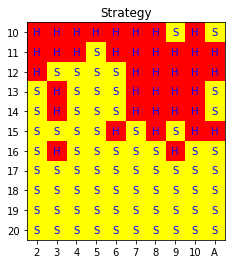

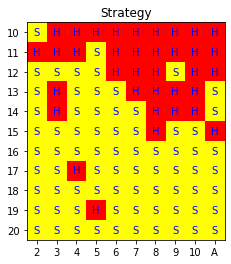

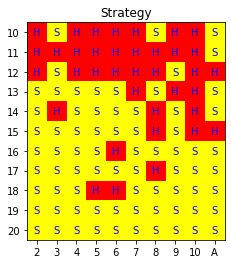

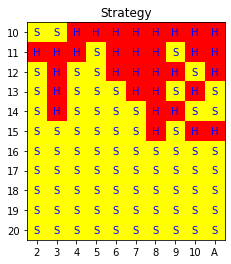

In [1296]:
for top_strategy in result.top_strategies:
    top_strategy.visualize_matrix()

# Final ideas for improvement in 1st iteration - 

- Add double, surrender, split actions to the strategy vector (not a clear binary encoding) 
- Implement soft aces in the point evaluation. 
- Implement value and power of blackjack (Now 21 from blackjack and from 10,3,8 is considered the same)
- Improve mutation and crossover
- Create one shoe of cards for every fitness evaluation (make the players improve on one specific setting).
    - The Strategies are probably going to converge to some final strategy. 
    - It is not a good simulation of reality. 
- Create best representant as a majority voting from top 10 for example
- New metrics in stats (some distance from the optimal strategy). 
- Time complexity optimisation of the code. 
- Print out the evolution of decils 
- Create a simple GUI which would take parameters, have a button, which would start the simulation and then visualize the results in a way that [This dude](https://www.youtube.com/watch?v=GOFws_hhZs8) does

## Notes from iteration one
- Strategies do not converge to one specific strategy. Probably due to the stochastic nature of the fitness function. Even for thousands of hands handed in evaluating fitness function and even for a thousand generations. 
- After certain number of iterations, no significant improvement is made. This number is around a 100
